# Solving the stochastic growth model with irreversible investment, using the bc-MC-PEA

This notebook solves an optimal growth model with irreversible investment.


---
---

## I. Model: Optimal Growth Model with Irreversible Investment

The planner’s problem is to choose consumption $\{c_t\}$ and next period’s capital $\{k_{t+1}\}$ to maximize expected utility,

\begin{equation}
\max_{\{c_t,k_{t+1}\}_{t=0}^\infty} \; E_0 \sum_{t=0}^\infty \beta^t \frac{c_t^{1-\sigma}-1}{1-\sigma}
\end{equation}

subject to the resource constraint:
\begin{equation}
k_{t+1} = z_t k_t^\alpha - c_t + (1-\delta)k_t,
\end{equation}
constraint on investment:
\begin{equation}
k_{t+1} \geq (1-\delta)k_t,
\end{equation}
the law of motion for TFP:
\begin{equation}
\log(z_{t+1}) = \rho \log(z_t) + \varepsilon_{t+1},
\end{equation}

The associated FOCs are:
\begin{equation}
\begin{split}
c_t^{-\sigma} - \mu_t &= \beta E_t \left\{ c_{t+1}^{-\sigma} \left[\alpha z_{t+1} k_{t+1}^{\alpha-1} + 1-\delta \right] - \mu_{t+1} (1 - \ \delta)\right\}, \\
\end{split}
\end{equation}

\begin{equation}
\mu_t ( k_{t+1} - (1-\delta)k_t) = 0
\end{equation}

\begin{equation}
\mu_t \geq 0
\end{equation}


#### Expectation Function $E_t[\phi_{t+1}]$:
$$
\phi_{t+1} \equiv \beta  \Big( c_{t+1}^{-\sigma} \left[\alpha z_{t+1} k_{t+1}^{\alpha-1} + 1-\delta \right] - \mu_{t+1} (1 - \ \delta).
\Big)$$
As in the standard case, a parametric approximation is used. For example, one may posit the following log-log model:
\begin{equation}
\begin{split}
\log(E_t[\phi_{t+1}]) & = \theta_0 + \theta_1 \log k_t + \theta_2 \log z_t + \theta_3 \left(\log k_t\right)^2 + \theta_4 \left(\log z_t\right)^2 + \theta_5 \log k_t \cdot \log z_t \\
& = \boldsymbol{s}_t' \boldsymbol{\theta}
\end{split}
\end{equation}

#### Implied consumption

Under the assumption that the constraint does not bind:

\begin{equation}
\tilde{c}_t = \exp(\boldsymbol{s}_t' \boldsymbol{\theta})^{-1/\sigma}
\end{equation}

Consumption choice $\tilde{c}_t$ implies a savings choice: $\tilde{k}_{t+1} = z_t k_t^\alpha - \tilde{c}_t + (1-\delta)k_t$. Two cases can occur:

1. If $\tilde{k}_{t+1} \geq (1-\delta)k_t$, then the irreversible investment constraint does not bind:

\begin{equation}
\begin{split}
c_t & = \tilde{c}_t \\
k_{t+1} &= \tilde{k}_{t+1} \\
\mu_t & = 0
\end{split}
\end{equation}

2. If $\tilde{k}_{t+1} < (1-\delta)k_t$, then the irreversible investment constraint binds and we recover $c_t$ from the budget constraint:
\begin{equation}
\begin{split}
c_t & = z_t k_t^\alpha \\
k_{t+1} & = (1-\delta)k_t \\
\mu_t & > 0
\end{split}
\end{equation}

In case 2, the value of the lagrange multiplier is then: 

\begin{equation}
\begin{split}
\mu_t & = c_t^{-\sigma} - \beta E_t \left\{ c_{t+1}^{-\sigma} \left[\alpha z_{t+1} k_{t+1}^{\alpha-1} + 1-\delta \right] - \mu_{t+1} (1 - \ \delta)\right\} \\
& \approx c_t^{-\sigma} - \exp(\boldsymbol{s}_t' \boldsymbol{\theta})
\end{split}
\end{equation}

provided that $\exp(\boldsymbol{s}_t' \boldsymbol{\theta})$ approximates correctly the conditional expectation.

### Accuracy

#### Euler equation error

unit-less Euler equation error (EEE):

\begin{equation}
\begin{split}
    EEE & = 1 - \frac{1}{c_t} \Big( \beta E_t \left\{ c_{t+1}^{-\sigma} \left[\alpha z_{t+1} k_{t+1}^{\alpha-1} + 1-\delta \right]  -\mu_{t+1} (1 - \ \delta) \right\} + \mu_t \Big)^{-1/\sigma}
\end{split}
\end{equation}

#### Mean square integration error of the OLS forecast

mean square integration error (MSIE) is given by:

\begin{equation}
    E\Big[\big(\boldsymbol{s}_m' \boldsymbol{\theta^{*}} - \boldsymbol{s}_m' \boldsymbol{\theta^{(n)}}\big)^{2} \Big] = \frac{\sigma_{g,\varepsilon}^2 k}{N(M-k-1)}, \quad \text{for } M > k+1
\end{equation}

where, by assumption, the true value for the conditional expectation is given by $E_t[\phi_{t+1}] = \boldsymbol{s}_m' \boldsymbol{\theta^{*}}$.

In practice, $\boldsymbol{\theta^{*}}$ is unknow, and instead I calculate $E_t[\phi_{t+1}]$ very accurately, using a Gaussian quadrature for the integral with respect to the innovation variable.


---

## II. Computations



</div>

### II. A. Load libraries, functions and types

In [1]:
on_Colab = False #True
import time, os

def is_chaospy_installed():
    try:
        import chaospy
        return True
    except ModuleNotFoundError:
        return False

# Usage
if is_chaospy_installed():
    print("chaospy is installed.")
else:
    print("chaospy is not installed.")

# Install deps on Colab
if (on_Colab == True) & (is_chaospy_installed() == False):
    print("Installing packages...")
    %shell pip install -v quantecon interpolation chaospy --user
    #Restart runtime
    print("Runtime is now restarting...")
    print("You can ignore the error message [Your session crashed for an unknown reason.]")
    time.sleep(0.5)
    os._exit(0)  # restart
    # torch torchcontrib torch-optimizer
else:
    print("Packages already installed")

chaospy is installed.
Packages already installed


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import random
import scipy.stats
import chaospy  ## for quadrature
from itertools import product
import os
import re
import subprocess
import shutil

import time
import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec

import seaborn as sns; sns.set()
from tqdm import tqdm as tqdm
import datetime
from typing import Tuple
class Vector: pass
from scipy.stats import norm

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset, TensorDataset
from torch.nn.utils import clip_grad_norm_

# To create copies of NN
import copy
import matplotlib.ticker as mtick
# To use sparse kronecker product
from scipy import sparse

import itertools
# Interpolations
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

# Regressions
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
lowess = sm.nonparametric.lowess

import quantecon as qe
from interpolation import interp
from quantecon.optimize import brentq
from numba import njit
#from numba.experimental import jitclass
#import copy # Not used so far

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

import platform,socket,re,uuid,json,psutil,logging, cpuinfo, shutil

from scipy.stats import chi2

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


/home/julien/.local/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
# Store parameters
class MyParams():
    """
    N: number of draws for innovation vector
    M: number of draws for the state vector
    ...
    """
    def __init__(self, N, M, lr, optimizer, nb_epochs, order_gauss,
                 beta, alpha, gamma, delta, std_tfp, rho_tfp,
                 regression_two_steps, feasible_GLS, effective_sample_size):
        # Model parameters
        self.beta = beta # Discount factor (patience)
        self.alpha = alpha # Capital share in production
        self.gamma = gamma # CRRA coefficient
        self.one_min_gamma = 1 - gamma #pre-compute
        # depreciation rate capital
        self.delta = delta
        # Standard deviation exo random variables
        self.std_tfp = std_tfp #0.01
        # Mean value exo random variables
        self.mean_tfp = 1.0
        # Persistence params
        self.rho_tfp = rho_tfp # Persistence log TFP values
        # Non stochastic steady state calculations
        self.kss = ((1 - self.beta * (1 - self.delta)) / (self.alpha * self.beta)) ** (1 / (self.alpha - 1))
        self.std_k = 0 #std. dev capital
        self.css = self.kss**self.alpha - self.delta*self.kss
        self.std_c = 0 #std. dev consumption
        self.zss = 1
        self.std_z = 0
        self.tol_c = 1e-3 #to prevent negative consumption
        # Dependent variable in level or log
        self.formula = ""
        # Options for OLS regression
        self.center_dep_var = False #True #False #demean
        self.normalize_dep_var = False #True #False #divide by std. dev
        self.nb_expl_vars = 10   # including constant
        if self.nb_expl_vars not in (4, 6, 10):
            raise ValueError( f"nb_expl_vars must be one of (4, 6, 10); got {self.nb_expl_vars}"  )
        self.basis = 2          # 1: monomial, 2: Chebyshev
        if self.basis not in (1, 2):
            raise ValueError( f"basis must be either 1 (monomial) or 2 (Chebyshev); got {self.basis}" )
        self.regression_two_steps = regression_two_steps #Use the two-step regression described in appendix (approximation to full GLS)
        self.feasible_GLS = feasible_GLS #
        if self.regression_two_steps and self.feasible_GLS:
            raise RuntimeError("Both regression_two_steps and feasible_GLS are True. Choose one of the options.")
        # Correction for serial correlation in dependent variables
        self.effective_sample_size = effective_sample_size
        self.nb_shocks = 1
        ## State: Distribution of wealth + TFP (no persistence depreciation shocks)
        self.dim_state = 2
        ## Input for neural net
        self.dim_input = 2
        self.dim_output = 1
        # Nb agents:
        self.nb_agents = 1 #One representative household
        # Functions
        ## Utility
        if self.gamma != 1:
            self.u = lambda c: (1/self.one_min_gamma)*(c**(self.one_min_gamma) - 1)
        else:
            self.u = lambda c: torch.log(c)
        self.u_prime =  lambda c: c**(-self.gamma)
        self.u_prime_inv =  lambda c: c**(-(1/self.gamma))
        # bc-MC hyperparameters
        self.N = N #number of iid shocks used for each value of the state vector
        self.M = M #number of iid realization of the state vector
        self.MN = int(M*N)
        # To keep constant the number of function evaluations
        self.T = int((M*N)/2) #number
        self.distribution_shocks = "Normal" #"Normal" #Lognormal
        # Learning parameters
        self.lr = lr
        self.momentum = 0.9 #momentum for SGD with momentum
        self.optimizer = optimizer #"Adam" #default: #Adam or SGD or SWA
        self.freq_gamma = 0.95 #When using a scheduler for the learning rate, lr_{t} = freq_gamma*lr_{t-1}
        self.use_scheduler = False #If true, use a scheduler for the learning rate
        self.nb_epochs = nb_epochs
        self.freq_scheduler = 1000
        # GAUSSIAN QUADRATURE
        ## INNOVATION VECTOR
        strr = "chaospy.Normal(0, self.std_tfp)"
        self.distrib = eval('chaospy.J({})'.format(strr))
        self.order_gauss = order_gauss
        nodes, weights = chaospy.generate_quadrature(self.order_gauss, self.distrib, rule = "gaussian", sparse=True) #dist(self.order_gauss, self.distrib, rule = "gaussian", sp=True)
        self.nodes = nodes
        self.nodes_flat =  self.nodes.flatten() #make 1d array
        self.weights = weights
        self.weights_torch = torch.tensor(weights)
        self.nodes_torch = torch.tensor(np.transpose(self.nodes)) #column=dim. Row=observation
        # Save the number of points for the guassian quadrature:
        self.N_gaussian = len(self.weights_torch)
        # Implied number of points for the current space (T=MN/2 <-> M = 2T/N)
        self.M_gaussian = int((2*self.T)/self.N_gaussian)
        self.MN_gaussian = self.N_gaussian*self.M_gaussian
        # Repeat nodes to match the number of function evaluations for the expectation
        self.nodes_torch_repeated = self.nodes_torch.repeat(self.M_gaussian, 1)


def show_params(params, limited=True):
    """
    Function to display parameter values
    """
    print("learning rate: {}".format(params.lr))
    print("nb epochs: {}".format(params.nb_epochs))
    print("M: {}".format(params.M))
    print("N: {}".format(params.N))
    print("MN: {}".format(params.MN))
    print("T: {}".format(params.T))
    print("optimizer_chosen: {}".format(params.optimizer))
    print("use_scheduler: {}".format(params.use_scheduler))
    print("center_dep_var: {}".format(params.center_dep_var))
    print("normalize_dep_var: {}".format(params.normalize_dep_var))
    print("nb_expl_vars: {}".format(params.nb_expl_vars))
    print("basis: {}".format(params.basis))
    print("regression_two_steps: {}".format(params.regression_two_steps))
    print("feasible_GLS: {}".format(params.feasible_GLS))
    print("effective_sample_size: {}".format(params.effective_sample_size))


In [4]:
info_cpu = cpuinfo.get_cpu_info()
for (name) in info_cpu:
  print(f"{name}: ", info_cpu[name])

same_machine = True #ensure same machine
machine_desired = "Intel(R) Xeon(R) CPU @ 2.20GHz"
machine_desired = "AMD EPYC 7B12"


if (on_Colab == True):
    if info_cpu['brand_raw'] != machine_desired:
      print(f"Machine is: {info_cpu['brand_raw']}. RESTARTING VM")
      print("You can ignore the error message [Your session crashed for an unknown reason.]")
      time.sleep(0.5)
      os._exit(0)  # restart
    else:
      print(f"Found desired machine: {machine_desired}")

python_version:  3.8.10.final.0 (64 bit)
cpuinfo_version:  [9, 0, 0]
cpuinfo_version_string:  9.0.0
arch:  X86_64
bits:  64
count:  12
arch_string_raw:  x86_64
vendor_id_raw:  GenuineIntel
brand_raw:  Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
hz_advertised_friendly:  2.6000 GHz
hz_actual_friendly:  2.7253 GHz
hz_advertised:  [2600000000, 0]
hz_actual:  [2725273000, 0]
stepping:  10
model:  158
family:  6
flags:  ['3dnowprefetch', 'abm', 'acpi', 'adx', 'aes', 'aperfmperf', 'apic', 'arat', 'arch_capabilities', 'arch_perfmon', 'art', 'avx', 'avx2', 'bmi1', 'bmi2', 'bts', 'clflush', 'clflushopt', 'cmov', 'constant_tsc', 'cpuid', 'cpuid_fault', 'cx16', 'cx8', 'de', 'ds_cpl', 'dtes64', 'dtherm', 'dts', 'epb', 'ept', 'ept_ad', 'erms', 'est', 'f16c', 'flexpriority', 'flush_l1d', 'fma', 'fpu', 'fsgsbase', 'fxsr', 'hle', 'ht', 'hwp', 'hwp_act_window', 'hwp_epp', 'hwp_notify', 'ibpb', 'ibrs', 'ida', 'intel_pt', 'invpcid', 'invpcid_single', 'lahf_lm', 'lm', 'mca', 'mce', 'md_clear', 'mmx', 'monitor

In [5]:
current_wd = os.getcwd()
print(current_wd)
output_extension = "irreversible_investment_2"
output_folder = output_extension + "/"
print(output_folder)

# Create folder if does not exist:
if not os.path.exists(output_folder):
    # If it doesn't exist, create it
    os.makedirs(output_folder)

# Create folder to save models
output_folder_models = output_folder + '/models/'
if not os.path.exists(output_folder_models):
    # If it doesn't exist, create it
    os.makedirs(output_folder_models)

if on_Colab == True:
    # Mount gdrive
    from google.colab import drive
    drive.mount('/gdrive')
    # For final save
    g_drive_path = '/gdrive/My Drive/bc_MC_PEA/6.irreversible_investment/'
    # Small test
    with open(g_drive_path + 'fooHello.txt', 'w') as f:
        f.write('Hello Google Drive!')

    # Autosave every 60 seconds
    %autosave 60


# If on Colab, install Octave and Matlab
if on_Colab == True:
    # Step 1: Install Octave
    !apt-get install -y octave
    !octave --version

    # Step 2: Install Dynare (this might take a bit of time)
    !apt-get install -y dynare



/home/julien/Documents/REPOSITORIES/bc-MC-PEA/3.irreversible_investment
irreversible_investment_2/


In [6]:
# Load functions
plot_scale = 0.75
plt.rcParams["figure.figsize"] = (plot_scale*16, plot_scale*9)
# Controlling fontsizes
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE =  SMALL_SIZE + 4
plt.rcParams['legend.fontsize'] = MEDIUM_SIZE
dpi_chosen=600 #control the quality of .png
linewidth_chosen = 2

In [7]:
M_chosen = 200 #200 #200 #100 #Nb draws state vector
N_chosen = 2 #Nb draws innovation vector for each realization of the state vector
lr_chosen = 1e-5 #1e-4 #4 #1e-4 #3 #5 #1e-3 #default: 1e-4 #3 #Learning rate
nb_epochs_chosen = 2000 #2000
order_gauss_chosen = 5 #number of Gaussian nodes for integration wrt to innovation vector
optimizer_chosen = "Adam" #"Adam" #"NAdam" # default: "Adam"

# Parametrization RBC
beta_chosen = 0.96 #0.95 #discount factor
alpha_chosen = 0.36 #production params
std_tfp_chosen = 0.014 #25 #025 #125 #0.125 #0.01 #0.125 #std tfp. High value for constraint to bind
gamma_chosen = 1.0 #CRRA parameter
rho_chosen = 0.92 #persistence TFP
delta_chosen = 0.1 #0.1 #depreciation rate

# Parametrization Irreversible
beta_chosen = 0.95 #0.95 #discount factor
alpha_chosen = 0.3 #production params
std_tfp_chosen = 0.14 #25 #025 #125 #0.125 #0.01 #0.125 #std tfp. High value for constraint to bind
gamma_chosen = 1.0 #CRRA parameter
rho_chosen = 0.8 #persistence TFP
delta_chosen = 0.1 #0.1 #0.1 #depreciation rate

mu_chosen = 1e-5 #e-6 #1e-5 #1e-6 #1e-6 #parameter gradient free bc-MC
mu_threshold = 1e-10 #min value for mu
mu_decay_chosen = 1.0 #0.999
use_Lookahead_chosen = False #Lookahead optimizer

# Options
regression_two_steps_chosen = False
feasible_GLS_chosen = False
effective_sample_size_chosen = True

params = MyParams(N_chosen, M_chosen, lr_chosen, optimizer_chosen,
                  nb_epochs_chosen, order_gauss_chosen,
                  beta_chosen, alpha_chosen, gamma_chosen, delta_chosen,
                  std_tfp_chosen, rho_chosen,
                  regression_two_steps_chosen, 
                  feasible_GLS_chosen, effective_sample_size_chosen)

show_params(params)

learning rate: 1e-05
nb epochs: 2000
M: 200
N: 2
MN: 400
T: 200
optimizer_chosen: Adam
use_scheduler: False
center_dep_var: False
normalize_dep_var: False
nb_expl_vars: 10
basis: 2
regression_two_steps: False
feasible_GLS: False
effective_sample_size: True


### II.B. Model WITHOUT constraint

Solve model without constraint, to have a starting point. The FOC is:

The associated FOCs are:
\begin{equation}
\begin{split}
c_t^{-\sigma} & = \beta E_t \left\{ c_{t+1}^{-\sigma} \left[\alpha z_{t+1} k_{t+1}^{\alpha-1} + 1-\delta \right] \right\}, \\
\end{split}
\end{equation}

#### II.B.1. 1st order solution using Dynare. Ignore constraint.

In [8]:
fname = "neogrowth.mod"
dirpath = os.getcwd()  # Get the current working directory
fpath = os.path.join(dirpath, fname)

if on_Colab == True:
  dirpath = output_folder  # Get the current working directory
  fpath = os.path.join(dirpath, fname)
  with open(output_folder + 'fooColab.txt', 'w') as f:
    f.write('Hello Google Drive!')

file_content_1 = """
% optimal_growth.mod
% Dynare file for the standard optimal growth model (first-order approximation)

var k c z;
varexo eps;

parameters beta gamma alpha delta rho sigma_eps;

% Parameter values
beta      = {beta};
gamma     = {gamma};      % CRRA coefficient
alpha     = {alpha};
delta     = {delta};
rho       = {rho_tfp};
sigma_eps = {std_tfp};

model;
% Euler equation (after substituting the marginal utility condition)
c^(-gamma) = beta * c(+1)^(-gamma) * ( alpha * z(+1) * k^(alpha-1) + 1 - delta );

% Resource constraint (law of motion for capital)
k = z * k(-1)^alpha - c + (1-delta)*k(-1);

% Technology process (AR(1) in logs)
log(z) = rho*log(z(-1)) + eps;

end;

initval;
% Initial guesses for the steady state
k   = ((alpha*beta)/(1 - beta*(1-delta)))^(1/(1-alpha));
c   = ((alpha*beta)/(1 - beta*(1-delta)))^(alpha/(1-alpha)) - delta*(((alpha*beta)/(1 - beta*(1-delta)))^(alpha/(1-alpha)));
z   = 1;
eps = 0;
end;

steady;
check;

shocks;
var eps = sigma_eps^2;
end;

% IRF
stoch_simul(order=1, irf=100);

% SIMULATED SERIES
stoch_simul(periods=50000);
""".format(beta = params.beta, alpha = params.alpha,  gamma = params.gamma,
           delta = params.delta, std_tfp = params.std_tfp, rho_tfp = params.rho_tfp)

file_content = file_content_1
# Concat stings
# Write the content to the file
with open(fpath, "w") as file:
    file.write(file_content)

root_path = ""
if on_Colab == False:
    # Run the shell script locally.
    print("Calculating linearized model using Dynare")
    result = subprocess.run(['./solve_neogrowth.sh'], capture_output=True, text=True)
    # Print the output of the script
    print(result.stdout)
    print(result.stderr)
# Desgined to run on Google Colab
else:
    print("Calculating linearized model using Octave Dynare")
    root_path = output_folder

    # Now modify the .m file to include cd at top (before running)
    with open(g_drive_path + 'solve_neogrowth_octave.m', 'r') as file:
        lines = file.readlines()

    # Insert cd command at top (right after patches if any)
    lines.insert(0, f"cd '{output_folder}';\n")

    with open('solve_neogrowth_octave_2.m', 'w') as file:
        file.writelines(lines)

    # Now run it
    !octave solve_neogrowth_octave_2.m


Calculating linearized model using Dynare
MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2016 The MathWorks, Inc.
                   R2016a (9.0.0.341360) 64-bit (glnxa64)
                             February 11, 2016

 
To get started, type one of these: helpwin, helpdesk, or demo.
For product information, visit www.mathworks.com.
 
>> >> >> >> >> >> >> Using 64-bit preprocessor
Starting Dynare (version 4.6.0).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Found 3 equation(s).
Evaluating expressions...done
Computing static model derivatives (order 1).
Computing dynamic model derivatives (order 1).
Processing outputs ...
done
Preprocessing completed.


STEADY-STATE RESULTS:

k 		 2.62575
c 		 1.07333
z 		 1

EIGENVALUES:
         Modulus             Real        Imaginary

             0.8              0.8                0
           0.838            0.838               

  Variable  MeanValue
0        k   2.613440
1        c   1.069586
2        z   0.997695
              k         c         z
0      2.690386  1.109249  1.075273
1      2.952103  1.238448  1.316963
2      2.845418  1.113473  0.937332
3      2.870433  1.154152  1.070569
4      2.917598  1.174081  1.101083
...         ...       ...       ...
49995  2.483443  1.016067  0.919068
49996  2.584847  1.086326  1.091241
49997  2.778884  1.168689  1.218239
49998  2.992457  1.238657  1.277593
49999  3.222247  1.312731  1.336767

[50000 rows x 3 columns]


/home/julien/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


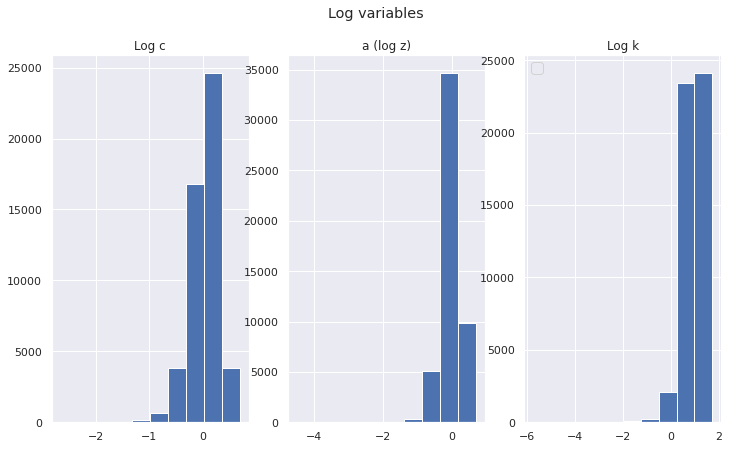

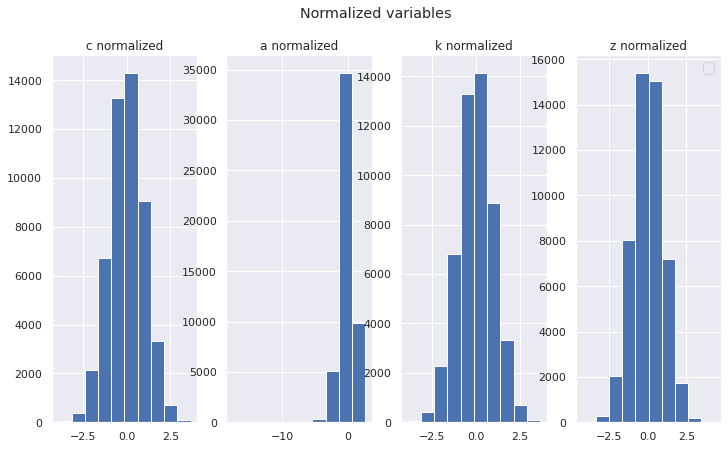

          k         z         a  k_demeaned  a_demeaned  z_demeaned  \
0  2.690386  1.075273  0.072575    0.064640    0.072575    0.075273   
1  2.952103  1.316963  0.275328    0.326357    0.275328    0.316963   
2  2.845418  0.937332 -0.064718    0.219673   -0.064718   -0.062668   
3  2.870433  1.070569  0.068191    0.244687    0.068191    0.070569   
4  2.917598  1.101083  0.096294    0.291853    0.096294    0.101083   

   k_normalized  a_normalized  z_normalized  cond_exp  cond_exp_2  cond_exp_3  \
0      0.079320      0.284423      0.324453  0.832432    1.024253    0.371230   
1      0.400472      1.079019      1.366213  0.883254    1.354695    0.418023   
2      0.269560     -0.253633     -0.270122  0.867170    1.075138    0.393803   
3      0.300255      0.267242      0.304178  0.854542    1.138308    0.392769   
4      0.358132      0.377379      0.435700  0.901398    1.242547    0.418373   

   cond_exp_4  cond_exp_5  cond_exp_6  cond_exp_7  
0    0.893476    2.725898   -0.106

/home/julien/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/julien/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/julien/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/julien/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/julien/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/julien/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invali

                            OLS Regression Results                            
Dep. Variable:             cond_exp_7   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 1.282e+05
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:58   Log-Likelihood:                 73956.
No. Observations:               49934   AIC:                        -1.479e+05
Df Residuals:                   49924   BIC:                        -1.478e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

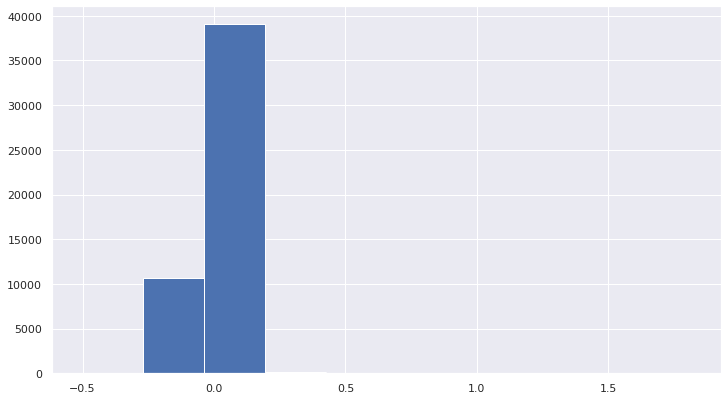

Intercept                                0.227887
np.log(k)                               -0.406091
a                                       -0.444995
np.log(k):a                              0.183924
I(np.log(k) ** 2 - 1)                   -0.096622
I(a ** 2 - 1)                           -0.094368
I(4 * np.log(k) ** 3 - 3 * np.log(k))   -0.000975
I(4 * a ** 3 - 3 * a)                    0.000922
I((np.log(k) ** 2 - 1) * a)             -0.010289
I(np.log(k) * (a ** 2 - 1))              0.005864
dtype: float64
[ 0.22788678 -0.40609072 -0.44499522  0.18392413 -0.09662209 -0.09436849
 -0.00097479  0.00092188 -0.01028892  0.00586437]


In [9]:
#Load simulated data and fit linear model
SS_values = pd.read_csv(root_path + "output/Linearization/SS_values.csv")
print(SS_values)

Sim_series = pd.read_csv(root_path + "output/Linearization/Sim_series.csv")
print(Sim_series)

# Load the data
Sim_series = pd.read_csv(root_path + "output/Linearization/Sim_series.csv")

## Simulate realization conditional expectation
Sim_series['c_plus_1'] = Sim_series['c'].shift(-1)
Sim_series['z_plus_1'] = Sim_series['z'].shift(-1)
Sim_series['k_plus_1'] = Sim_series['k'].shift(-1)
Sim_series['cond_exp'] = params.beta  * (Sim_series['c_plus_1']**(-params.gamma)) * ( params.alpha * Sim_series['z_plus_1'] * Sim_series['k_plus_1']**(params.alpha - 1) + 1 - params.delta )
# Production
Sim_series['cash'] = Sim_series['z'] * Sim_series['k']**params.alpha + (1 - params.delta)*Sim_series['k'] - Sim_series['c']
# Log tfp
Sim_series['a'] = np.log(Sim_series['z'])
params.std_z = np.std(Sim_series['z'])

# Centered vars
Sim_series['c_demeaned'] = Sim_series['c'] - params.css
Sim_series['a_demeaned'] = Sim_series['a'] # mean is 0
Sim_series['z_demeaned'] = Sim_series['z'] - params.zss
Sim_series['k_demeaned'] = Sim_series['k'] - params.kss

# Normalize vars:
params.std_c = np.std(Sim_series['c'])
params.std_a = np.std(Sim_series['a'])
params.std_z = np.std(Sim_series['z'])
params.std_k = np.std(Sim_series['k'])

Sim_series['c_normalized'] = Sim_series['c_demeaned']/params.std_c
Sim_series['a_normalized'] = Sim_series['a_demeaned']/params.std_a
Sim_series['z_normalized'] = Sim_series['z_demeaned']/params.std_z
Sim_series['k_normalized'] = Sim_series['k_demeaned']/params.std_k

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Log variables')
ax1.hist(np.log(Sim_series['c']))
ax1.set_title("Log c")
ax2.hist(Sim_series['a'])
ax2.set_title("a (log z)")
ax3.hist(np.log(Sim_series['k']))
ax3.set_title("Log k")
plt.legend()
plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.suptitle('Normalized variables')
ax1.hist(Sim_series['c_normalized'])
ax1.set_title("c normalized")
ax2.hist(Sim_series['a_normalized'])
ax2.set_title("a normalized")
ax3.hist(Sim_series['k_normalized'])
ax3.set_title("k normalized")
ax4.hist(Sim_series['z_normalized'])
ax4.set_title("z normalized")
plt.legend()
plt.show()

# Transformed version of the conditional expectation
## Euler: 1 = E_t(...)
## c_t = E_t(c_t * (...))
Sim_series['cond_exp_2'] = Sim_series['c'] * params.beta  * ( (Sim_series['c_plus_1']/Sim_series['c'])**(-params.gamma) ) * ( params.alpha * Sim_series['z_plus_1'] * Sim_series['k_plus_1']**(params.alpha - 1) + 1 - params.delta )

## c_t/cash_t = E_t(c_t/cash_ * (...))
Sim_series['cond_exp_3'] = (Sim_series['c']/Sim_series['cash']) * params.beta  * ((Sim_series['c_plus_1']/Sim_series['c'])**(-params.gamma)) * ( params.alpha * Sim_series['z_plus_1'] * Sim_series['k_plus_1']**(params.alpha - 1) + 1 - params.delta )

## (c_t/c_ss)**(-sigma) = E_t()
Sim_series['cond_exp_4'] = params.beta  * ((Sim_series['c_plus_1']/params.css)**(-params.gamma)) * ( params.alpha * Sim_series['z_plus_1'] * Sim_series['k_plus_1']**(params.alpha - 1) + 1 - params.delta )

# kt+1
Sim_series['cond_exp_5'] = params.beta * Sim_series['k_plus_1'] * ((Sim_series['c_plus_1']/Sim_series['c'])**(-params.gamma)) * ( params.alpha * Sim_series['z_plus_1'] * Sim_series['k_plus_1']**(params.alpha - 1) + 1 - params.delta )

# Percentage diff from c_ss
Sim_series['cond_exp_6'] = params.beta  * ((Sim_series['c_plus_1']/params.css)**(-params.gamma)) * ( params.alpha * Sim_series['z_plus_1'] * Sim_series['k_plus_1']**(params.alpha - 1) + 1 - params.delta ) - 1

# rhs Euler, in logs
Sim_series['cond_exp_7'] = np.log(Sim_series['cond_exp'])

df_Dynare = pd.DataFrame({'k': Sim_series['k'], 'z': Sim_series['z'], 'a': Sim_series['a'],
                          'k_demeaned': Sim_series['k_demeaned'], 'a_demeaned': Sim_series['a_demeaned'], 'z_demeaned': Sim_series['z_demeaned'],
                          'k_normalized': Sim_series['k_normalized'], 'a_normalized': Sim_series['a_normalized'], 'z_normalized': Sim_series['z_normalized'],
                          'cond_exp':  Sim_series['cond_exp'],
                          'cond_exp_2':  Sim_series['cond_exp_2'],
                         'cond_exp_3':  Sim_series['cond_exp_3'],
                         'cond_exp_4':  Sim_series['cond_exp_4'],
                         'cond_exp_5':  Sim_series['cond_exp_5'],
                         'cond_exp_6':  Sim_series['cond_exp_6'],
                         'cond_exp_7':  Sim_series['cond_exp_7']
                         })

print(df_Dynare.head())

## Log-log model
model = smf.ols(formula='np.log(cond_exp) ~ np.log(k) + np.log(z) + I(np.log(k)**2) + I(np.log(z)**2) + np.log(k)*np.log(z)', data=df_Dynare).fit()
print(model.summary())

cond_exp_chosen = 7
if (params.center_dep_var == True) & (params.normalize_dep_var == True):
    x1_chosen = "k_normalized"
    x2_chosen = "a_normalized"
elif (params.center_dep_var == True) & (params.normalize_dep_var == False):
    x1_chosen = "k_demeaned"
    x2_chosen = "a_demeaned"
else:
    x1_chosen = "np.log(k)"
    x2_chosen = "a"



if params.nb_expl_vars == 4:
    # only main + interaction
    formula_OLS = (
        f"cond_exp_{cond_exp_chosen} ~ "
        f"{x1_chosen} + {x2_chosen} + {x1_chosen}*{x2_chosen}"
    )

elif params.nb_expl_vars == 6:
    if params.basis == 1:
        # monomial up to degree 2
        formula_OLS = (
            f"cond_exp_{cond_exp_chosen} ~ "
            f"{x1_chosen} + {x2_chosen} + {x1_chosen}*{x2_chosen} + "
            f"I({x1_chosen}**2) + I({x2_chosen}**2)"
        )
    else:
        # Chebyshev up to order 2
        formula_OLS = (
            f"cond_exp_{cond_exp_chosen} ~ "
            f"{x1_chosen} + {x2_chosen} + {x1_chosen}*{x2_chosen} + "
            f"I({x1_chosen}**2 - 1) + I({x2_chosen}**2 - 1)"
        )

elif params.nb_expl_vars == 10:
    if params.basis == 1:
        # monomial up to degree 3
        formula_OLS = (
            f"cond_exp_{cond_exp_chosen} ~ "
            f"{x1_chosen} + {x2_chosen} + {x1_chosen}*{x2_chosen} + "
            f"I({x1_chosen}**2) + I({x2_chosen}**2) + "
            f"I({x1_chosen}**3) + I({x1_chosen}**2*{x2_chosen}) + "
            f"I({x1_chosen}*{x2_chosen}**2) + I({x2_chosen}**3)"
        )
    else:
        # Chebyshev up to order 3
        formula_OLS = (
            f"cond_exp_{cond_exp_chosen} ~ "
            f"{x1_chosen} + {x2_chosen} + {x1_chosen}*{x2_chosen} + "
            f"I({x1_chosen}**2 - 1) + I({x2_chosen}**2 - 1) + "
            f"I(4*{x1_chosen}**3 - 3*{x1_chosen}) + "
            f"I(4*{x2_chosen}**3 - 3*{x2_chosen}) + "
            f"I(({x1_chosen}**2 - 1)*{x2_chosen}) + "
            f"I({x1_chosen}*({x2_chosen}**2 - 1))"
        )

else:
    raise ValueError(
        f"nb_expl_vars must be one of 4,6,10; got {params.nb_expl_vars}"
    )

model = smf.ols(formula=formula_OLS, data=df_Dynare).fit()


print(model.summary())
plt.hist(model.resid)
plt.show()

coeff_vector = model.params
print(coeff_vector)

coeff_array_0 = model.params.values
print(coeff_array_0)


#### II.B.2. Basline PEA

In [10]:
@njit
def fill_X_row(X, i, x1, x2, nb_expl_vars, basis):
    """
    Fill row i of the design matrix X in place, using either
      - basis=1 : monomial basis
      - basis=2 : Chebyshev basis
    up to nb_expl_vars terms (4, 6 or 10).
    
    After calling this, X[i,:] will be set.
    """
    if nb_expl_vars == 4:
        # simple cross basis
        X[i, :] = np.array([1, x1, x2, x1*x2])
        return

    if basis == 1:
        # —— Monomial basis ——
        if nb_expl_vars == 6:
            # total degree ≤2
            X[i, :] = np.array([
                1,
                x1,
                x2,
                x1 * x2,
                x1**2,
                x2**2
            ])
        elif nb_expl_vars == 10:
            # total degree ≤3
            X[i, :] = np.array([
                1,
                x1,
                x2,
                x1 * x2,
                x1**2,
                x2**2,
                x1**3,
                x1**2 * x2,
                x1 * x2**2,
                x2**3
            ])
        else:
            raise ValueError(
                f"Monomial basis with nb_expl_vars={nb_expl_vars} not supported"
            )

    elif basis == 2:
        # —— Chebyshev basis ——
        if nb_expl_vars == 6:
            # order ≤2 Chebyshev: T_i(x)T_j(y), i+j≤2
            X[i, :] = np.array([
                1,                   # T0(x)T0(y)
                x1,                  # T1(x)T0(y)
                x2,                  # T0(x)T1(y)
                x1 * x2,             # T1(x)T1(y)
                (x1**2 - 1),         # T2(x)T0(y)
                (x2**2 - 1)          # T0(x)T2(y)
            ])
        elif nb_expl_vars == 10:
            # order ≤3 Chebyshev: T_i(x)T_j(y), i+j≤3
            X[i, :] = np.array([
                1,                     # T0(x)T0(y)
                x1,                    # T1(x)T0(y)
                x2,                    # T0(x)T1(y)
                x1 * x2,               # T1(x)T1(y)
                (x1**2 - 1),           # T2(x)T0(y)
                (x2**2 - 1),           # T0(x)T2(y)
                (4*x1**3 - 3*x1),      # T3(x)T0(y)
                (4*x2**3 - 3*x2),      # T0(x)T3(y)
                (x1**2 - 1) * x2,      # T2(x)T1(y)
                x1 * (x2**2 - 1)       # T1(x)T2(y)
            ])
        else:
            raise ValueError(
                f"Chebyshev basis with nb_expl_vars={nb_expl_vars} not supported"
            )

    else:
        raise ValueError(f"Unknown basis={basis}; must be 1 or 2")

def build_design_matrix(x1, x2, nb_expl_vars, basis):
    """
    Build the full design matrix X for vectors x1, x2 of length n,
    using either a monomial basis (basis=1) or Chebyshev basis (basis=2),
    with either 4, 6 or 10 regressors (nb_expl_vars).

    Returns
    -------
    X : ndarray, shape (n, nb_expl_vars)
    """
    n = len(x1)
    X = np.empty((n, nb_expl_vars))
    for i in range(n):
        fill_X_row(X, i, x1[i], x2[i], nb_expl_vars, basis)
    return X


Intial b0: [ 0.22788678 -0.40609072 -0.44499522  0.18392413 -0.09662209 -0.09436849
 -0.00097479  0.00092188 -0.01028892  0.00586437]
Iteration: 1	Conv. crit.: 0.09101961434366196	 b: [ 0.29667644 -0.47654181 -0.47402869  0.09290452 -0.0444495  -0.081193
 -0.0022381  -0.00112519  0.01255853 -0.01067622]
Iteration: 2	Conv. crit.: 0.039307507880576464	 b: [ 0.30040481 -0.48662956 -0.5133362   0.08586458 -0.02522582 -0.09331814
 -0.00254943 -0.00129047  0.01510227 -0.00530184]
Iteration: 3	Conv. crit.: 0.017641619622028815	 b: [ 3.05239962e-01 -4.89608935e-01 -5.30977821e-01  8.81038502e-02
 -1.77537730e-02 -9.24851559e-02 -2.50184185e-03 -4.88682349e-04
  1.48767536e-02 -4.05617247e-03]
Iteration: 4	Conv. crit.: 0.007059190481581101	 b: [ 3.09285547e-01 -4.89988282e-01 -5.38037011e-01  9.06633866e-02
 -1.49596080e-02 -8.88279102e-02 -2.35066351e-03 -2.55794894e-05
  1.44290006e-02 -3.74990965e-03]
Iteration: 5	Conv. crit.: 0.002889880161461772	 b: [ 3.11422047e-01 -4.88959484e-01 -5.4079

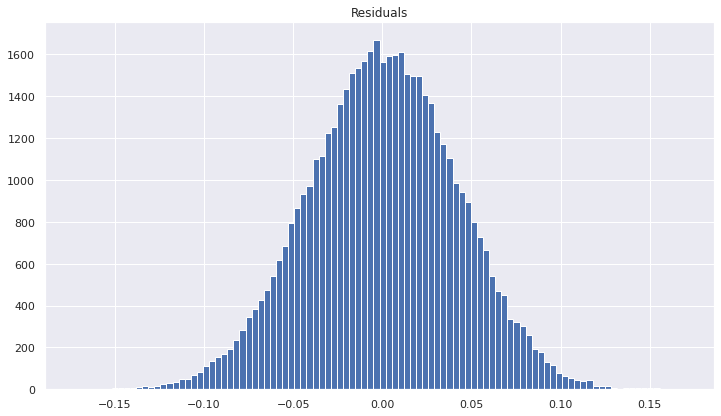

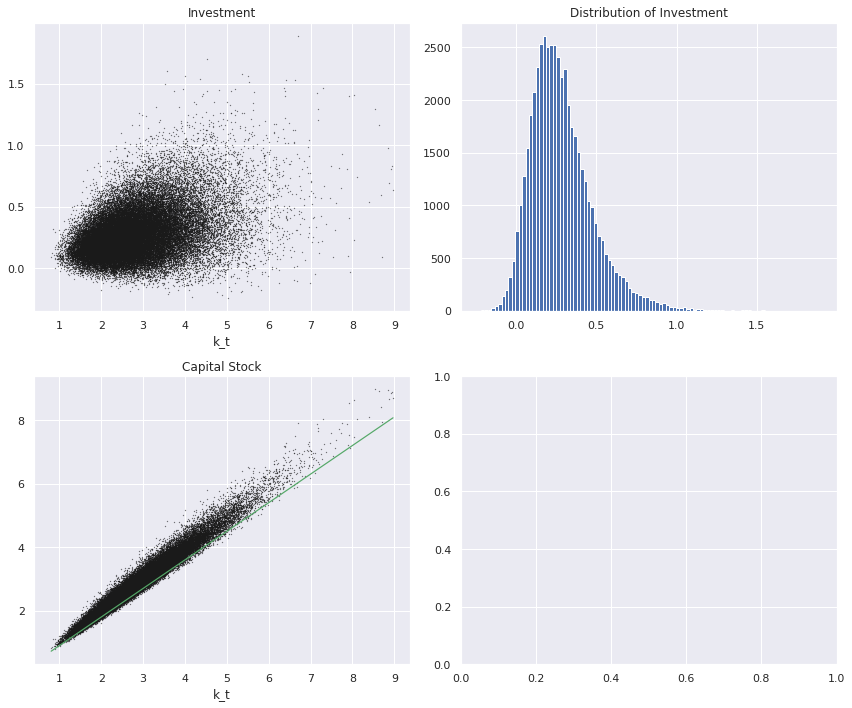

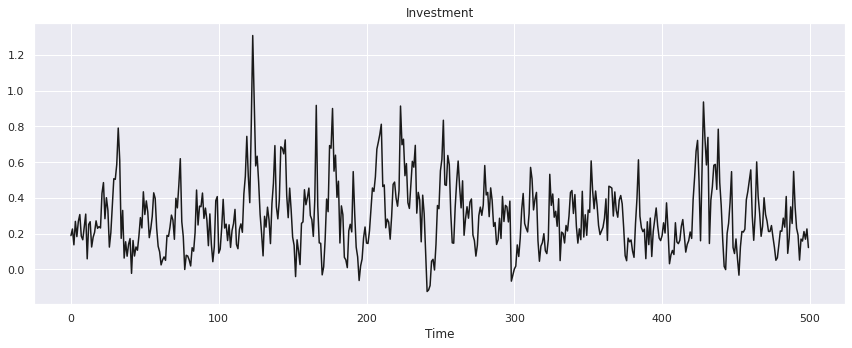

In [11]:
# Usual PEA
tol = 1e-6
gam = 1.0
init = 100 #burnin
long = 50000
slong = init + long

# SS value. Use mean values on the simulation
k_ss = SS_values[SS_values["Variable"] == "k"]["MeanValue"].item()
a_ss = 0
c_ss = SS_values[SS_values["Variable"] == "c"]["MeanValue"].item()

# Indexes
T = np.arange(init, slong-1)      
T1 = np.arange(init+1, slong)    

# Compute initial conditions:
print(f"Intial b0: {coeff_array_0}")
b0 = coeff_array_0

# Generate shocks: e is a vector of size slong with normally distributed shocks scaled by se
e = params.std_tfp * np.random.randn(slong)

# Initialize a as a vector of zeros
a = np.zeros(slong)

# Set the first element of a
a[0] = a_ss

# Generate the AR(1) process for a
for i in range(1, slong):
    a[i] = params.rho_tfp * a[i-1] + e[i]

# Initialize iteration counter and convergence criterion
iteration = 1
crit = np.inf  # set to a large number initially

while crit > tol:
#while iteration < 10:
    k = np.zeros(slong + 1)
    c = np.zeros(slong)
    X = np.zeros((slong, len(b0)))
    cash = np.zeros(slong)

    # Set initial capital:
    k[0] = k_ss

    # Simulate the path:
    for i in range(slong):
        # Construct the regressors at time i.
        if (params.center_dep_var == True) & (params.normalize_dep_var == True):
            x1 = (k[i] - params.kss)/params.std_k
            x2 = a[i]/params.std_a
        elif (params.center_dep_var == True) & (params.normalize_dep_var == False):
            x1 = (k[i] - params.kss)
            x2 = a[i]
        else:
            x1 = np.log(k[i])
            x2 = a[i]

        # Set values fo X:
        fill_X_row(X, i, x1, x2, params.nb_expl_vars, params.basis)
        
        # Cash on hand
        cash[i] = np.exp(a[i]) * (k[i]**params.alpha) + (1 - params.delta) * k[i]

        # Update capital for the next period using the model's law of motion
        if cond_exp_chosen == 2:
            c[i] = params.css*np.maximum(params.tol_c, np.dot(X[i, :], b0))**(-1/params.gamma)
            c[i] = np.maximum(params.tol_c, c[i])
            k[i+1] = np.maximum(cash[i] - c[i], params.tol_c)
        elif cond_exp_chosen == 5:
            k[i+1] = np.maximum(np.dot(X[i, :], b0), params.tol_c)
            c[i] = np.maximum(params.tol_c, cash[i] - k[i+1])
        elif cond_exp_chosen == 6:
            y = np.dot(X[i, :], b0)
            c[i] = params.css*(1 + y)**(-1/params.gamma)
            c[i] = np.maximum(params.tol_c, c[i])
            k[i+1] = np.maximum(cash[i] - c[i], params.tol_c)
        elif cond_exp_chosen == 7:
            c[i] = np.exp(np.dot(X[i, :], b0))**(-1/params.gamma)
            k[i+1] = np.maximum(cash[i] - c[i], params.tol_c)
        else:
            print(f"cond_exp_chosen : {cond_exp_chosen} not implemented yet)")
    # Construct the vector y using the simulated paths (vectorized operation)
    if cond_exp_chosen == 2:
        y = params.beta * ( (c[T1]/params.css)**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1]**(params.alpha - 1) + 1 - params.delta)
    elif cond_exp_chosen == 5:
        y = params.beta * (k[T1]) * ( (c[T1]/c[T])**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1]**(params.alpha - 1) + 1 - params.delta)
    elif cond_exp_chosen == 6:
        y = params.beta * ( (c[T1]/params.css)**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1]**(params.alpha - 1) + 1 - params.delta) - 1
    elif cond_exp_chosen == 7:
        y = np.log( params.beta * ( ( c[T1] ) ** ( -params.gamma ) ) * (params.alpha * np.exp(a[T1]) * k[T1]**(params.alpha - 1) + 1 - params.delta) )
    
    # Solve the regression: log(y) = X(T,:) * bt in a least-squares sense.
    # np.linalg.lstsq returns a tuple; the first element is the solution.
    y_reg = y
    X_reg = X[T, :]
    bt, _, _, _ = np.linalg.lstsq(X_reg, y_reg, rcond=None)

    if params.regression_two_steps == True:
        print(f"Step 1 coef: {bt}")
        # Square root of weights, when using log model
        sqrt_w = np.exp(X_reg @ bt)
        # Pre-multiply and then regress again
        X_wls = X_reg * sqrt_w[:, None]
        y_wls = y_reg * sqrt_w
        bt, _, _, _ = np.linalg.lstsq(X_wls, y_wls, rcond=None)
        print(f"Step 2 coef: {bt}")
    elif params.feasible_GLS == True:
        print(f"Step 1 coef: {bt}")
        ## residuals
        e0 = y_reg - X_reg @ bt
        # Estimate the variance‐function via a log‐linear model
        # use X_reg as Z, but you can build a richer Z = f(state)
        Z = X_reg
        # add tiny constant to avoid log(0)
        log_u = np.log(e0**2 + 1e-12)                    
        gamma, *_ = np.linalg.lstsq(Z, log_u, rcond=None)
        # fitted log‐variance and variance estimate
        log_var_hat = Z @ gamma          # E[log(e^2)|Z]
        var_hat     = np.exp(log_var_hat)  # ≈ Var(e_m) * N
        # Construct inverse‐variance weights and do WLS
        w       = 1.0 / var_hat        
        sqrt_w  = np.sqrt(w)
        # Pre-multiply and then regress again
        X_wls = X_reg * sqrt_w[:, None]
        y_wls = y_reg * sqrt_w
        bt, _, _, _ = np.linalg.lstsq(X_wls, y_wls, rcond=None)
        print(f"Step 2 coef FGLS: {bt}")
    
    # Update b using a smoothing parameter gam:
    b = gam * bt + (1 - gam) * b0

    # Compute convergence criterion (maximum absolute change in b)
    crit = np.max(np.abs(b - b0))

    # Update b0 for the next iteration
    b0 = b.copy()

    # Display current iteration and convergence criterion
    print(f"Iteration: {iteration}\tConv. crit.: {crit}\t b: {b}")

    iteration += 1

# residual
Res = y_reg - np.dot(X[T, :], b0)
MSE = np.mean(Res ** 2)

# =============================================================================
# Plotting results
# =============================================================================
# 1. Plot histogram of residuals
plt.figure()
plt.hist(Res, bins=100)
plt.title('Residuals', fontname='Times', fontsize=12)

# 2. Compute investment deviations: it = k[T1] - (1-delta)*k[T]
it = k[T1] - (1 - params.delta) * k[T]

# Create a 2x2 figure for several plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Investment scatter plot
axs[0, 0].plot(k[T], it, '.', markersize=0.5, color='k')
axs[0, 0].set_xlabel('k_t', fontname='Times', fontsize=12)
axs[0, 0].set_title('Investment', fontname='Times', fontsize=12)

# Histogram of investment
axs[0, 1].hist(it, bins=100)
axs[0, 1].set_title('Distribution of Investment', fontname='Times', fontsize=12)

# Capital stock: plot k[T] vs. k[T1] and add 45° reference line (scaled by (1-delta))
axs[1, 0].plot(k[T], k[T1], '.', markersize=0.5, color='k')
x_line = np.linspace(np.min(k[T]), np.max(k[T]), 100)
axs[1, 0].plot(x_line, (1 - params.delta) * x_line, '-', linewidth=1.2, color='g')
axs[1, 0].set_xlabel('k_t', fontname='Times', fontsize=12)
axs[1, 0].set_title('Capital Stock', fontname='Times', fontsize=12)

plt.tight_layout()


# 3. Time series plots for a subset (T0 = 500:1000)
T0 = np.arange(500, 1000)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(it[T0], 'k')
ax.set_xlabel('Time', fontname='Times', fontsize=12)
ax.set_title('Investment', fontname='Times', fontsize=12)

plt.tight_layout()

percentage_negative_investment = len(it[it < 0])/len(it)
print(f"Percentage of time negative investment: {percentage_negative_investment}")

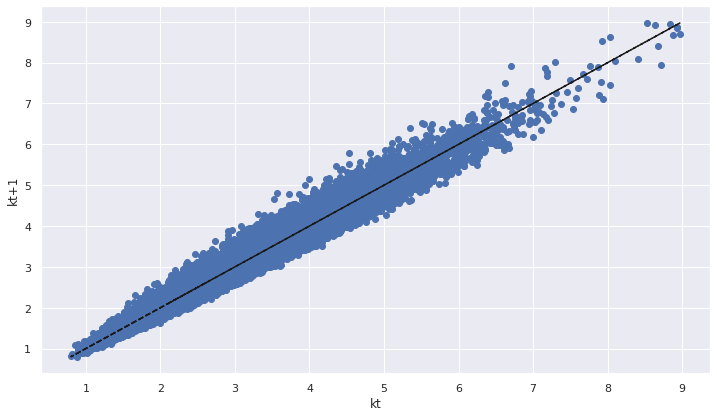

In [12]:
plt.scatter(k[:-1], k[1:])
plt.plot(k[1:], k[1:], linestyle="--", color = "k")
plt.ylabel("kt+1")
plt.xlabel("kt")
plt.savefig(output_folder + "kt_kt1.pdf", dpi=300)

  Variable      Mean    Median       Std       Min       Max
0        k  2.826346  2.686054  0.915489  0.802927  8.968995
1        a -0.001707 -0.002037  0.234826 -0.994568  0.941154


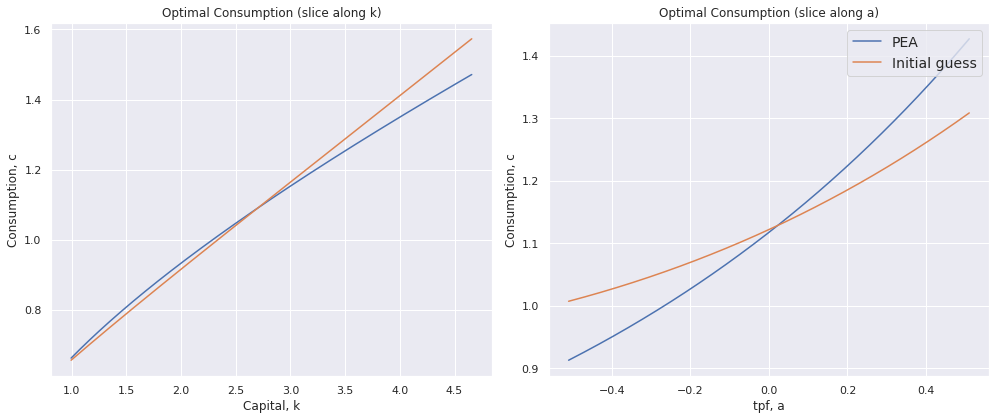

In [13]:
def summarize_k_a(k, a):
    """
    Compute basic summary statistics for two variables k and a.

    Parameters
    ----------
    k : array-like
        Numerical data for variable k.
    a : array-like
        Numerical data for variable a.

    Returns
    -------
    summary_df : pandas.DataFrame
        DataFrame with rows ['k','a'] and columns ['Mean','Median','Std','Min','Max'].
    """
    # ensure numpy arrays
    k = np.asarray(k)
    a = np.asarray(a)

    stats_dict = {
        'Variable': ['k', 'a'],
        'Mean'    : [k.mean(),      a.mean()],
        'Median'  : [np.median(k),  np.median(a)],
        'Std'     : [k.std(),       a.std()],
        'Min'     : [k.min(),       a.min()],
        'Max'     : [k.max(),       a.max()],
    }

    summary_df = pd.DataFrame(stats_dict)
    return summary_df
    
def plot_consumption_slices_non_binding(params,
                            mean_k, std_k,
                            a_ss, std_a,
                            b0, coeff_array_0,
                            cond_exp_chosen,
                            nb_stdev=2,
                            nb_points=500):
    """
    Plot optimal consumption slices along k and a. Model without constraint on investment.

    params: object with attributes
        - center_dep_var (bool)
        - normalize_dep_var (bool)
        - kss, std_k, std_a
        - alpha, delta, gamma, css, tol_c
        - nb_expl_vars (int), basis (int)
    mean_k, std_k: float
    a_ss, std_a: float
    b0, coeff_array_0: arrays of regression coefficients
    cond_exp_chosen: int (2, 5, 6, or 7)
    nb_stdev: number of standard deviations to plot around the mean
    nb_points: number of grid points per slice
    """
    # Create subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for i, var in enumerate(["k", "a"]):
        # build grids
        if var == "k":
            k_grid = np.linspace(mean_k - nb_stdev*std_k,
                                 mean_k + nb_stdev*std_k,
                                 nb_points)
            a_grid = a_ss * np.ones_like(k_grid)
        else:
            a_grid = np.linspace(a_ss - nb_stdev*std_a,
                                 a_ss + nb_stdev*std_a,
                                 nb_points)
            k_grid = mean_k * np.ones_like(a_grid)

        # transform explanatory variables
        if params.center_dep_var and params.normalize_dep_var:
            x1 = (k_grid - params.kss) / params.std_k
            x2 = a_grid / params.std_a
        elif params.center_dep_var and not params.normalize_dep_var:
            x1 = (k_grid - params.kss)
            x2 = a_grid
        else:
            x1 = np.log(k_grid)
            x2 = a_grid

        # construct design matrix X
        X = build_design_matrix(x1, x2, nb_expl_vars=params.nb_expl_vars, basis=params.basis)

        # cash-on-hand
        cash = np.exp(a_grid)*k_grid**params.alpha + (1 - params.delta)*k_grid

        # compute consumption and (if needed) k_next under different conditional expectations
        if cond_exp_chosen == 2:
            c_pea = params.css * np.maximum(1e-2, X.dot(b0))**(-1/params.gamma)
            c_pea = np.clip(c_pea, params.tol_c, cash - params.tol_c)
            c0 = params.css * np.maximum(1e-2, X.dot(coeff_array_0))**(-1/params.gamma)
            c0 = np.clip(c0, params.tol_c, cash - params.tol_c)

        elif cond_exp_chosen == 5:
            k_next = X.dot(b0)
            c_pea = np.maximum(cash - k_next, params.tol_c)
            c0 = np.maximum(cash - X.dot(coeff_array_0), params.tol_c)

        elif cond_exp_chosen == 6:
            c_pea = params.css * (1 + X.dot(b0))**(-1/params.gamma)
            c_pea = np.maximum(c_pea, params.tol_c)
            k_next = np.maximum(cash - c_pea, params.tol_c)

            c0 = params.css * (1 + X.dot(coeff_array_0))**(-1/params.gamma)
            c0 = np.maximum(c0, params.tol_c)

        elif cond_exp_chosen == 7:
            c_pea = np.exp(X.dot(b0))**(-1/params.gamma)
            c0 = np.exp(X.dot(coeff_array_0))**(-1/params.gamma)
            k_next = np.maximum(cash - c_pea, params.tol_c)

        else:
            raise NotImplementedError(f"cond_exp_chosen={cond_exp_chosen} not implemented")

        # plot
        grid = k_grid if var == "k" else a_grid
        xlabel = 'Capital, k' if var == "k" else 'tpf, a'
        axs[i].plot(grid, c_pea, label="PEA")
        axs[i].plot(grid, c0,   label="Initial guess")
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel('Consumption, c')
        axs[i].set_title(f'Optimal Consumption (slice along {var})')
        axs[i].grid(True)

    axs[1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

df_stats = summarize_k_a(k, a)
print(df_stats)

plot_consumption_slices_non_binding(
    params,
    mean_k=df_stats[df_stats["Variable"] == "k"]["Mean"].item(), 
    std_k=df_stats[df_stats["Variable"] == "k"]["Std"].item(),
    a_ss=0.0,   
    std_a=params.std_a,
    b0=b0, 
    coeff_array_0=coeff_array_0,
    cond_exp_chosen=7,
    nb_stdev=2,
    nb_points=500
)

### II.C. Solving model with irreversible investment constraints

#### II.C.1. Usual PEA



In [14]:
def dhm_accuracy_test(params, b0, e_test, init = 1000):
    """
    Compute the DHM accuracy test for a given set of parameters and an initial coefficient vector b0.

    Parameters:
    params: Instance containing model parameters (beta, delta, alpha, gamma, rho_tfp, std_tfp)
    b0: Coefficient vector used for the approximation.

    Returns:
    dict: Dictionary containing DHM test results.
    """
    # Simulation setup
    slong = len(e_test) #init + long
    long = slong - init
    if long <= 0:
        raise Exception(f"long is :{long}. Increase length of e_test, or decrease init") 

    T = np.arange(init, slong - 2)  # Select current period
    T1 = np.arange(init + 1, slong - 1) # Select period t+1. Drop last period, for which mu is not calculated

    # Generate shocks and AR(1) process for a
    a = np.zeros(slong)
    for i in range(1, slong):
        a[i] = params.rho_tfp * a[i - 1] + e_test[i]

    # Initialize variables
    k = np.zeros(slong + 1)
    mu =  np.zeros(slong + 1) #lagrange multiplier
    c = np.zeros(slong)
    production = np.zeros(slong)
    inv = np.zeros(slong) #investment
    cash = np.zeros(slong)
    X = np.zeros((slong, len(b0)))
    k[0] = params.kss  # Initial capital at steady state

          
    # Upper bound on E_t
    E_max = params.tol_c**(-params.gamma)            # ensures c >= tol_c

    # Simulate the economy
    for i in range(slong):
        if (params.center_dep_var == True) & (params.normalize_dep_var == True):
            x1 = (k[i] - params.kss)/params.std_k
            x2 = a[i]/params.std_a
        elif (params.center_dep_var == True) & (params.normalize_dep_var == False):
            x1 = (k[i] - params.kss)
            x2 = a[i]
        else:
            x1 = np.log(k[i])
            x2 = a[i]

        # Set values fo X:
        fill_X_row(X, i, x1, x2, params.nb_expl_vars, params.basis)

        production[i] = np.exp(a[i]) * k[i]**params.alpha
        cash[i] = production[i] + (1 - params.delta) * k[i]

        # Consumption, assuming current constraint on investment does not bind
        #E_t_tilde = np.clip(np.exp(np.dot(X[i, :], b0)), production[i]**(-params.gamma), E_max)    
        E_t_tilde = np.exp(np.dot(X[i, :], b0))
        c[i] = E_t_tilde ** (-1/params.gamma)
        
        # Update guess, after calculating investmen
        inv[i] = production[i] - c[i]
        if inv[i] > 0:
            k[i+1] = cash[i] - c[i]
        else:
            k[i+1] = (1 - params.delta) * k[i]
            c[i] = production[i]
            mu[i] = c[i]**( - params.gamma ) - E_t_tilde

    # Compute the error term
    ut = c[T]**(-params.gamma) - mu[T] - params.beta * ( ( c[T1]**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1] ** (params.alpha - 1) + 1 - params.delta) + mu[T1] * ( 1 - params.delta) )
    
    # Compute DHM statistics
    mean_ut = np.mean(ut)
    mean_abs_ut = np.mean(np.abs(ut))
    mean_square_ut = np.mean(ut**2)
    var_ut = np.var(ut, ddof=1)
    std_ut = np.sqrt(var_ut)
    T_sample = len(ut)
    dhm_stat = T_sample * (mean_ut ** 2) / var_ut

    # Chi-square critical values
    lower5 = chi2.ppf(0.05, df=1)
    upper5 = chi2.ppf(0.95, df=1)

    # Compute consumption equivalent
    mean_k = np.mean(k)
    a_ss = 0

    if (params.center_dep_var == True) & (params.normalize_dep_var == True):
        x1 = (mean_k - params.kss)/params.std_k
        x2 = a_ss/params.std_a
    elif (params.center_dep_var == True) & (params.normalize_dep_var == False):
        x1 = (mean_k - params.kss)
        x2 = a_ss
    else:
        x1 = np.log(mean_k)
        x2 = a_ss

    # Build X_ss
    X_ss = build_design_matrix(np.atleast_1d(x1), np.atleast_1d(x2), nb_expl_vars=params.nb_expl_vars, basis=params.basis)
    
    # Consumption at the non-stochastic ss:
    ## (assuming constraint does not bind):
    c_ss = np.exp(np.dot(X_ss, b0)) ** (-1/params.gamma)
        
    c_diff = (mean_ut + c_ss ** (-params.gamma)) ** (-1 / params.gamma)
    #c_diff = (mean_abs_ut + c_ss ** (-params.gamma)) ** (-1 / params.gamma)
    c_equivalent = 100 * (c_diff - c_ss) / c_ss

    return mean_abs_ut,  mean_square_ut, std_ut, dhm_stat, c_equivalent


def plot_consumption_slices(params,
                            mean_k, std_k,
                            a_ss, std_a,
                            b0, coeff_array_0,
                            cond_exp_chosen,
                            nb_stdev=2,
                            nb_points=500):
    """
    Plot optimal consumption slices along k and a. Model with constraint on investment.

    params: object with attributes
        - center_dep_var (bool)
        - normalize_dep_var (bool)
        - kss, std_k, std_a
        - alpha, delta, gamma, css, tol_c
        - nb_expl_vars (int), basis (int)
    mean_k, std_k: float
    a_ss, std_a: float
    b0, coeff_array_0: arrays of regression coefficients
    cond_exp_chosen: int (2, 5, 6, or 7)
    nb_stdev: number of standard deviations to plot around the mean
    nb_points: number of grid points per slice
    """
    if cond_exp_chosen != 7:
        raise NotImplementedError(f"cond_exp_chosen={cond_exp_chosen} not implemented")
        
    # Create subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for i, var in enumerate(["k", "a"]):
        # build grids
        if var == "k":
            k_grid = np.linspace(mean_k - nb_stdev*std_k,
                                 mean_k + nb_stdev*std_k,
                                 nb_points)
            a_grid = a_ss * np.ones_like(k_grid)
        else:
            a_grid = np.linspace(a_ss - nb_stdev*std_a,
                                 a_ss + nb_stdev*std_a,
                                 nb_points)
            k_grid = mean_k * np.ones_like(a_grid)

        # transform explanatory variables
        if params.center_dep_var and params.normalize_dep_var:
            x1 = (k_grid - params.kss) / params.std_k
            x2 = a_grid / params.std_a
        elif params.center_dep_var and not params.normalize_dep_var:
            x1 = (k_grid - params.kss)
            x2 = a_grid
        else:
            x1 = np.log(k_grid)
            x2 = a_grid

        # construct design matrix X
        X = build_design_matrix(x1, x2, nb_expl_vars=params.nb_expl_vars, basis=params.basis)
        
        # producton
        production = np.exp(a_grid)*k_grid**params.alpha
        # cash-on-hand
        cash = production + (1 - params.delta)*k_grid

        # Consumption, assuming current constraint on investment does not bind:
        ## With b0
        E_pea = np.exp(X.dot(b0))
        c_pea = E_pea**(-1/params.gamma)
        
        # Update guess, after calculating investment
        inv = production - c_pea

        k_next = np.where(inv > 0, cash - c_pea, (1 - params.delta) * k_grid)
        c_pea = np.where(inv > 0, c_pea,  production)
        mu = np.where(inv > 0, 0.0,  c_pea ** ( - params.gamma ) - E_pea)
        
        ## With 
        E_0 = np.exp(X.dot(coeff_array_0))
        c_0 = E_0**(-1/params.gamma)

        inv_0 = production - c_0
        k_next_0 = np.where(inv_0 > 0, cash - c_0, (1 - params.delta) * k_grid)
        c_0 = np.where(inv_0 > 0, c_0,  production)
        mu_0 = np.where(inv_0 > 0, 0.0,  c_0 ** ( - params.gamma ) - E_0)
        
            
        # plot
        grid = k_grid if var == "k" else a_grid
        xlabel = 'Capital, k' if var == "k" else 'tpf, a'
        axs[i].plot(grid, c_pea, label="PEA")
        axs[i].plot(grid, c_0,   label="Initial guess")
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel('Consumption, c')
        axs[i].set_title(f'Optimal Consumption (slice along {var})')
        axs[i].grid(True)

    axs[1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()




State vector draws: 1000
Intial b0: [ 0.22788678 -0.40609072 -0.44499522  0.18392413 -0.09662209 -0.09436849
 -0.00097479  0.00092188 -0.01028892  0.00586437]
Iteration: 10	Conv. crit.: 0.007921635103085745	 b: [-1.19781629  1.01713906 -1.40350125  0.88756386 -0.78123444 -0.64611013
  0.06404785 -0.0195162  -0.43940955  0.62188822]
Iteration: 20	Conv. crit.: 5.2994746070900156e-05	 b: [-1.19647619  1.01396635 -1.39914929  0.88086583 -0.78370562 -0.64256492
  0.06440087 -0.0202923  -0.43751333  0.61710262]


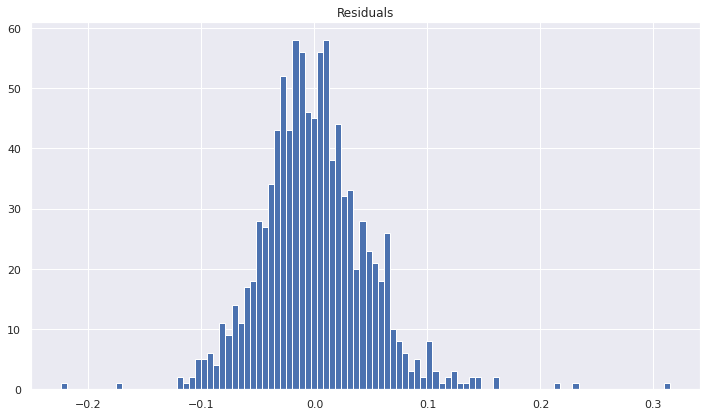

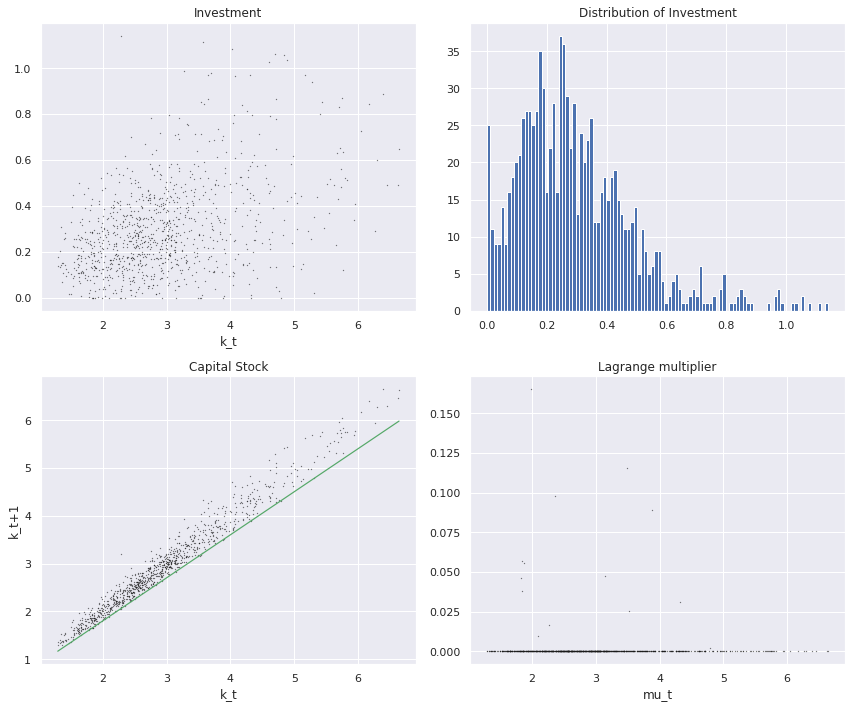

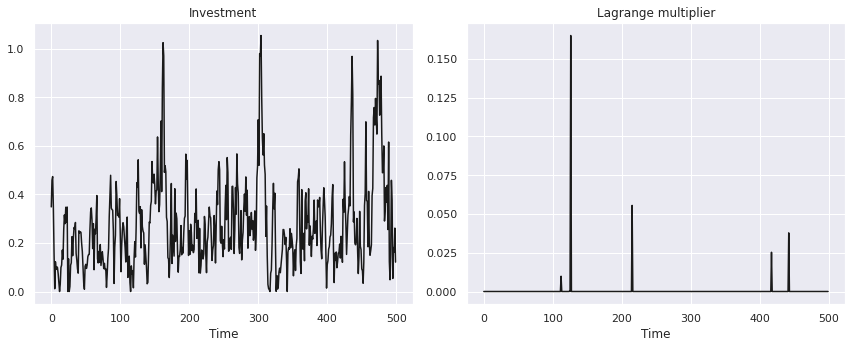

Percentage of time negative investment: 0.0
Percentage mu binds: 0.01634877384196185


/tmp/ipykernel_12246/4169438773.py:61: RuntimeWarning: overflow encountered in scalar power
  c[i] = E_t_tilde ** (-1/params.gamma)
/tmp/ipykernel_12246/4169438773.py:61: RuntimeWarning: divide by zero encountered in scalar power
  c[i] = E_t_tilde ** (-1/params.gamma)
/tmp/ipykernel_12246/4169438773.py:73: RuntimeWarning: overflow encountered in multiply
  ut = c[T]**(-params.gamma) - mu[T] - params.beta * ( ( c[T1]**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1] ** (params.alpha - 1) + 1 - params.delta) + mu[T1] * ( 1 - params.delta) )
/home/julien/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_12246/4169438773.py:78: RuntimeWarning: overflow encountered in square
  mean_square_ut = np.mean(ut**2)
/home/julien/.local/lib/python3.8/site-packages/numpy/core/_methods.py:215: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_s

Mean abs ut: inf, Mean square ut: inf. DHM stats: nan. C equivalent: [-100.]
  Variable      Mean    Median       Std       Min       Max
0        k  2.895276  2.747877  0.953410  1.294705  6.644010
1        a  0.013112  0.007503  0.233225 -0.659612  0.750717


<Figure size 864x486 with 0 Axes>

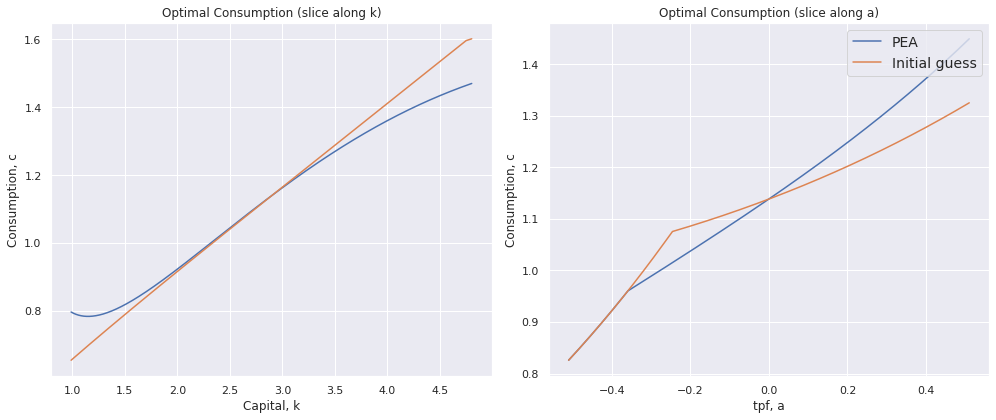

State vector draws: 10000
Intial b0: [ 0.22788678 -0.40609072 -0.44499522  0.18392413 -0.09662209 -0.09436849
 -0.00097479  0.00092188 -0.01028892  0.00586437]
Iteration: 10	Conv. crit.: 0.0005912537384994421	 b: [-0.05851124 -0.05919487 -0.98210824  0.43408431 -0.13455197 -0.30708272
  0.01049144 -0.03551359 -0.19488435  0.28722002]
Iteration: 20	Conv. crit.: 1.0570734320647368e-05	 b: [-0.05783706 -0.05870535 -0.98174243  0.43434295 -0.13380141 -0.30738127
  0.01044842 -0.03562206 -0.19475083  0.28846176]


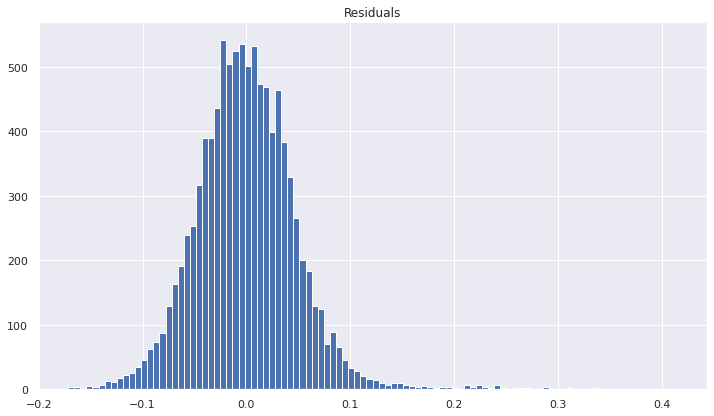

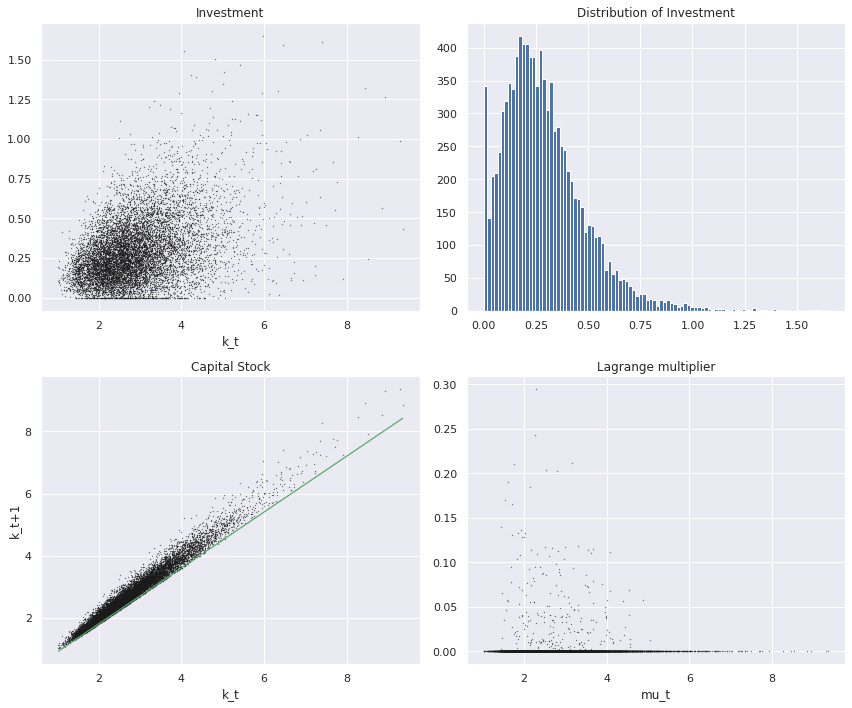

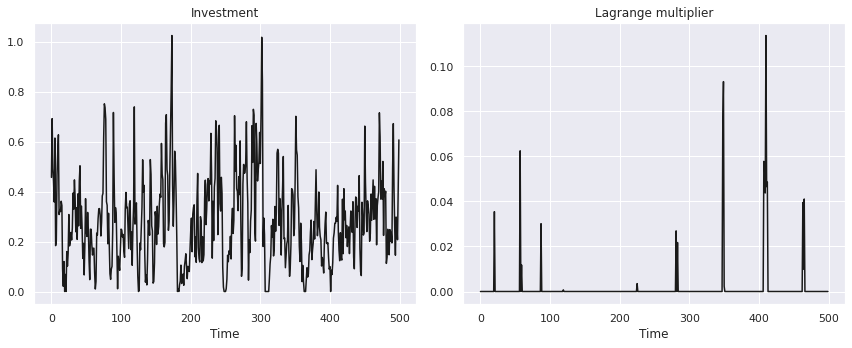

Percentage of time negative investment: 0.0
Percentage mu binds: 0.024156024156024157
Mean abs ut: 0.034752825498379165, Mean square ut: 0.0025180261667476444. DHM stats: 65.1325002862566. C equivalent: [0.10258416]
  Variable      Mean   Median       Std       Min       Max
0        k  2.883454  2.72922  0.940947  1.025664  9.356213
1        a -0.000047  0.00118  0.233628 -0.850505  0.859554


<Figure size 864x486 with 0 Axes>

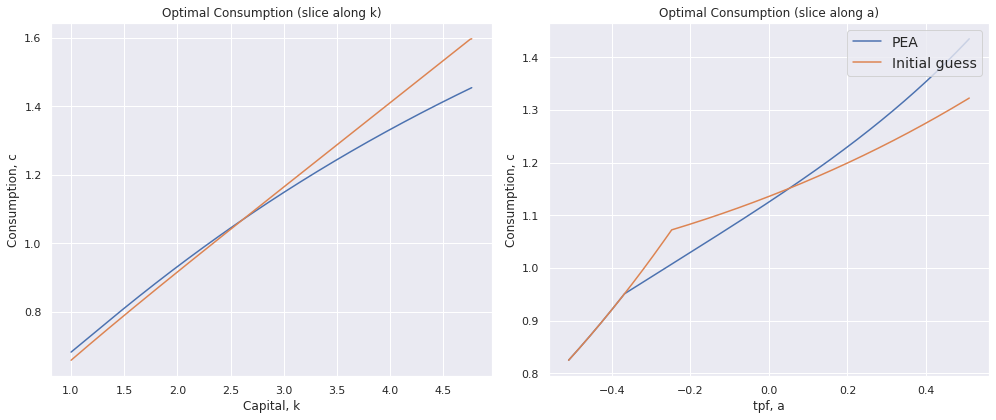

State vector draws: 50000
Intial b0: [ 0.22788678 -0.40609072 -0.44499522  0.18392413 -0.09662209 -0.09436849
 -0.00097479  0.00092188 -0.01028892  0.00586437]
Iteration: 10	Conv. crit.: 0.0005094872446426701	 b: [ 0.01780093 -0.12215715 -0.91721967  0.36429567 -0.09852684 -0.28404336
  0.00794635 -0.03657454 -0.15911881  0.27629202]
Iteration: 20	Conv. crit.: 8.815634251146953e-06	 b: [ 0.01806802 -0.12145247 -0.91759553  0.36511735 -0.09801837 -0.28434045
  0.00791376 -0.03674445 -0.1593414   0.27734233]


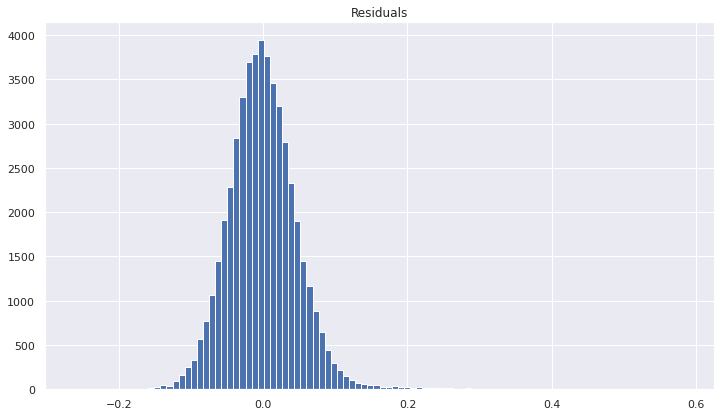

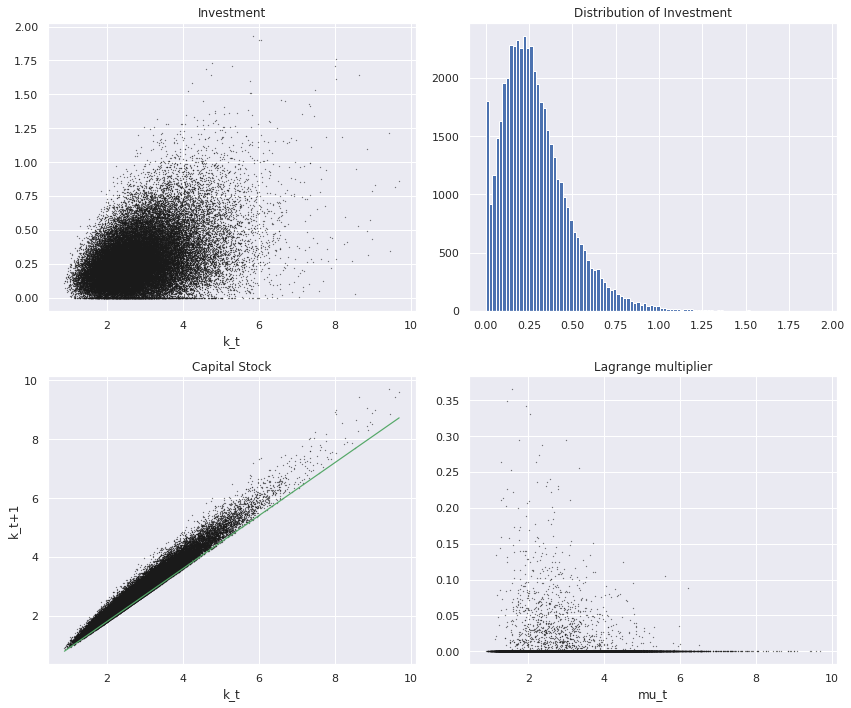

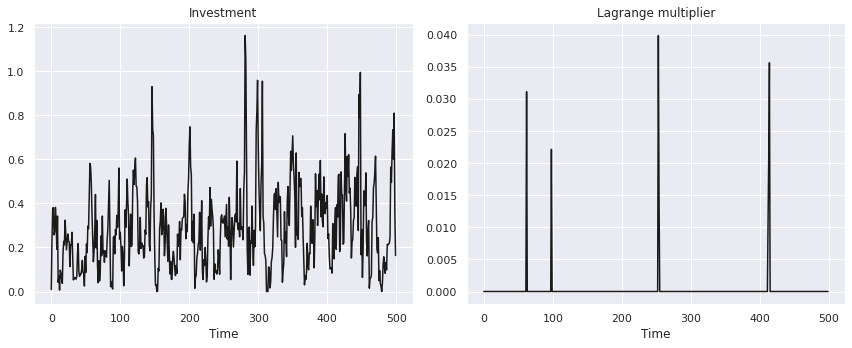

Percentage of time negative investment: 0.0
Percentage mu binds: 0.022554440031137102
Mean abs ut: 0.034672457484139, Mean square ut: 0.002478157912090124. DHM stats: 40.851257863824024. C equivalent: [0.08067412]
  Variable      Mean    Median       Std       Min       Max
0        k  2.865501  2.729598  0.926175  0.882556  9.695930
1        a -0.002814 -0.000759  0.234760 -0.997354  0.944257


<Figure size 864x486 with 0 Axes>

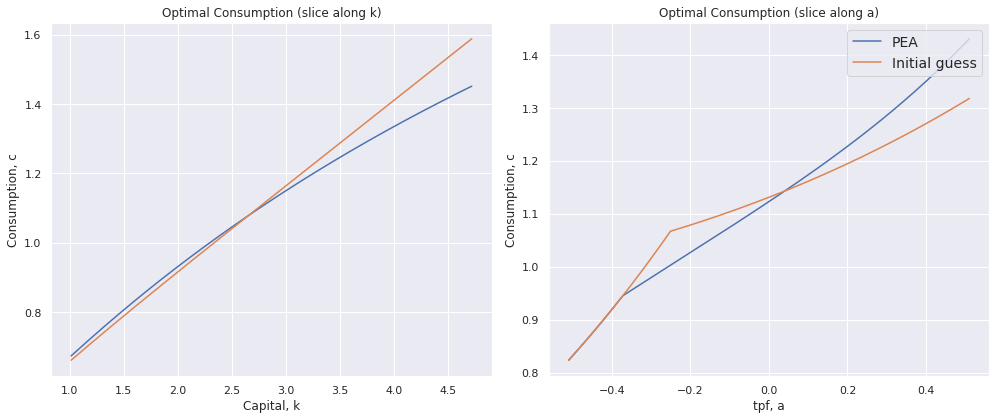

State vector draws: 100000
Intial b0: [ 0.22788678 -0.40609072 -0.44499522  0.18392413 -0.09662209 -0.09436849
 -0.00097479  0.00092188 -0.01028892  0.00586437]
Iteration: 10	Conv. crit.: 0.0005126703263358956	 b: [-0.04438148 -0.07191398 -0.96705851  0.40414746 -0.11464977 -0.32457052
  0.00923071 -0.04087254 -0.18101153  0.30500978]
Iteration: 20	Conv. crit.: 9.208221915080195e-06	 b: [-0.04397401 -0.07120826 -0.96706404  0.40479217 -0.11415297 -0.32476055
  0.00920059 -0.04098421 -0.18109936  0.30608491]


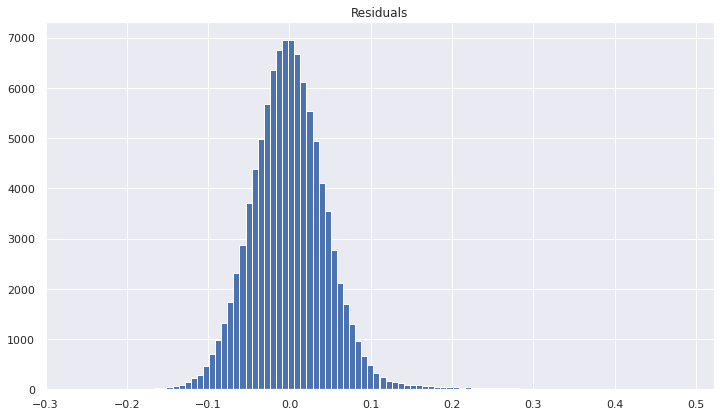

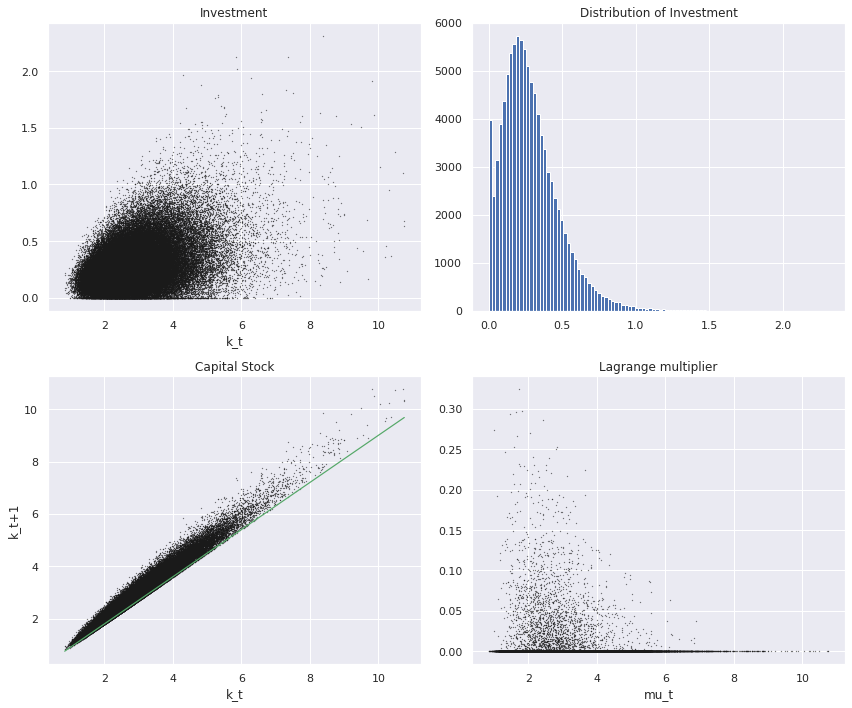

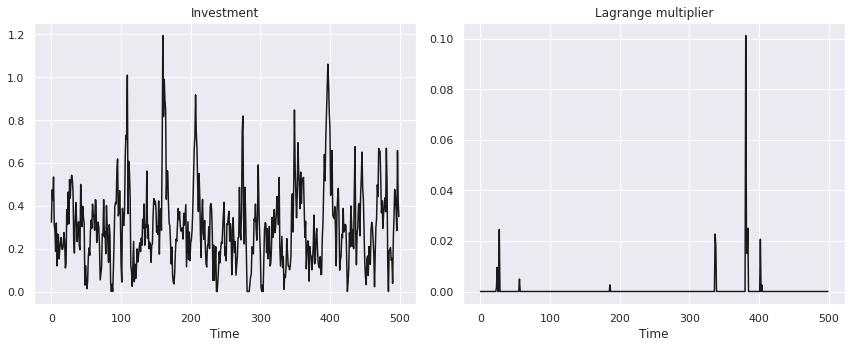

Percentage of time negative investment: 0.0
Percentage mu binds: 0.022717055773668594
Mean abs ut: 0.03456855867021427, Mean square ut: 0.0024790363801255066. DHM stats: 46.97341066752621. C equivalent: [0.08647405]
  Variable      Mean    Median       Std       Min        Max
0        k  2.863046  2.716079  0.938871  0.840801  10.756492
1        a -0.003828 -0.004028  0.233800 -1.003802   1.034407


<Figure size 864x486 with 0 Axes>

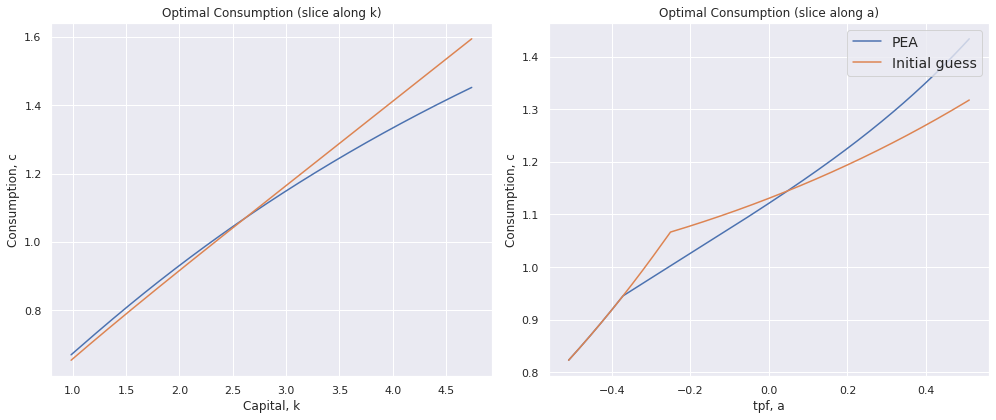

    k       M  N   DHM_stat           C_equivalent       MSE
0  10    1000  1        NaN               [-100.0]  0.002216
1  10   10000  1  65.132500  [0.10258416460110883]  0.002476
2  10   50000  1  40.851258   [0.0806741180208259]  0.002428
3  10  100000  1  46.973411  [0.08647405172159174]  0.002400


In [15]:
# --- Nice typography without requiring a LaTeX install ---
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times']
mpl.rcParams['mathtext.fontset'] = 'stix'   # math font close to Time

# Usual PEA
tol = 1e-6
gam = 1.0
init = 100 #burnin

results_standard_PEA = []
slong_test = 200000
e_test = params.std_tfp * np.random.randn(slong_test)

max_iter = 30

# Try for different number of state draws:
for long in [1000, 10000, 50000, 100000]:
    slong = init + long
    print(f"State vector draws: {long}")
    
    # SS value. Use mean values on the simulation
    k_ss = SS_values[SS_values["Variable"] == "k"]["MeanValue"].item()
    a_ss = 0
    c_ss = SS_values[SS_values["Variable"] == "c"]["MeanValue"].item()

    # To ensure consumption is a least tol_c
    E_max = params.tol_c**(-params.gamma)
    
    # Also, define the index arrays T and T1
    T = np.arange(init, slong-2) # current period
    T1 = np.arange(init+1, slong-1) # forward by one period. Drop last period, for which mu is not calculated
    
    # Compute initial conditions:
    print(f"Intial b0: {coeff_array_0}")
    b0 = coeff_array_0.copy()
    
    # Generate shocks: e is a vector of size slong with normally distributed shocks scaled by se
    e = params.std_tfp * np.random.randn(slong)
    
    # Initialize a as a vector of zeros
    a = np.zeros(slong)
    
    # Set the first element of a
    a[0] = a_ss
    
    # Generate the AR(1) process for a
    for i in range(1, slong):
        a[i] = params.rho_tfp * a[i-1] + e[i]
    
    # Initialize iteration counter and convergence criterion
    iteration = 1
    crit = np.inf  # set to a large number initially
    
    #while crit > tol:
    while iteration < max_iter :
        k = np.zeros(slong + 1)
        c = np.zeros(slong)
        inv = np.zeros(slong)
        production = np.zeros(slong)
        X = np.zeros((slong, len(b0)))
        cash = np.zeros(slong)
        mu = np.zeros(slong + 1) #Lagrange multiplier
        
        # Set initial capital:
        k[0] = k_ss
    
        # Simulate the path:
        for i in range(slong):
            # Construct the regressors at time i.
            if (params.center_dep_var == True) & (params.normalize_dep_var == True):
                x1 = (k[i] - params.kss)/params.std_k
                x2 = a[i]/params.std_a
            elif (params.center_dep_var == True) & (params.normalize_dep_var == False):
                x1 = (k[i] - params.kss)
                x2 = a[i]
            else:
                x1 = np.log(k[i])
                x2 = a[i]

            fill_X_row(X, i, x1, x2, params.nb_expl_vars, params.basis)
            
            # Ouptut
            production[i] = np.exp(a[i]) * (k[i]**params.alpha)
            # Cash on hand: production + capital from last period
            cash[i] =  production[i] + (1 - params.delta) * k[i]
    
            # Update capital for the next period using the model's law of motion
            # Consumption, assuming current constraint on investment does not bind
            if cond_exp_chosen == 7:
                #E_t_tilde = np.clip(np.exp(np.dot(X[i, :], b0)), production[i]**(-params.gamma), E_max)  
                E_t_tilde = np.exp(np.dot(X[i, :], b0))
                c[i] = E_t_tilde ** (-1/params.gamma)
            else:
                print(f"cond_exp_chosen : {cond_exp_chosen} not implemented yet)")
    
            # Update guess, after calculating investmen
            inv[i] = production[i] - c[i]
            if inv[i] > 0:
                k[i+1] = cash[i] - c[i]
            else:
                k[i+1] = (1 - params.delta) * k[i]
                c[i] = production[i]
                mu[i] = c[i]**( - params.gamma ) - E_t_tilde
    
        # Construct the vector y using the simulated paths (vectorized operation)
        if cond_exp_chosen == 7:
            y = np.log(params.beta * ( ( c[T1]**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1] ** (params.alpha - 1) + 1 - params.delta) + mu[T1] * ( 1 - params.delta) ) )

        # Solve the regression: log(y) = X(T,:) * bt in a least-squares sense.
        # np.linalg.lstsq returns a tuple; the first element is the solution.
        y_reg = y
        X_reg = X[T, :]
        bt, _, _, _ = np.linalg.lstsq(X_reg, y_reg, rcond=None)

        if params.regression_two_steps == True:
            #print(f"Step 1 coef: {bt}")
            # Square root of weights, when using log model
            sqrt_w = np.exp(X_reg @ bt)
            # Pre-multiply and then regress again
            X_wls = X_reg * sqrt_w[:, None]
            y_wls = y_reg * sqrt_w
            bt, _, _, _ = np.linalg.lstsq(X_wls, y_wls, rcond=None)
            #print(f"Step 2 coef: {bt}")
        elif params.feasible_GLS == True:
            print(f"Step 1 coef: {bt}")
            ## residuals
            e0 = y_reg - X_reg @ bt
            # Estimate the variance‐function via a log‐linear model
            # use X_reg as Z, but you can build a richer Z = f(state)
            Z = X_reg
            # add tiny constant to avoid log(0)
            log_u = np.log(e0**2 + 1e-12)                    
            gamma, *_ = np.linalg.lstsq(Z, log_u, rcond=None)
            # fitted log‐variance and variance estimate
            log_var_hat = Z @ gamma          
            var_hat     = np.exp(log_var_hat) 
            # Construct inverse‐variance weights and do WLS
            w       = 1.0 / var_hat        
            sqrt_w  = np.sqrt(w)
            # Pre-multiply and then regress again
            X_wls = X_reg * sqrt_w[:, None]
            y_wls = y_reg * sqrt_w
            bt, _, _, _ = np.linalg.lstsq(X_wls, y_wls, rcond=None)
            print(f"Step 2 coef FGLS: {bt}")
    
        # Update b using a smoothing parameter gam:
        b = gam * bt + (1 - gam) * b0
    
        # Compute convergence criterion (maximum absolute change in b)
        crit = np.max(np.abs(b - b0))
    
        # Update b0 for the next iteration
        b0 = b.copy()
    
        # Display current iteration and convergence criterion
        if (iteration % 10 == 0):
            print(f"Iteration: {iteration}\tConv. crit.: {crit}\t b: {b}")
    
        iteration += 1
    
    # residual
    Res = y_reg - np.dot(X[T, :], b0)
    MSE = np.mean(Res ** 2)
    
    # =============================================================================
    # Plotting results
    # =============================================================================
    # 1. Plot histogram of residuals
    plt.figure()
    plt.hist(Res, bins=100)
    plt.title('Residuals', fontname='Times', fontsize=12)
    
    # 2. Compute investment deviations: it = k[T1] - (1-delta)*k[T]
    it = k[T1] - (1 - params.delta) * k[T]
    
    # Create a 2x2 figure for several plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Investment scatter plot
    axs[0, 0].plot(k[T], it, '.', markersize=0.5, color='k')
    axs[0, 0].set_xlabel('k_t', fontname='Times', fontsize=12)
    axs[0, 0].set_title('Investment', fontname='Times', fontsize=12)
    
    # Histogram of investment
    axs[0, 1].hist(it, bins=100)
    axs[0, 1].set_title('Distribution of Investment', fontname='Times', fontsize=12)
    
    # Capital stock: plot k[T] vs. k[T1] and add 45° reference line (scaled by (1-delta))
    axs[1, 0].plot(k[T], k[T1], '.', markersize=0.5, color='k')
    x_line = np.linspace(np.min(k[T]), np.max(k[T]), 100)
    axs[1, 0].plot(x_line, (1 - params.delta) * x_line, '-', linewidth=1.2, color='g')
    axs[1, 0].set_xlabel('k_t', fontname='Times', fontsize=12)
    axs[1, 0].set_ylabel('k_t+1', fontname='Times', fontsize=12)
    axs[1, 0].set_title('Capital Stock', fontname='Times', fontsize=12)
    
    # Lagrange multiplier
    axs[1, 1].plot(k[T], mu[T], '.', markersize=0.5, color='k')
    axs[1, 1].set_xlabel('k_t', fontname='Times', fontsize=12)
    axs[1, 1].set_xlabel('mu_t', fontname='Times', fontsize=12)
    axs[1, 1].set_title('Lagrange multiplier', fontname='Times', fontsize=12)
    
    plt.tight_layout()
    
    # 3. Time series plots for a subset
    T0 = np.arange(100, 600)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(it[T0], 'k')
    axs[0].set_xlabel('Time', fontname='Times', fontsize=12)
    axs[0].set_title('Investment', fontname='Times', fontsize=12)
    
    axs[1].plot(mu[T0], 'k')
    axs[1].set_xlabel('Time', fontname='Times', fontsize=12)
    axs[1].set_title('Lagrange multiplier', fontname='Times', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(output_folder + "example_simlation_binding.pdf", dpi=300)
    
    percentage_negative_investment = len(it[it < 0])/len(it)
    print(f"Percentage of time negative investment: {percentage_negative_investment}")
    
    percentage_mu_binds = len(mu[mu > 0])/len(mu)
    print(f"Percentage mu binds: {percentage_mu_binds}")
    
    mean_abs_ut, mean_square_ut, std_ut, dhm_stat, c_equivalent = dhm_accuracy_test(params, b0, e_test)
    print(f"Mean abs ut: {mean_abs_ut}, Mean square ut: {mean_square_ut}. DHM stats: {dhm_stat}. C equivalent: {c_equivalent}")

    # Store the results in a dictionary
    results_standard_PEA.append({
        "k": params.nb_expl_vars,
        "M": long,
        "N": 1,
        "DHM_stat": dhm_stat,
        "C_equivalent": c_equivalent,
        "MSE": MSE})
    
    # Summary stats on k_t
    df_stats = summarize_k_a(k, a)
    print(df_stats)

    # Slices around ss
    plot_consumption_slices(
                params,
                mean_k=df_stats[df_stats["Variable"] == "k"]["Mean"].item(), 
                std_k=df_stats[df_stats["Variable"] == "k"]["Std"].item(),
                a_ss=0.0,   
                std_a=params.std_a,
                b0=b0, 
                coeff_array_0=coeff_array_0,
                cond_exp_chosen=7,
                nb_stdev=2,
                nb_points=1000)

# Create a Pandas DataFrame from the results
df_results_standard_PEA_M = pd.DataFrame(results_standard_PEA)
df_results_standard_PEA_M.to_csv(output_folder + "df_results_standard_PEA_M.csv")
print(df_results_standard_PEA_M.head())


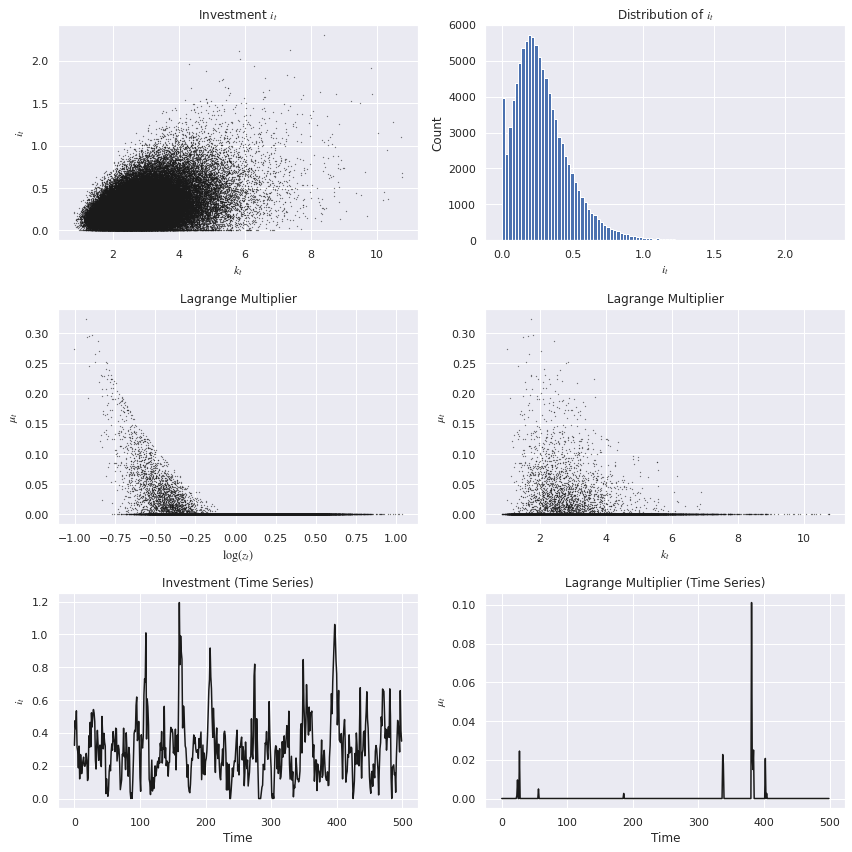

In [16]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times']
mpl.rcParams['mathtext.fontset'] = 'stix'   # math close to Times

# Indices for time-series panels
T0 = np.arange(100, 600)

# Build a 3×2 figure
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
(ax_a, ax_b), (ax_c, ax_d), (ax_e, ax_f) = axs

# (1) Investment scatter: i_t vs k_t
ax_a.plot(k[T], it, '.', markersize=0.5, color='k', rasterized=True)
ax_a.set_xlabel(r'$k_t$', fontsize=12)
ax_a.set_ylabel(r'$i_t$', fontsize=12)
ax_a.set_title('Investment $i_t$', fontsize=12)

# (2) Histogram of i_t
ax_b.hist(it, bins=100)
ax_b.set_xlabel(r'$i_t$', fontsize=12)
ax_b.set_ylabel('Count', fontsize=12)
ax_b.set_title(r'Distribution of $i_t$', fontsize=12)

# (3) Capital stock: k_{t+1} vs k_t with reference line (1-δ)k_t
"""
ax_c.plot(k[T], k[T1], '.', markersize=0.5, color='k')
x_line = np.linspace(np.min(k[T]), np.max(k[T]), 200)
ax_c.plot(x_line, (1 - params.delta) * x_line, '-', linewidth=1.2, color='g',
          label=rf'$(1-\delta)\,k_t$')
ax_c.set_xlabel(r'$k_t$', fontsize=12)
ax_c.set_ylabel(r'$k_{t+1}$', fontsize=12)
ax_c.set_title('Capital Stock', fontsize=12)
ax_c.legend(frameon=False, fontsize=10)
"""
# (3) Lagrange multiplier: μ_t vs k_t
ax_c.plot(a[T], mu[T], '.', markersize=0.5, color='k', rasterized=True)
ax_c.set_xlabel(r'$\log(z_t)$', fontsize=12)
ax_c.set_ylabel(r'$\mu_t$', fontsize=12)
ax_c.set_title('Lagrange Multiplier', fontsize=12)

# (4) Lagrange multiplier: μ_t vs k_t
ax_d.plot(k[T], mu[T], '.', markersize=0.5, color='k', rasterized=True)
ax_d.set_xlabel(r'$k_t$', fontsize=12)
ax_d.set_ylabel(r'$\mu_t$', fontsize=12)
ax_d.set_title('Lagrange Multiplier', fontsize=12)

# (5) Time series of i_t over T0
ax_e.plot(it[T0], 'k')
ax_e.set_xlabel('Time', fontsize=12)
ax_e.set_ylabel(r'$i_t$', fontsize=12)
ax_e.set_title('Investment (Time Series)', fontsize=12)

# (6) Time series of μ_t over T0
ax_f.plot(mu[T0], 'k')
ax_f.set_xlabel('Time', fontsize=12)
ax_f.set_ylabel(r'$\mu_t$', fontsize=12)
ax_f.set_title('Lagrange Multiplier (Time Series)', fontsize=12)

plt.tight_layout()
plt.savefig(output_folder + "example_simlation_binding_3x2.pdf", dpi=300)
plt.savefig(output_folder + "example_simlation_binding_3x2.png", dpi=300, bbox_inches='tight')
plt.show()

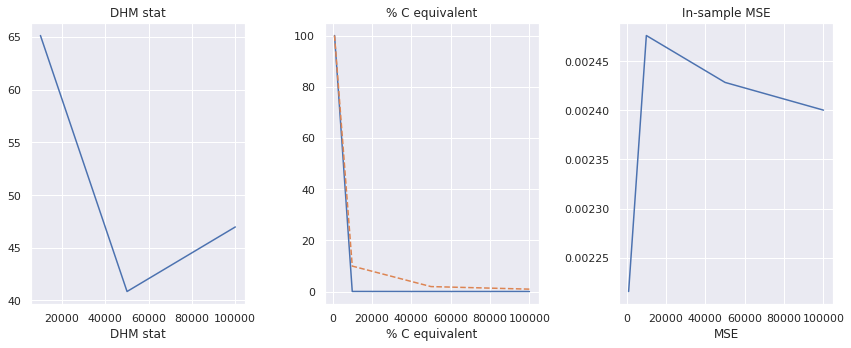

In [17]:
list_M = df_results_standard_PEA_M["M"]
ref_index_plot = 0

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].plot(list_M, df_results_standard_PEA_M["DHM_stat"])
axs[0].plot(list_M, df_results_standard_PEA_M["DHM_stat"][ref_index_plot]*(list_M[ref_index_plot]/list_M), linestyle='--', label='1/N decay')
axs[0].set_xlabel('DHM stat', fontname='Times', fontsize=12)
axs[0].set_title('DHM stat', fontname='Times', fontsize=12)

axs[1].plot(list_M, np.abs(df_results_standard_PEA_M["C_equivalent"]))
axs[1].plot(list_M, np.abs(df_results_standard_PEA_M["C_equivalent"])[ref_index_plot]*(list_M[ref_index_plot]/list_M), linestyle='--', label='1/N decay')
axs[1].set_xlabel('% C equivalent', fontname='Times', fontsize=12)
axs[1].set_title('% C equivalent', fontname='Times', fontsize=12)

axs[2].plot(df_results_standard_PEA_M["M"], np.abs(df_results_standard_PEA_M["MSE"]))
#axs[2].plot(list_M, np.abs(df_results_standard_PEA_M["MSE"])[ref_index_plot]*(list_M[ref_index_plot]/list_M), linestyle='--', label='1/N decay')
axs[2].set_xlabel('MSE', fontname='Times', fontsize=12)
axs[2].set_title('In-sample MSE', fontname='Times', fontsize=12)


plt.tight_layout()
plt.show()

#### II.C.2 bc-MC-PEA

Use several innovation draws per state vector

In [18]:
@njit
def generate_random_innovations(slong, N, std):
    """
    Generate 1d innovatio N(0, std^2)
    """
    e = np.empty(slong)
    for i in range(slong):
        e[i] = std * np.random.randn()
    return e

@njit
def generate_random_arrays(slong, N, std):
    """
    Generate 1d innovation N(0, std^2) and random array, where each row is N(0, std^2).
    """
    e = np.empty(slong)
    E = np.empty((slong, N))
    for i in range(slong):
        e[i] = std * np.random.randn()
        for j in range(N):
            E[i, j] = std * np.random.randn()
    return e, E


def create_plots(list_N, MSE_N, Time_N, mean_square_ut_N, dhm_stat_N, c_equivalent_N, label = "N", ref_index_plot=0):
    """
    Creates two sets of plots:

    1. A figure with two subplots:
       - Left: MSE vs. N, along with 1/N and 1/sqrt(N) decay lines.
       - Right: Elapsed Time vs. N, along with 1*N and 1*sqrt(N) increase lines.

    2. A second figure with four subplots (2x2 grid):
       - Top-left: Mean (ut)^2 vs. N with a 1/sqrt(N) decay line.
       - Top-right: DHM Stats vs. N with a 1/sqrt(N) decay line.
       - Bottom-left: % C equivalent vs. N with a 1/sqrt(N) decay line.
       - Bottom-right: In sample MSE vs. N with a 1/N decay line.

    Parameters:
        list_N         : array-like, values of N (Number of Innovation Draws)
        MSE_N          : array-like, Mean Squared Error for each N
        Time_N         : array-like, elapsed time (seconds) for each N
        mean_square_ut_N: array-like, mean (ut)^2 for each N
        dhm_stat_N     : array-like, DHM statistic for each N
        c_equivalent_N : array-like, % C equivalent for each N
        ref_index_plot : int, reference index for plotting the decay/increase lines (default 0)
    """
    list_N = np.array(list_N)  # ensure numpy array for elementwise operations

    # -----------------------
    # Figure 1: Two subplots side-by-side.
    fig1, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Left panel: MSE vs. N.
    axs[0].plot(list_N, MSE_N, marker='o', linestyle='-', label='MSE')
    axs[0].plot(list_N, MSE_N[ref_index_plot] * (list_N[ref_index_plot] / list_N),
                marker='o', linestyle='--', label='1/N decay')
    axs[0].plot(list_N, MSE_N[ref_index_plot] * np.sqrt(list_N[ref_index_plot] / list_N),
                marker='o', linestyle='--', label='1/sqrt(N) decay')
    axs[0].set_xlabel(label)
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].set_title(f'MSE vs. {label}')
    axs[0].grid(True)
    axs[0].legend()

    # Right panel: Elapsed Time vs. N.
    axs[1].plot(list_N, Time_N, marker='o', linestyle='-', color='orange', label='Elapsed Time (s)')
    #axs[1].plot(list_N, Time_N[ref_index_plot] * (list_N / list_N[ref_index_plot]),
    #            marker='o', linestyle='--', label='1*N increase')
    #axs[1].plot(list_N, Time_N[ref_index_plot] * np.sqrt(list_N / list_N[ref_index_plot]),
    #            marker='o', linestyle='--', label='1*sqrt(N) increase')
    axs[1].set_xlabel('label')
    axs[1].set_ylabel('Elapsed Time (seconds)')
    axs[1].set_title(f'Elapsed Time vs. {label}')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # -----------------------
    # Figure 2: Four subplots in a 2x2 grid.
    fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 5))

    # Top-left: Mean (ut)^2 vs. N.
    ax1.plot(list_N, mean_square_ut_N, marker='o', linestyle='-')
    ax1.plot(list_N, mean_square_ut_N[ref_index_plot] * np.power(list_N[ref_index_plot] / list_N, 0.5),
             marker='o', linestyle='--', label='1/sqrt(N) decay')
    ax1.set_xlabel(label)
    ax1.set_ylabel('Mean (ut)^2')
    ax1.set_title('Mean (ut)^2')
    ax1.grid(True)
    ax1.legend()

    # Top-right: DHM Stats vs. N.
    ax2.plot(list_N, dhm_stat_N, marker='o', linestyle='-', color='orange')
    ax2.plot(list_N, dhm_stat_N[ref_index_plot] * np.sqrt(list_N[ref_index_plot] / list_N),
             marker='o', linestyle='--', label='1/sqrt(N) decay')
    ax2.set_xlabel(label)
    ax2.set_ylabel('DHM Stats')
    ax2.set_title('DHM Stats')
    ax2.grid(True)
    ax2.legend()

    # Bottom-left: % C equivalent vs. N.
    ax3.plot(list_N, c_equivalent_N, marker='o', linestyle='-', color='orange')
    ax3.plot(list_N, c_equivalent_N[ref_index_plot] * np.sqrt(list_N[ref_index_plot] / list_N),
             marker='o', linestyle='--', label='1/sqrt(N) decay')
    ax3.set_xlabel(label)
    ax3.set_ylabel('% C equivalent')
    ax3.set_title('% C equivalent')
    ax3.grid(True)
    ax3.legend()

    # Bottom-right: In sample MSE vs. N.
    ax4.plot(list_N, MSE_N, marker='o', linestyle='-', label='In sample MSE')
    ax4.plot(list_N, MSE_N[ref_index_plot] * (list_N[ref_index_plot] / list_N),
             marker='o', linestyle='--', label='1/N decay')
    ax4.set_xlabel(label)
    ax4.set_ylabel('% In sample MSE')
    ax4.set_title('% In sample MSE')
    ax4.grid(True)
    ax4.legend()

    plt.tight_layout()
    plt.show()

In [19]:
@njit
def clamp(arr, low, high):
    """
    Element-wise clamp of `arr` between `low` and `high`.
    Equivalent to np.clip(arr, low, high). np.clip has trouble with jit compilation.
    """
    return np.minimum(np.maximum(arr, low), high)


@njit
def fill_X_next(Xv, x1, x2, nb_expl_vars, basis):
    """
    In‐place fill of Xv (shape = (nb_expl_vars,)) for a single point (x1,x2),
    using monomial basis (basis=1) or Chebyshev basis (basis=2),
    with nb_expl_vars in {4,6,10}.
    """
    # 4‐term cross basis
    if nb_expl_vars == 4:
        Xv[0] = 1.0
        Xv[1] = x1
        Xv[2] = x2
        Xv[3] = x1 * x2
        return

    if basis == 1:
        # —— Monomial —— 
        if nb_expl_vars == 6:
            # [1, x1, x2, x1*x2, x1^2, x2^2]
            Xv[0] = 1.0
            Xv[1] = x1
            Xv[2] = x2
            Xv[3] = x1 * x2
            Xv[4] = x1 * x1
            Xv[5] = x2 * x2
            return
        else:
            # nb_expl_vars == 10
            # [1, x1, x2, x1*x2, x1^2, x2^2, x1^3, x1^2*x2, x1*x2^2, x2^3]
            Xv[0] = 1.0
            Xv[1] = x1
            Xv[2] = x2
            Xv[3] = x1 * x2
            Xv[4] = x1 * x1
            Xv[5] = x2 * x2
            Xv[6] = x1 * x1 * x1
            Xv[7] = x1 * x1 * x2
            Xv[8] = x1 * x2 * x2
            Xv[9] = x2 * x2 * x2
            return

    else:
        # —— Chebyshev ——
        if nb_expl_vars == 6:
            # [1, x1, x2, x1*x2, x1^2-1, x2^2-1]
            Xv[0] = 1.0
            Xv[1] = x1
            Xv[2] = x2
            Xv[3] = x1 * x2
            Xv[4] = x1 * x1 - 1.0
            Xv[5] = x2 * x2 - 1.0
            return
        else:
            # nb_expl_vars == 10
            # [1, x1, x2, x1*x2, x1^2-1, x2^2-1,
            #  4x1^3-3x1, 4x2^3-3x2, (x1^2-1)*x2, x1*(x2^2-1)]
            Xv[0] = 1.0
            Xv[1] = x1
            Xv[2] = x2
            Xv[3] = x1 * x2
            Xv[4] = x1 * x1 - 1.0
            Xv[5] = x2 * x2 - 1.0
            Xv[6] = 4.0*x1*x1*x1 - 3.0*x1
            Xv[7] = 4.0*x2*x2*x2 - 3.0*x2
            Xv[8] = (x1*x1 - 1.0) * x2
            Xv[9] = x1 * (x2*x2 - 1.0)
            return


@njit
def simulate_path_N(slong, kss, e, E, b0, beta, gamma, alpha, delta, rho_tfp, N, nb_expl_vars, tol_c, center_dep_var, normalize_dep_var, basis):
    """
    Simulates the model path period by period.

    Parameters:
        slong   : total number of simulation periods (integer)
        kss     : steady state capital (float)
        e       : array of nnovations of shape (slong)
        E       : array of extra innovations of shape (slong, N)
        b0      : coefficient vector (array of length 6)
        beta    : discount factor (float)
        gamma   : CRRA coefficient (float)
        alpha   : production elasticity (float)
        delta   : depreciation rate (float)
        rho_tfp : AR(1) coefficient for TFP (float)
        N       : number of innovations per period (integer)
    """
    # Preallocate arrays
    a = np.zeros(slong)
    k      = np.zeros(slong + 1)    # capital path (slong+1 because we update k[i+1])
    mu     = np.zeros(slong + 1)    # Lagrange multiplier on investment constraint
    y      = np.zeros(slong)        # simulated y
    production = np.zeros(slong)    # production
    inv = np.zeros(slong)           # investment
    cash     = np.zeros(slong)      # cash in hand
    c = np.zeros(slong)             # consumption
    X      = np.zeros((slong, nb_expl_vars))   # regressor matrix (6 variables)
    X_next = np.zeros(nb_expl_vars) # regressor, next period
    y_temp = np.zeros(N)            # temporary array for innovations

    # To ensure consumption is a least tol_c
    E_max = tol_c**(-gamma)
    
    # Initialize state.
    k[0] = kss
    a[0] = 0.0
    for i in range(1, slong):
        a[i] = rho_tfp * a[i-1] + e[i]

    for i in range(slong):
        # Build regressor vector for current period i: [1, log(k[i]), a[i], log(k[i])^2, a[i]^2, log(k[i])*a[i]]
        x1 = np.log(k[i])
        x2 = a[i]

        """
        if nb_expl_vars == 4:
            X[i, :] = np.array([1, x1, x2, x1 * x2])
        else:
            if basis == 1:
                X[i, :] = np.array([1, x1, x2, x1 * x2, x1**2, x2**2])
            else:
                X[i, :] = np.array([1, x1, x2, x1 * x2, (x1**2 - 1), (x2**2-1)])
        """
        fill_X_row(X, i, x1, x2, nb_expl_vars, basis)
        
        production[i] = np.exp(a[i]) * k[i] ** alpha 
        cash[i] = production[i] + (1 - delta) * k[i]

        # Consumption, if current constraint on investment does not bind:
        E_t_tilde = np.exp(np.dot(X[i, :], b0))
        # E_t_tilde = clamp(np.exp(np.dot(X[i, :], b0)), production[i]**(-gamma), E_max) 
        c[i] = E_t_tilde ** (-1 / gamma)

        # Update guess, after calculating investment
        inv[i] = production[i] - c[i]
        if inv[i] > 0:
            k[i+1] = cash[i] - c[i]
        else:
            k[i+1] = (1 - delta) * k[i]
            c[i] = production[i]
            mu[i] = c[i]**( - gamma ) - E_t_tilde

        # Move to next period
        ## precalculate too avoid repeated calculations
        term1 = alpha * (k[i+1]**(alpha - 1)) 
        term2 = k[i+1] ** alpha 
        a_tilde = rho_tfp * a[i]
        
        x1_next = np.log(k[i+1])
        
        ## Start building regressor next period
        """
        if nb_expl_vars == 4:
            X_next = np.array([1, x1_next, 0.0, 0.0])
        else:
            if basis == 1:
                X_next = np.array([1, x1_next, 0.0, 0.0, x1_next**2, 0.0])
            else:
                X_next = np.array([1, x1_next, 0.0, 0.0, (x1_next**2 - 1), 0.0])
        """

        # For each of the N innovations compute a simulated realization for y
        for j in range(N):
            # Next period's TFP shock
            a_next = a_tilde + E[i, j]

            # production next period:
            production_next = np.exp(a_next) * term2
            
            ## Without repeated calculations
            # Build regressor for next period using k[i+1] and a_next
            x2_next = a_next

            """
            if nb_expl_vars == 4:
                X_next[2] = x2_next
                X_next[3] = x1_next * x2_next
            else:
                if basis == 1:
                    X_next[2] = x2_next
                    X_next[3] = x1_next * x2_next
                    X_next[5] = x2_next**2
                else:
                    X_next[2] = x2_next
                    X_next[3] = x1_next * x2_next
                    X_next[5] = (x2_next**2 - 1)
            """
            fill_X_next(X_next, x1_next, x2_next, nb_expl_vars, basis)

            #c_next = np.maximum(tol_c, css*(1 + np.dot(X_next, b0))**(-1/gamma))
            E_next_tilde = np.exp(np.dot(X_next, b0))
            #E_next_tilde = clamp(np.dot(X_next, b0), production_next**(-gamma), E_max) 
            c_next = E_next_tilde ** (-1 / gamma)
            
            # Update guess, after calculating investment
            inv_next = production_next - c_next
            if inv_next > 0:
                # non-binding
                mu_next = 0
            else:
                # binding
                c_next = production_next
                mu_next = c_next**( - gamma ) - E_next_tilde
                
            ## g2(s,e)
            y_temp[j] =  ( c_next**(-gamma) ) * (np.exp(a_next) * term1 + 1.0 - delta ) + mu_next * (1.0 - delta) 

        # Average the N innovations to form the simulated y for period i
        s = 0.0
        for j in range(N):
            s += y_temp[j]

        # Sample average to proxy an expectation:
        y[i] = np.log( beta * (s / N) ) 

    return X, y


@njit
def simulate_path_N_inplace(
    M: int,
    init: int,
    kss: float,
    e: np.ndarray,
    E: np.ndarray,
    b0: np.ndarray,
    beta: float,
    gamma: float,
    alpha: float,
    delta: float,
    rho_tfp: float,
    N: int,
    nb_expl_vars: int,
    tol_c: float,
    center_dep_var: bool,
    normalize_dep_var: bool,
    basis: int,
    a: np.ndarray,
    k: np.ndarray,
    mu: np.ndarray,
    y: np.ndarray,
    production: np.ndarray,
    inv: np.ndarray,
    cash: np.ndarray,
    c: np.ndarray,
    X: np.ndarray,
    X_next: np.ndarray,
    y_temp: np.ndarray
) -> None:
    """
    Simulates one path of the neoclassical growth model using a Parameterized Expectations Algorithm (PEA)
    with in-place mutation of pre-allocated arrays. JIT-compiled with numba for maximum performance.

    All outputs are written directly into the provided arrays; no value is returned.
    """
    slong = M + init

    # To ensure consumption is a least tol_c
    E_max = tol_c**(-gamma)
    
    # Set value for constant vector
    X[:, 0] = 1.0

    # Unpack coefficients for inlined dot-products
    """
    b0_0 = b0[0]; b0_1 = b0[1]; b0_2 = b0[2]; b0_3 = b0[3]
    if nb_expl_vars > 4:
        b0_4 = b0[4]; b0_5 = b0[5]
    """
    
    # Initialize state
    k[0] = kss
    a[0] = 0.0
    for i in range(1, slong):
        a[i] = rho_tfp * a[i-1] + e[i]

    for i in range(0, slong):
        # Compute regressors x1, x2
        x1 = np.log(k[i])
        x2 = a[i]

        # Fill in X[i] for OLS regression y = X*b
        """
        if nb_expl_vars == 4:
            X[i, 1] = x1; X[i, 2] = x2; X[i, 3] = x1 * x2
        else:
            if basis == 1:
                X[i, 1] = x1; X[i, 2] = x2; X[i, 3] = x1 * x2; X[i, 4] = x1**2; X[i, 5] = x2**2
            else:
                X[i, 1] = x1; X[i, 2] = x2; X[i, 3] = x1 * x2; X[i, 4] = x1**2 - 1.0; X[i, 5] = x2**2 - 1.0
        """
        fill_X_row(X, i, x1, x2, nb_expl_vars, basis)
        
        # Cash-in-hand and consumption decision        
        production[i] = np.exp(a[i]) * k[i] ** alpha 
        cash[i] = production[i] + (1 - delta) * k[i]

        # Consumption, if current constraint on investment does not bind:
        ## Dot product
        """
        if nb_expl_vars == 4:
            scalar = b0_0 + b0_1 * x1 + b0_2 * x2 + b0_3 * (x1 * x2)
        else:
            if basis == 1:
                scalar = (b0_0 + b0_1 * x1 + b0_2 * x2 + b0_3 * (x1 * x2)
                          + b0_4 * (x1**2) + b0_5 * (x2**2))
            else:
                scalar = (b0_0 + b0_1 * x1 + b0_2 * x2 + b0_3 * (x1 * x2)
                          + b0_4 * (x1**2 - 1.0) + b0_5 * (x2**2 - 1.0))
        """
        scalar = np.dot(X[i, :], b0)
        
        #E_t_tilde = clamp(np.exp(scalar), production[i]**(-gamma), E_max)
        E_t_tilde = np.exp(scalar)
        c[i] = E_t_tilde ** (-1 / gamma)

        # Update guess, after calculating investment
        inv[i] = production[i] - c[i]
        if inv[i] > 0:
            k[i+1] = cash[i] - c[i]
            mu[i] = 0.0
        else:
            k[i+1] = (1 - delta) * k[i]
            c[i] = production[i]
            mu[i] = c[i]**( - gamma ) - E_t_tilde
            
        # Only do MC expectation for i >= init. No need for burnin phase
        if i >= init:
            # Prepare next-period terms (precalculation of terms that do not depend on j)
            term1 = alpha * k[i+1]**(alpha - 1.0)
            term2 = k[i+1] ** alpha 
            a_tilde = rho_tfp * a[i]
        
            x1_next = np.log(k[i+1])
    
            # Monte Carlo expectation
            for j in range(N):
                a_next = a_tilde + E[i, j]
                # production next period:
                production_next = np.exp(a_next) * term2
            
                x2_next = a_next

                """
                if nb_expl_vars == 4:
                    scalar_next = (b0_0 + b0_1 * x1_next + b0_2 * x2_next
                                   + b0_3 * (x1_next * x2_next))
                else:
                    if basis == 1:
                        scalar_next = (b0_0 + b0_1 * x1_next + b0_2 * x2_next
                                       + b0_3 * (x1_next * x2_next)
                                       + b0_4 * (x1_next**2) + b0_5 * (x2_next**2))
                    else:
                        scalar_next = (b0_0 + b0_1 * x1_next + b0_2 * x2_next
                                       + b0_3 * (x1_next * x2_next)
                                       + b0_4 * (x1_next**2 - 1.0)
                                       + b0_5 * (x2_next**2 - 1.0))
                """
                fill_X_next(X_next, x1_next, x2_next, nb_expl_vars, basis)
                scalar_next = np.dot(X_next, b0)
                
                # Consumption next period, assuming constraint does not bind:
                #E_next_tilde = clamp(np.exp(scalar_next), production_next ** (-gamma), E_max)
                E_next_tilde = np.exp(scalar_next)
                c_next = E_next_tilde ** (-1 / gamma)
            
                # Update guess, after calculating investment
                inv_next = production_next - c_next
                if inv_next > 0:
                    # non-binding
                    mu_next = 0
                else:
                    # binding
                    c_next = production_next
                    mu_next = c_next**( - gamma ) - E_next_tilde
            
                ## g2(s,e)
                y_temp[j] =  ( c_next**( -gamma ) ) * ( np.exp(a_next) * term1 + 1.0 - delta ) + mu_next * (1.0 - delta) 
    
            # Final aggregation
            s = 0.0
            for j in range(N):
                s += y_temp[j]
            
            y[i] = np.log( beta * (s / N) ) 


In [20]:
@njit
def evaluate_IE_and_EEE_Gauss_path_inplace(
    slong: int,
    kss: float,
    e: np.ndarray,
    b0: np.ndarray,
    beta: float,
    gamma: float,
    alpha: float,
    delta: float,
    rho_tfp: float,
    number_nodes: int,
    quadrature_nodes: np.ndarray,
    quadrature_weights: np.ndarray,
    nb_expl_vars: int,
    tol_c: float,
    center_dep_var: bool,
    normalize_dep_var: bool,
    basis: int,
    # Preallocated arrays for in-place mutation:
    a: np.ndarray,            # shape (slong,)
    k: np.ndarray,            # shape (slong+1,)
    mu: np.ndarray,           # shape (slong+1,)
    production: np.ndarray,   # shape (slong,)
    inv: np.ndarray,          # shape (slong,)
    IE: np.ndarray,           # shape (slong,)
    EEE: np.ndarray,          # shape (slong,)
    cash: np.ndarray,         # shape (slong,)
    c: np.ndarray,            # shape (slong,)
    X: np.ndarray,            # shape (slong, nb_expl_vars)
    X_next: np.ndarray,       # shape (nb_expl_vars,)
    linear_model: np.ndarray, # shape (slong,)
    y_temp1: np.ndarray,      # shape (number_nodes,)
) -> None:
    
    """
    In-place computation of MSIE (IE) and Euler equation errors (EEE)
    along a single simulated path using Gauss–Hermite quadrature.

    All output arrays (a, k, IE, EEE, cash, c, X, X_next, linear_model,
    y_temp1, y_temp2) must be pre-allocated to the correct shape.
    """
    # Clear values
    a[:] = 0.0
    k[:] = 0.0
    mu[:] = 0.0
    production[:] = 0.0
    inv[:] = 0.0
    IE[:] = 0.0
    EEE[:] = 0.0
    cash[:] = 0.0
    c[:] = 0.0
    X[:,:] = 0.0
    X_next[:] = 0.0
    linear_model[:] = 0.0
    y_temp1[:] = 0.0

    # To ensure consumption is a least tol_c
    E_max = tol_c**(-gamma)

    # Set initial state
    k[0] = kss
    a[0] = 0.0

    # AR(1) TFP path
    for i in range(1, slong):
        a[i] = rho_tfp * a[i - 1] + e[i]

    # Unpack b0 for inlined dot-products
    """
    b0_0 = b0[0]; b0_1 = b0[1]; b0_2 = b0[2]; b0_3 = b0[3]
    if nb_expl_vars > 4:
        b0_4 = b0[4]; b0_5 = b0[5]
    """

    # Main loop
    for i in range(slong):
        # 1) build current regressors x1,x2
        x1 = np.log(k[i])
        x2 = a[i]

        # 2) fill X[i]
        """
        X[i, 0] = 1.0
        X[i, 1] = x1
        X[i, 2] = x2
        X[i, 3] = x1 * x2
        if nb_expl_vars > 4:
            if basis == 1:
                X[i, 4] = x1 * x1
                X[i, 5] = x2 * x2
            else:
                X[i, 4] = x1 * x1 - 1.0
                X[i, 5] = x2 * x2 - 1.0
        """
        fill_X_row(X, i, x1, x2, nb_expl_vars, basis)

        # 3) cash, linear prediction, consumption, and k forward
        production[i] = np.exp(a[i]) * k[i] ** alpha 
        cash[i] = production[i] + (1 - delta) * k[i]
               
        # inline dot(X[i], b0)
        """
        if nb_expl_vars == 4:
            scalar = b0_0 + b0_1*x1 + b0_2*x2 + b0_3*(x1*x2)
        else:
            if basis == 1:
                scalar = (b0_0 + b0_1*x1 + b0_2*x2 + b0_3*(x1*x2)
                          + b0_4*(x1*x1) + b0_5*(x2*x2))
            else:
                scalar = (b0_0 + b0_1*x1 + b0_2*x2 + b0_3*(x1*x2)
                          + b0_4*(x1*x1 - 1.0) + b0_5*(x2*x2 - 1.0))
        """
        scalar = np.dot(X[i, :], b0)
        
        linear_model[i] = scalar
        #E_t_tilde = clamp(np.exp(linear_model[i]), production[i]**(-gamma), E_max) 
        E_t_tilde = np.exp(linear_model[i])
        c[i] = E_t_tilde ** (-1 / gamma)

        # Update guess, after calculating investment
        inv[i] = production[i] - c[i]
        if inv[i] > 0:
            k[i+1] = cash[i] - c[i]
            mu[i] = 0.0
        else:
            k[i+1] = (1 - delta) * k[i]
            c[i] = production[i]
            mu[i] = c[i]**( - gamma ) - E_t_tilde

        # Precompute next‐period quantities
        x1_next = np.log(k[i+1])
        
        term1 = alpha * (k[i+1] ** (alpha - 1.0))
        term2 = k[i+1] ** alpha 
        a_tilde = rho_tfp * a[i]
        
        # 4) Quadrature loop
        for j in range(number_nodes):
            a_next = a_tilde + quadrature_nodes[j]

            # production next period:
            production_next = np.exp(a_next) * term2
            
            x2_next = a_next

            # inline dot(X_next, b0)
            """
            if nb_expl_vars == 4:
                scalar_next = (b0_0 + b0_1*x1_next + b0_2*x2_next
                               + b0_3*(x1_next*x2_next))
            else:
                if basis == 1:
                    scalar_next = (b0_0 + b0_1*x1_next + b0_2*x2_next
                                   + b0_3*(x1_next*x2_next)
                                   + b0_4*(x1_next*x1_next)
                                   + b0_5*(x2_next*x2_next))
                else:
                    scalar_next = (b0_0 + b0_1*x1_next + b0_2*x2_next
                                   + b0_3*(x1_next*x2_next)
                                   + b0_4*(x1_next*x1_next - 1.0)
                                   + b0_5*(x2_next*x2_next - 1.0))
            """
            
            # Consumption next period, assuming constraint does not bind:
            fill_X_next(X_next, x1_next, x2_next, nb_expl_vars, basis)
            scalar_next = np.dot(X_next, b0)
            
            E_next_tilde = np.exp(scalar_next)
            c_next = E_next_tilde ** (-1 / gamma)
        
            # Update guess, after calculating investment
            inv_next = production_next - c_next
            if inv_next > 0:
                # non-binding
                mu_next = 0
            else:
                # binding
                c_next = production_next
                mu_next = c_next**( - gamma ) - E_next_tilde

            # Monte-Carlo expectation terms:
            ## RHS of Euler equation   
            y_temp1[j] = beta * ( ( c_next ** ( - gamma ) ) * ( np.exp(a_next) * term1 + 1.0 - delta ) + mu_next * (1.0 - delta) )

        # 5) Weighted averages & fill IE, EEE
        s1 = 0.0
        for j in range(number_nodes):
            s1 += quadrature_weights[j] * y_temp1[j]
            
        #Integration error: log(E_t) - x' beta. E_t calculated using Gaussian intergration.
        IE[i]  = np.log(s1) - linear_model[i] 
        #Euler equation error: 1 - (1/c_t)*(E_t()^{-1/gamma})
        EEE[i] = 1.0 - (1.0 / c[i]) * ( ( s1  + mu[i] ) **(-1.0 / gamma)) 



Run for several choices of $N$.

In [21]:
%%time
# --------------------------------------------------------------------------
# Main code (outside numba) to run the PEA iterations.
# --------------------------------------------------------------------------
list_N = [1, 2, 5, 10, 100, 200, 500, 1000]
MSE_N = np.zeros(len(list_N)) #In-sample
MSIE_N = np.zeros(len(list_N)) #Mean square integration error, out-sample
A_EEE_N = np.zeros(len(list_N)) #Average absolute value of Euler equation error, out-sample
Time_N = np.zeros(len(list_N))

nb_tot_reps = 5
M = 250
init = 100
slong = init + M

tol = 1e-8
gam = 1.0  # smoothing parameter
max_iter = 50 # max number of iterations
redraw_shocks_every = 1000 #redraw new realizations of innovations (new state and innovation vectors)

# Innovations for the out-sample test
slong_test = 100000
init_test = 1000
e_test = params.std_tfp * np.random.randn(slong_test) #New shocks

# Preallocate arrays for test
a_test            = np.zeros(slong_test)
k_test            = np.zeros(slong_test+1)
mu_test           = np.zeros(slong_test+1)
production_test   = np.zeros(slong_test)
inv_test          = np.zeros(slong_test)
IE           = np.zeros(slong_test)
EEE          = np.zeros(slong_test)
cash_test         = np.zeros(slong_test)
c_test            = np.zeros(slong_test)
X_test            = np.zeros((slong_test, params.nb_expl_vars))
X_next_test       = np.zeros(params.nb_expl_vars)
linear_model_test = np.zeros(slong_test)
y_temp1_test      = np.zeros(len(params.nodes_flat))
#y_temp2_test      = np.zeros(len(params.nodes_flat))

results = []
np.random.seed(1)
#for N in range(1, max_N+1):
for (index_N, N) in enumerate(list_N):
    print("Running simulation with N =", N)
    # repeat several times
    for nb_rep in range(nb_tot_reps):
        b0_current = coeff_array_0.copy()  # initial guess (shape (6,))
    
        # innovation for state vector (not used directly in simulation here
        # for M large, no need to redraw many times.
        e = params.std_tfp * np.random.randn(slong)
        # extra draws for each state: shape (slong, N)
        E = params.std_tfp * np.random.randn(slong, N)
    
        # Preallocate arrays
        a = np.zeros(slong)
        k      = np.zeros(slong + 1)    # capital path (slong+1 because we update k[i+1])
        mu     = np.zeros(slong + 1)    # Lagrange multiplier on investment constraint
        y_out      = np.zeros(slong)    # simulated y
        production = np.zeros(slong)    # production
        inv = np.zeros(slong)           # investment
        cash     = np.zeros(slong)      # cash in hand
        c = np.zeros(slong)             # consumption
        X_data      = np.zeros((slong, params.nb_expl_vars))   # regressor matrix (6 variables)
        X_next = np.zeros(params.nb_expl_vars) # regressor, next period
        y_temp = np.zeros(N)            # temporary array for innovations
    
    
        # Warmup (compilation) first go
        ## Without preallocations
        #X_data, y_out = simulate_path_N(slong, params.kss, e, E, b0_current, params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N, params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis)
        ## With preallocations
        simulate_path_N_inplace(M, init, params.kss, e, E, b0_current,
                                params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N,
                                params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                a, k, mu, y_out, production, inv, cash, c, X_data, X_next, y_temp)
        
        start_time = time.perf_counter()
        iter_num = 1
        crit = 1.0
        # Run a fixed number of iterations (or use while crit > tol)
        while iter_num < max_iter:
            if iter_num % redraw_shocks_every == 0:
                e[:], E[:,:] = generate_random_arrays(slong, N, params.std_tfp)
    
            # Call the numba-compiled simulation to get regression data.
            simulate_path_N_inplace(M, init, params.kss, e, E, b0_current,
                            params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N,
                            params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                            a, k, mu, y_out, production, inv, cash, c, X_data, X_next, y_temp)
    
            
            #X_data, y_out = simulate_path_N(slong, params.kss, e, E, b0_current, params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N, params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis)
            
            # Remove burnin and last period
            X_reg = X_data[init:-1, :]
            y_reg = y_out[init:-1]
            # OLS
            bt, _, _, _ = np.linalg.lstsq(X_reg, y_reg, rcond=None)

            if params.regression_two_steps == True:
                #print(f"Step 1 coef: {bt}")
                # Square root of weights, when using log model
                sqrt_w = np.exp(X_reg @ bt)
                # Pre-multiply and then regress again
                X_wls = X_reg * sqrt_w[:, None]
                y_wls = y_reg * sqrt_w
                bt, _, _, _ = np.linalg.lstsq(X_wls, y_wls, rcond=None)
            
            # Parameter update
            b_new = gam * bt + (1 - gam) * b0_current
            crit = np.max(np.abs(b_new - b0_current))
            b0_current = b_new.copy()
            if (iter_num % 10 == 0):
                print("Iteration:", iter_num, "Conv. crit.:", crit)
            iter_num += 1
    
        end_time = time.perf_counter()
        elapsed = end_time - start_time
        print("Elapsed time for N =", N, ":", elapsed, "seconds")
        # Compute residuals and In-sample MSE.
        Res = y_reg - np.dot(X_reg, b0_current)
        MSE = np.mean(Res ** 2)
        MSE_N[index_N] = MSE
        # Alternative measure of accuracy
        mean_abs_ut, mean_square_ut, std_ut, dhm_stat, c_equivalent = dhm_accuracy_test(params, b0_current, e_test)
    
        # Mean square integration error and EEE
        evaluate_IE_and_EEE_Gauss_path_inplace(slong_test, params.kss, 
                                             e_test, b0_current, params.beta, params.gamma, params.alpha,
                                             params.delta, params.rho_tfp, len(params.nodes_flat),
                                             params.nodes_flat, params.weights, params.nb_expl_vars,
                                             params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                             a_test, k_test, mu_test, production_test, inv_test,
                                             IE, EEE, cash_test, c_test, X_test, X_next_test, linear_model_test,
                                             y_temp1_test)
    
    
        MSIE_N[index_N] = np.mean(IE[init_test:-1]**2)
        A_EEE_N[index_N] = np.mean(np.abs(EEE[init_test:-1]))
    
        Time_N[index_N] = elapsed
        print("Final iteration N:", N, "Iterations:", iter_num, "OLS MSE:", MSE, "MISE:", MSIE_N[index_N], "Average EEE:", A_EEE_N[index_N])
        print("Final b0:", b0_current)
    
        # Store the results in a dictionary
        results.append({
            "repetition": nb_rep,
            "k": params.nb_expl_vars,
            "M": M,
            "N": N,
            "Time": elapsed,
            "MSE": MSE,
            "MSIE": MSIE_N[index_N],
            "A_EEE": A_EEE_N[index_N],
            "Mean_abs_u": mean_abs_ut, 
            "mean_square_ut": mean_square_ut, 
            "std_ut": std_ut, 
            "dhm_stat": dhm_stat, 
            "c_equivalent": c_equivalent
            })


# Create a Pandas DataFrame from the results
df_results_N = pd.DataFrame(results)
df_results_N.to_csv(output_folder + "df_results_N.csv")
print(df_results_N.head())

# Create average df, averaging over repetitions
df_results_N["M_init"]    = df_results_N["M"] + init #add burnin
df_results_N["log_N"]    = np.log(df_results_N["N"])
df_results_N["log_M"]    = np.log(df_results_N["M"])
df_results_N["log_MN"]   = np.log(df_results_N["M"] * df_results_N["N"])
df_results_N["MN_label"] = df_results_N["M"].astype("str") + "-" + df_results_N["N"].astype("str")

# Remove outliers (non-convergence)
#df_results_N = df_results_N[df_results_N["MSIE"] < 1.0]

df_results_average_N = df_results_N.groupby("MN_label").mean().reset_index()
df_results_average_N.sort_values("N", inplace=True)
df_results_average_N.to_csv(output_folder + "df_results_average_N.csv")
print(df_results_average_N.head())

Running simulation with N = 1
Iteration: 10 Conv. crit.: 0.008215786635481948
Iteration: 20 Conv. crit.: 2.159528169168312e-05
Iteration: 30 Conv. crit.: 5.24850415350997e-07
Iteration: 40 Conv. crit.: 3.146237048667899e-08
Elapsed time for N = 1 : 0.011424696999938533 seconds


/tmp/ipykernel_12246/4169438773.py:61: RuntimeWarning: overflow encountered in scalar power
  c[i] = E_t_tilde ** (-1/params.gamma)
/tmp/ipykernel_12246/4169438773.py:61: RuntimeWarning: divide by zero encountered in scalar power
  c[i] = E_t_tilde ** (-1/params.gamma)
/tmp/ipykernel_12246/4169438773.py:73: RuntimeWarning: overflow encountered in multiply
  ut = c[T]**(-params.gamma) - mu[T] - params.beta * ( ( c[T1]**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1] ** (params.alpha - 1) + 1 - params.delta) + mu[T1] * ( 1 - params.delta) )
/home/julien/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_12246/4169438773.py:78: RuntimeWarning: overflow encountered in square
  mean_square_ut = np.mean(ut**2)
/home/julien/.local/lib/python3.8/site-packages/numpy/core/_methods.py:215: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_s

Final iteration N: 1 Iterations: 50 OLS MSE: 0.0020098396999885058 MISE: inf Average EEE: 0.9999999999919664
Final b0: [-1.23153235  1.05846214 -0.54052954 -0.08829754 -0.99126494 -0.29959042
  0.07169601 -0.07495306  0.08770233  0.28797892]
Iteration: 10 Conv. crit.: 0.19726357866926558
Iteration: 20 Conv. crit.: 0.010544357790581493
Iteration: 30 Conv. crit.: 0.0005750869463994057
Iteration: 40 Conv. crit.: 3.526493949923548e-05
Elapsed time for N = 1 : 0.011951311000075293 seconds
Final iteration N: 1 Iterations: 50 OLS MSE: 0.004668547781238699 MISE: 0.0012798011231498008 Average EEE: 0.018488151703932948
Final b0: [ 2.49778336 -2.77820131 -2.18631382  1.83151708  0.64829185  1.40604138
 -0.07455454  0.0179217  -1.12857621 -1.6741163 ]
Iteration: 10 Conv. crit.: 0.0126951674007032
Iteration: 20 Conv. crit.: 0.00044751957116961893
Iteration: 30 Conv. crit.: 1.9024874911011125e-05
Iteration: 40 Conv. crit.: 6.56552766709062e-07
Elapsed time for N = 1 : 0.012487813999996433 seconds


/tmp/ipykernel_12246/4169438773.py:61: RuntimeWarning: overflow encountered in scalar power
  c[i] = E_t_tilde ** (-1/params.gamma)
/tmp/ipykernel_12246/4169438773.py:61: RuntimeWarning: divide by zero encountered in scalar power
  c[i] = E_t_tilde ** (-1/params.gamma)
/tmp/ipykernel_12246/4169438773.py:73: RuntimeWarning: overflow encountered in multiply
  ut = c[T]**(-params.gamma) - mu[T] - params.beta * ( ( c[T1]**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1] ** (params.alpha - 1) + 1 - params.delta) + mu[T1] * ( 1 - params.delta) )
/home/julien/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_12246/4169438773.py:78: RuntimeWarning: overflow encountered in square
  mean_square_ut = np.mean(ut**2)
/home/julien/.local/lib/python3.8/site-packages/numpy/core/_methods.py:215: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_s

Final iteration N: 1 Iterations: 50 OLS MSE: 0.0018509712967684536 MISE: inf Average EEE: 0.9099549887174628
Final b0: [-0.95724534  0.87061741 -1.46437135  0.74711979 -0.52064768 -0.74615653
  0.04727335 -0.10623383 -0.35779606  0.78836524]
Iteration: 10 Conv. crit.: 0.021985905177371312
Iteration: 20 Conv. crit.: 7.005198283582814e-05
Iteration: 30 Conv. crit.: 1.4726192784086933e-06
Iteration: 40 Conv. crit.: 5.6066081999261996e-08
Elapsed time for N = 1 : 0.012212489999910758 seconds
Final iteration N: 1 Iterations: 50 OLS MSE: 0.0019387177092393703 MISE: 0.0002512997668866807 Average EEE: 0.009102892201345998
Final b0: [-0.63141441  0.62762321 -1.73548167  1.21297788 -0.36806125 -0.65924735
  0.04253256 -0.03166815 -0.64808534  0.80945028]
Iteration: 10 Conv. crit.: 0.009120711859244124
Iteration: 20 Conv. crit.: 0.0004725852044136225
Iteration: 30 Conv. crit.: 4.2194980968135454e-05
Iteration: 40 Conv. crit.: 4.087083623094401e-06
Elapsed time for N = 1 : 0.014287462999845957 sec

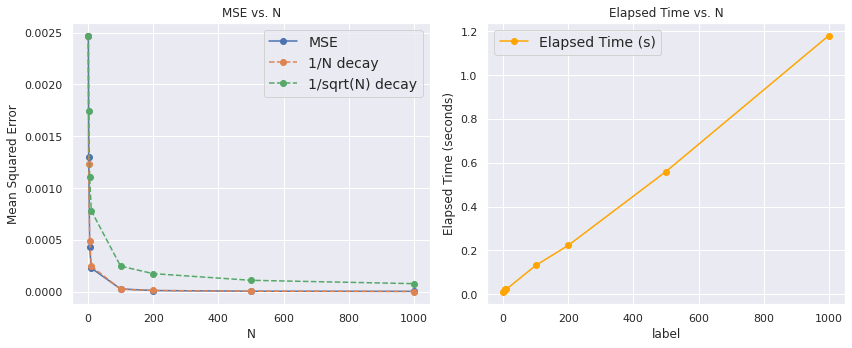

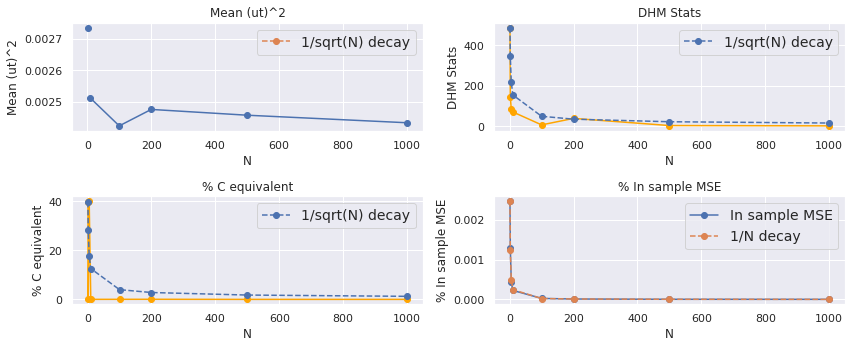

In [22]:

create_plots(df_results_average_N["N"].values, df_results_average_N["MSE"].values, df_results_average_N["Time"].values, df_results_average_N["mean_square_ut"].values, df_results_average_N["dhm_stat"].values, np.abs(df_results_average_N["c_equivalent"]).values, ref_index_plot=0)

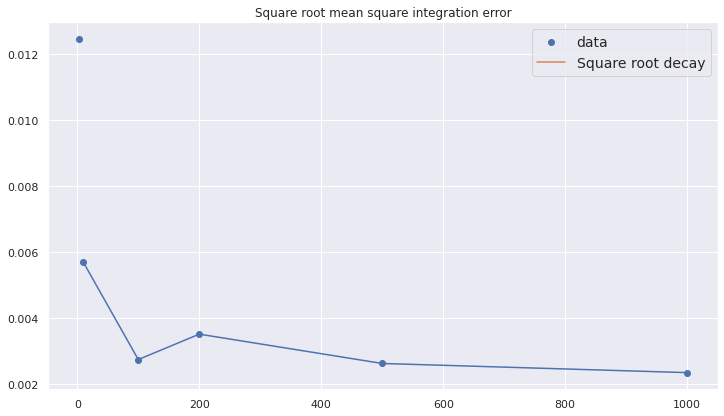

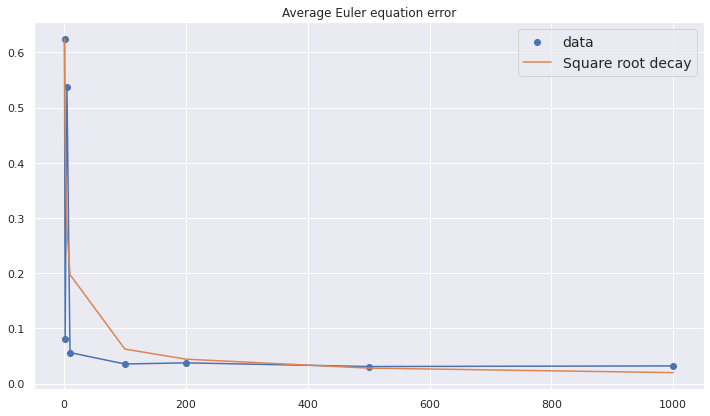

In [23]:
plt.scatter(df_results_average_N["N"], np.sqrt(df_results_average_N["MSIE"]), label="data")
plt.plot(df_results_average_N["N"], np.sqrt(df_results_average_N["MSIE"]))
plt.plot(df_results_average_N["N"], np.sqrt(df_results_average_N["MSIE"].values[0] * (df_results_average_N["N"].values[0]/df_results_average_N["N"]) ), label="Square root decay")
plt.title("Square root mean square integration error")
plt.legend()
plt.savefig(output_folder + "MSIE_N.pdf", dpi=300)
plt.show()

plt.scatter(df_results_average_N["N"], np.sqrt(df_results_average_N["A_EEE"]), label="data")
plt.plot(df_results_average_N["N"], np.sqrt(df_results_average_N["A_EEE"]))
plt.plot(df_results_average_N["N"], np.sqrt(df_results_average_N["A_EEE"].values[0] * (df_results_average_N["N"].values[0]/df_results_average_N["N"]) ), label="Square root decay")

plt.title("Average Euler equation error")
plt.savefig(output_folder + "A_EEE_N.pdf", dpi=300)
plt.legend()
plt.show()


several choices of $M$.

In [24]:
# --------------------------------------------------------------------------
# Main code (outside numba) to run the PEA iterations.
# --------------------------------------------------------------------------
list_M = [200, 500, 1000, 5000, 10000, 20000]
MSE_M = np.zeros(len(list_M)) #In-sample
MSIE_M = np.zeros(len(list_M)) #Mean square integration error, out-sample
A_EEE_M = np.zeros(len(list_M)) #Average absolute value of Euler equation error, out-sample
Time_M = np.zeros(len(list_M))

# Number innovation draws
N = 2 #10 #1
init = 100 #burnin

tol = 1e-8
gam = 1.0  # smoothing parameter
max_iter = 50 # max number of iterations
redraw_shocks_every = 1000 #redraw new realizations of innovations (new state and innovation vectors)

# Innovations for the out-sample test
slong_test = 100000
init_test = 1000
e_test = params.std_tfp * np.random.randn(slong_test) #New shocks

# Preallocate arrays for test
a_test            = np.zeros(slong_test)
k_test            = np.zeros(slong_test+1)
mu_test           = np.zeros(slong_test+1)
production_test   = np.zeros(slong_test)
inv_test          = np.zeros(slong_test)
IE           = np.zeros(slong_test)
EEE          = np.zeros(slong_test)
cash_test         = np.zeros(slong_test)
c_test            = np.zeros(slong_test)
X_test            = np.zeros((slong_test, params.nb_expl_vars))
X_next_test       = np.zeros(params.nb_expl_vars)
linear_model_test = np.zeros(slong_test)
y_temp1_test      = np.zeros(len(params.nodes_flat))

# to store restults
results = []

np.random.seed(1)
#for N in range(1, max_N+1):
for (index_M, M) in enumerate(list_M):
    slong = init + M
    print("Running simulation with M =", M)
    # repeat several times
    for nb_rep in range(nb_tot_reps):

        b0_current = coeff_array_0.copy()  # initial guess (shape (6,))
    
        # innovation for state vector (not used directly in simulation here
        # for M large, no need to redraw many times.
        e = params.std_tfp * np.random.randn(slong)
        # extra draws for each state: shape (slong, N)
        E = params.std_tfp * np.random.randn(slong, N)
    
        # Preallocate arrays
        a = np.zeros(slong)
        k      = np.zeros(slong + 1)    # capital path (slong+1 because we update k[i+1])
        mu     = np.zeros(slong + 1)    # Lagrange multiplier on investment constraint
        y_out      = np.zeros(slong)    # simulated y
        production = np.zeros(slong)    # production
        inv = np.zeros(slong)           # investment
        cash     = np.zeros(slong)      # cash in hand
        c = np.zeros(slong)             # consumption
        X_data      = np.zeros((slong, params.nb_expl_vars))   # regressor matrix (6 variables)
        X_next = np.zeros(params.nb_expl_vars) # regressor, next period
        y_temp = np.zeros(N)            # temporary array for innovations
    
        # Warmup (compilation) first go
        ## Without preallocations
        #X_data, y_out = simulate_path_N(slong, params.kss, e, E, b0_current, params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N, params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis)
        ## With preallocations
        simulate_path_N_inplace(M, init, params.kss, e, E, b0_current,
                                params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N,
                                params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                a, k, mu, y_out, production, inv, cash, c, X_data, X_next, y_temp)
    
        start_time = time.perf_counter()
        iter_num = 1
        crit = 1.0
        # Run a fixed number of iterations (or use while crit > tol)
        while iter_num < max_iter:
            if iter_num % redraw_shocks_every == 0:
                e[:], E[:,:] = generate_random_arrays(slong, N, params.std_tfp)
    
            # Call the numba-compiled simulation to get regression data.
            #X_data, y_out = simulate_path_N(slong, params.kss, params.css, params.std_k, params.std_c, e, E, b0_current, params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N, params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis)
            simulate_path_N_inplace(M, init, params.kss, e, E, b0_current,
                                params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N,
                                params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                a, k, mu, y_out, production, inv, cash, c, X_data, X_next, y_temp)
    
            # Remove burnin and last period
            X_reg = X_data[init:-1, :]
            y_reg = y_out[init:-1]
            # OLS
            bt, _, _, _ = np.linalg.lstsq(X_reg, y_reg, rcond=None)

            if params.regression_two_steps == True:
                #print(f"Step 1 coef: {bt}")
                # Square root of weights, when using log model
                sqrt_w = np.exp(X_reg @ bt)
                # Pre-multiply and then regress again
                X_wls = X_reg * sqrt_w[:, None]
                y_wls = y_reg * sqrt_w
                bt, _, _, _ = np.linalg.lstsq(X_wls, y_wls, rcond=None)

            
            # Parameter update
            b_new = gam * bt + (1 - gam) * b0_current
            crit = np.max(np.abs(b_new - b0_current))
            b0_current = b_new.copy()
            if (iter_num % 10 == 0):
                print("Iteration:", iter_num, "Conv. crit.:", crit)
            iter_num += 1
        end_time = time.perf_counter()
        elapsed = end_time - start_time
        print("Elapsed time for M =", M, ":", elapsed, "seconds")
        # Compute residuals and In-sample MSE.
        Res = y_reg - np.dot(X_reg, b0_current)
        MSE = np.mean(Res ** 2)
        MSE_M[index_M] = MSE
        # Alternative measure of accuracy
        mean_abs_ut, mean_square_ut, std_ut, dhm_stat, c_equivalent = dhm_accuracy_test(params, b0_current, e_test)
    
    
        evaluate_IE_and_EEE_Gauss_path_inplace(slong_test, params.kss, 
                                         e_test, b0_current, params.beta, params.gamma, params.alpha,
                                         params.delta, params.rho_tfp, len(params.nodes_flat),
                                         params.nodes_flat, params.weights, params.nb_expl_vars,
                                         params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                         a_test, k_test, mu_test, production_test, inv_test,
                                         IE, EEE, cash_test, c_test, X_test, X_next_test, linear_model_test,
                                         y_temp1_test)
    
        MSIE_M[index_M] = np.mean(IE[init_test:-1]**2)
        A_EEE_M[index_M] = np.mean(np.abs(EEE[init_test:-1]))
    
        Time_M[index_M] = elapsed
        print("Final iteration M:", M, "Iterations:", iter_num, "OLS MSE:", MSE, "MISE:", MSIE_M[index_M], "Average EEE:", A_EEE_M[index_M])
        print("Final b0:", b0_current)
    
        # Store the results in a dictionary
        results.append({
            "repetition": nb_rep,
            "k": params.nb_expl_vars,
            "M": M,
            "N": N,
            "Time": elapsed,
            "MSE": MSE,
            "MSIE": MSIE_M[index_M],
            "A_EEE": A_EEE_M[index_M],
            "Mean_abs_u": mean_abs_ut, 
            "mean_square_ut": mean_square_ut, 
            "std_ut": std_ut, 
            "dhm_stat": dhm_stat, 
            "c_equivalent": c_equivalent
            })

# Create a Pandas DataFrame from the results
df_results_M = pd.DataFrame(results)
df_results_M.to_csv(output_folder + "df_results_M.csv")
print(df_results_M.head())

# Create average df, averaging over repetitions
df_results_M["M_init"]    = df_results_M["M"] + init #add burnin
df_results_M["log_N"]    = np.log(df_results_M["N"])
df_results_M["log_M"]    = np.log(df_results_M["M"])
df_results_M["log_MN"]   = np.log(df_results_M["M"] * df_results_M["N"])
df_results_M["MN_label"] = df_results_M["M"].astype("str") + "-" + df_results_M["N"].astype("str")

# Remove outliers (non-convergence)
#df_results_M = df_results_M[df_results_M["MSIE"] < 1.0]

df_results_average_M = df_results_M.groupby("MN_label").mean().reset_index()
df_results_average_M.sort_values("M", inplace=True)
df_results_average_M.to_csv(output_folder + "df_results_average_M.csv")
print(df_results_average_M.head())


Running simulation with M = 200
Iteration: 10 Conv. crit.: 0.13041853644967868
Iteration: 20 Conv. crit.: 0.025541500700782357
Iteration: 30 Conv. crit.: 0.0035198777813173487
Iteration: 40 Conv. crit.: 0.00047978759251976477
Elapsed time for M = 200 : 0.013015023000207293 seconds


/tmp/ipykernel_12246/4169438773.py:61: RuntimeWarning: overflow encountered in scalar power
  c[i] = E_t_tilde ** (-1/params.gamma)
/tmp/ipykernel_12246/4169438773.py:61: RuntimeWarning: divide by zero encountered in scalar power
  c[i] = E_t_tilde ** (-1/params.gamma)
/tmp/ipykernel_12246/4169438773.py:73: RuntimeWarning: overflow encountered in multiply
  ut = c[T]**(-params.gamma) - mu[T] - params.beta * ( ( c[T1]**(-params.gamma) ) * (params.alpha * np.exp(a[T1]) * k[T1] ** (params.alpha - 1) + 1 - params.delta) + mu[T1] * ( 1 - params.delta) )
/home/julien/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_12246/4169438773.py:78: RuntimeWarning: overflow encountered in square
  mean_square_ut = np.mean(ut**2)
/home/julien/.local/lib/python3.8/site-packages/numpy/core/_methods.py:215: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_s

Final iteration M: 200 Iterations: 50 OLS MSE: 0.0011878875209478325 MISE: inf Average EEE: 1.0
Final b0: [-0.54948801  0.41984213 -0.45314758  0.08389643 -1.00854288  0.28832467
  0.08792952  0.04084077  0.00305461 -0.24268582]
Iteration: 10 Conv. crit.: 0.0033212120221453034
Iteration: 20 Conv. crit.: 0.00043961596979880113
Iteration: 30 Conv. crit.: 6.228455208834305e-05
Iteration: 40 Conv. crit.: 9.579544043791799e-06
Elapsed time for M = 200 : 0.01062071899991679 seconds
Final iteration M: 200 Iterations: 50 OLS MSE: 0.00154318546935258 MISE: 0.00040152065404153045 Average EEE: 0.010897060694096624
Final b0: [-0.20972062  0.10688078 -3.44404888  2.6796081   0.06439024 -0.63895855
 -0.0114775  -0.13416465 -1.44628062  0.6004191 ]
Iteration: 10 Conv. crit.: 0.019651263197978386
Iteration: 20 Conv. crit.: 0.0017461135346912293
Iteration: 30 Conv. crit.: 0.00019301565922524855
Iteration: 40 Conv. crit.: 2.3028444846140417e-05
Elapsed time for M = 200 : 0.011064123000096515 seconds
Fin

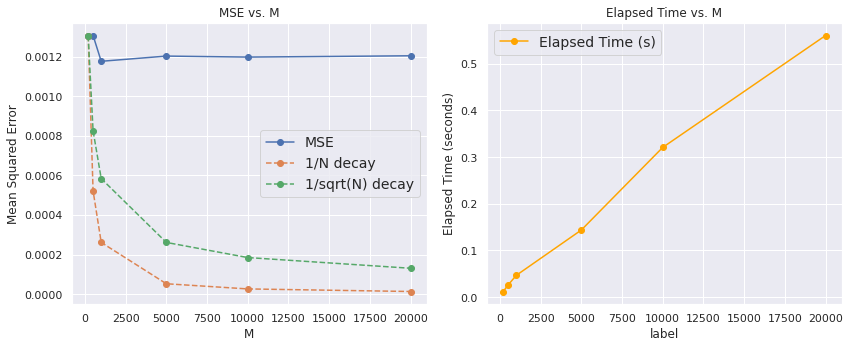

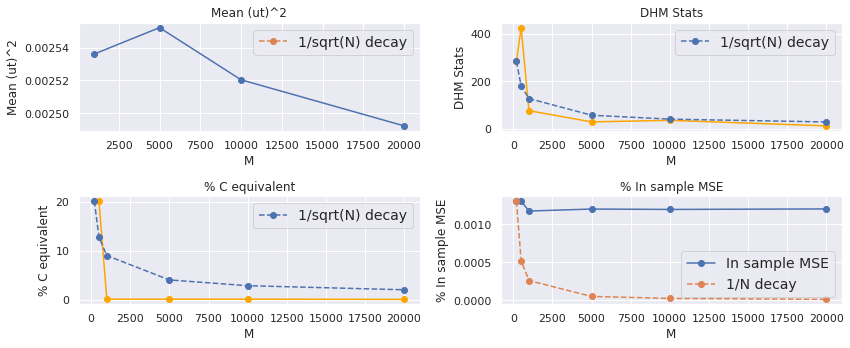

In [25]:
create_plots(df_results_average_M["M"].values, df_results_average_M["MSE"].values, df_results_average_M["Time"].values, df_results_average_M["mean_square_ut"].values, df_results_average_M["dhm_stat"].values, np.abs(df_results_average_M["c_equivalent"]).values, ref_index_plot=0, label="M")

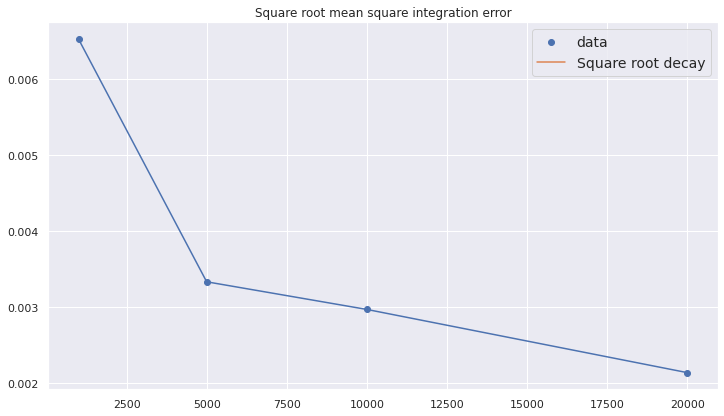

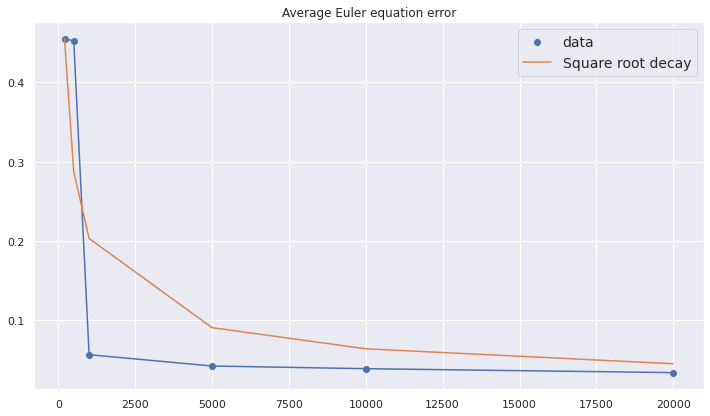

In [26]:
plt.scatter(df_results_average_M["M"], np.sqrt(df_results_average_M["MSIE"]), label="data")
plt.plot(df_results_average_M["M"], np.sqrt(df_results_average_M["MSIE"]))
plt.plot(df_results_average_M["M"], np.sqrt(df_results_average_M["MSIE"].values[0] * (df_results_average_M["M"].values[0]/df_results_average_M["M"]) ), label="Square root decay")
plt.title("Square root mean square integration error")
plt.legend()
plt.savefig(output_folder + "MSIE_M.pdf", dpi=300)
plt.show()

plt.scatter(df_results_average_M["M"], np.sqrt(df_results_average_M["A_EEE"]), label="data")
plt.plot(df_results_average_M["M"], np.sqrt(df_results_average_M["A_EEE"]))
plt.plot(df_results_average_M["M"], np.sqrt(df_results_average_M["A_EEE"].values[0] * (df_results_average_M["M"].values[0]/df_results_average_M["M"]) ), label="Square root decay")

plt.title("Average Euler equation error")
plt.savefig(output_folder + "A_EEE_M.pdf", dpi=300)
plt.legend()
plt.show()


### Varying M and N

In [ ]:
plt.plot(k[:1000])
plt.axhline(y = params.kss, label="k SS")
plt.axhline(y = np.mean(k), label="k mean")

In [27]:
# IF want to measure aroung target MN
list_MN_target = [2000, 10000, 20000, 50000, 100000, 1000000] #Number for MN
list_N_target = [1, 5, 10, 25, 50, 100, 200, 300, 500] #number of innovation draws, per state vector

min_M = 100
# Inplied values for M
list_M = []
list_N = []
for MN in list_MN_target:
    list_M += [round(int(np.maximum(random.uniform(0.8, 1.2)*(MN/N), min_M))/10)*10 for N in list_N_target] #number of state vector draws
    list_N += list_N_target

pd.DataFrame({'M': list_M, 'N': list_N}).head(10)

,M,N
0,1920,1
1,340,5
2,180,10
3,100,25
4,100,50
5,100,100
6,100,200
7,100,300
8,100,500
9,9660,1


In [ ]:
%%time

list_N = [1, 5, 10, 25, 50, 100, 200, 300] #number of innovation draws, per state vector
list_M = [300, 1000, 5000, 10000, 20000, 50000] #number of state vector draws

init = 100 #100 #burnin, train data

tol = 1e-8 # tolerance on parameter vector
gam = 1.0  # smoothing parameter between two iterations
max_iter = 50 # max number of iterations
redraw_shocks_every = 1000 #redraw new realizations of innovations (new state and innovation vectors)

slong_test = 100000
init_test = 1000 #burnin, test data
nb_tot_reps = 5 #nb of repetitions, to smooth out randomness and potential issues with measuring timing

# Preallocate arrays for test
a_test            = np.zeros(slong_test)
k_test            = np.zeros(slong_test+1)
mu_test           = np.zeros(slong_test+1)
production_test   = np.zeros(slong_test)
inv_test          = np.zeros(slong_test)
IE           = np.zeros(slong_test)
EEE          = np.zeros(slong_test)
cash_test         = np.zeros(slong_test)
c_test            = np.zeros(slong_test)
X_test            = np.zeros((slong_test, params.nb_expl_vars))
X_next_test       = np.zeros(params.nb_expl_vars)
linear_model_test = np.zeros(slong_test)
y_temp1_test      = np.zeros(len(params.nodes_flat))

# to store restults
results = []
np.random.seed(42)

for (index_N, N) in enumerate(list_N):
    for (index_M, M) in enumerate(list_M):
    #for (N, M) in zip(list_N, list_M):
        for nb_rep in range(nb_tot_reps):
            # Innovations for the out-sample test
            #np.random.seed(nb_rep)
            e_test = params.std_tfp * np.random.randn(slong_test) #New shocks

            slong = init + M

            b0_current = coeff_array_0.copy()  # initial guess (shape (6,))

            # innovation for state vector (not used directly in simulation here
            # for M large, no need to redraw many times.
            e = params.std_tfp * np.random.randn(slong)
            # extra draws for each state: shape (slong, N)
            E = params.std_tfp * np.random.randn(slong, N)

            # Preallocate arrays
            a = np.zeros(slong)
            k      = np.zeros(slong + 1)    # capital path (slong+1 because we update k[i+1])
            mu     = np.zeros(slong + 1)    # Lagrange multiplier on investment constraint
            y_out      = np.zeros(slong)    # simulated y
            production = np.zeros(slong)    # production
            inv = np.zeros(slong)           # investment
            cash     = np.zeros(slong)      # cash in hand
            c = np.zeros(slong)             # consumption
            X_data      = np.zeros((slong, params.nb_expl_vars))   # regressor matrix (6 variables)
            X_next = np.zeros(params.nb_expl_vars) # regressor, next period
            y_temp = np.zeros(N)            # temporary array for innovations

            # Warmup (compilation) first go
            simulate_path_N_inplace(M, init, params.kss, e, E, b0_current,
                                params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N,
                                params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                a, k, mu, y_out, production, inv, cash, c, X_data, X_next, y_temp)
            
            iter_num = 1
            crit = 1.0
            # Run a fixed number of iterations (or use while crit > tol)
            start_time = time.perf_counter()
            while iter_num < max_iter:
                if iter_num % redraw_shocks_every == 0:
                    e[:], E[:,:] = generate_random_arrays(slong, N, params.std_tfp)

                # Simulation:
                simulate_path_N_inplace(M, init, params.kss, e, E, b0_current,
                                params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N,
                                params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                a, k, mu, y_out, production, inv, cash, c, X_data, X_next, y_temp)

                # Remove burnin and last period
                X_reg = X_data[init:-1, :]
                y_reg = y_out[init:-1]
                # OLS
                bt, _, _, _ = np.linalg.lstsq(X_reg, y_reg, rcond=None)
                # Parameter update
                b_new = gam * bt + (1 - gam) * b0_current
                crit = np.max(np.abs(b_new - b0_current))
                b0_current = b_new.copy()
                #print("Iteration:", iter_num, "Conv. crit.:", crit)
                iter_num += 1

            end_time = time.perf_counter()
            elapsed = end_time - start_time

            print(f"Iter {nb_rep}. M = {M}, N = {N}, elapsed time: {elapsed} seconds")
            # Compute residuals and In-sample MSE.
            Res = y_reg - np.dot(X_reg, b0_current)
            MSE = np.mean(Res ** 2)

            # Alternative measure of accuracy
            #mean_abs_ut, mean_square_ut, std_ut, dhm_stat, c_equivalent = dhm_accuracy_test(params, b0_current, e_test)

            # Mean squared integration error and EEE
            #IE, EEE = evaluate_IE_and_EEE_Gauss_path(slong_test, params.kss, params.css, params.std_k, params.std_c, e_test, b0_current, params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, len(params.nodes_flat), params.nodes_flat, params.weights, params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis)
            evaluate_IE_and_EEE_Gauss_path_inplace(slong_test, params.kss, 
                                         e_test, b0_current, params.beta, params.gamma, params.alpha,
                                         params.delta, params.rho_tfp, len(params.nodes_flat),
                                         params.nodes_flat, params.weights, params.nb_expl_vars,
                                         params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                         a_test, k_test, mu_test, production_test, inv_test,
                                         IE, EEE, cash_test, c_test, X_test, X_next_test, linear_model_test,
                                         y_temp1_test)


            MSIE = np.mean(IE[init_test:-1]**2)
            A_EEE = np.mean(np.abs(EEE[init_test:-1]))

            print("Final iteration M:", M, "Iterations:", iter_num, "OLS MSE:", MSE, "MISE:", MSIE, "Average EEE:", A_EEE)
            print("Final b0:", b0_current)

            # Store the results in a dictionary
            results.append({
                "repetition": nb_rep,
                "k": params.nb_expl_vars,
                "M": M,
                "N": N,
                "Time": elapsed,
                "MSE": MSE,
                "MSIE": MSIE,
                "A_EEE": A_EEE
                })

# Create a Pandas DataFrame from the results
df_results = pd.DataFrame(results)
df_results.to_csv(output_folder + "df_results.csv")
print(df_results.head())

In [ ]:
df_results["M_init"]    = df_results["M"] + init #add burnin
df_results["log_N"]    = np.log(df_results["N"])
df_results["log_M"]    = np.log(df_results["M"])
df_results["log_MN"]   = np.log(df_results["M"] * df_results["N"])

df_results["MN_label"] = df_results["M"].astype("str") + "-" + df_results["N"].astype("str")

# Remove outliers (non-convergence)
df_results = df_results[df_results["MSIE"] < 1.0]

df_results_average = df_results.groupby("MN_label").mean().reset_index()
print(df_results_average.head())

# sigma_e**2 * k / (N**alpha * (M - k - 1))
m = smf.ols("np.log(MSIE) ~ np.log(N) + np.log(M - k - 1)", data=df_results_average).fit()
coef_alpha = -m.params["np.log(N)"]
print(coef_alpha)
print(m.summary())


## Simulation + OLS time
# 1. Time moddel
m = smf.ols("Time ~ I(M*N) + M ", data=df_results_average).fit()
print(m.summary())

# 2. Extract point estimates
c_st = m.params["Intercept"]
alpha_MN = m.params["I(M * N)"]      # coeff on M*N
alpha_M  = m.params["M"]             # coeff on M

# 3. Extract standard errors
se_c_st = m.bse["Intercept"]
se_alpha_MN = m.bse["I(M * N)"]      # SE of alpha_MN
se_alpha_M  = m.bse["M"]             # SE of alpha_M

# 4. Extract covariance between the two slopes
cov_M_MN = m.cov_params().loc["M", "I(M * N)"]  # covariance between alpha_M and alpha_MN

# 5. Extra full covariance matrix
print(m.cov_params()) # full var-cov matrix
# Reorder
cov_mat = m.cov_params().loc[['Intercept','M','I(M * N)'], ['Intercept','M','I(M * N)']].values

print("alpha_MN =", alpha_MN, "±", se_alpha_MN)
print("alpha_M  =", alpha_M,  "±", se_alpha_M)
print("Cov(alpha_M, alpha_MN) =", cov_M_MN)

## Simulation + OLS time
## Checking the burnin does not change timing model
## Should only change constant
m = smf.ols("Time ~ I(M_init*N) + M_init ", data=df_results_average).fit()
print(m.summary())

In [ ]:
df_results_average["log_Time"] = np.log(df_results_average["Time"])

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# 1) Time vs N, colored by M
axs[0, 0].scatter(df_results_average["N"], df_results_average["Time"], c=df_results_average["M"], alpha=0.7)
axs[0, 0].set_xlabel("N")
axs[0, 0].set_ylabel("Time")
axs[0, 0].set_title("Time vs N (color=M)")

# 2) Time vs M, colored by N
axs[0, 1].scatter(df_results_average["M"], df_results_average["Time"], c=df_results_average["N"], alpha=0.7)
axs[0, 1].set_xlabel("M")
axs[0, 1].set_ylabel("Time")
axs[0, 1].set_title("Time vs M (color=N)")

# 3) log_Time vs log_N, colored by M
axs[1, 0].scatter(df_results_average["log_N"], df_results_average["log_Time"], c=df_results_average["M"], alpha=0.7)
axs[1, 0].set_xlabel("log(N)")
axs[1, 0].set_ylabel("log(Time)")
axs[1, 0].set_title("log(Time) vs log(N) (color=M)")

# 4) log_Time vs log_M, colored by N
axs[1, 1].scatter(df_results_average["log_M"], df_results_average["log_Time"], c=df_results_average["N"], alpha=0.7)
axs[1, 1].set_xlabel("log(M)")
axs[1, 1].set_ylabel("log(Time)")
axs[1, 1].set_title("log(Time) vs log(M) (color=N)")

# 5) log_Time vs log_MN, colored by N
axs[2, 0].scatter(df_results_average["log_MN"], df_results_average["log_Time"], c=df_results_average["N"], alpha=0.7)
axs[2, 0].set_xlabel("log(M*N)")
axs[2, 0].set_ylabel("log(Time)")
axs[2, 0].set_title("log(Time) vs log(M*N) (color=N)")

# Remove the unused subplot
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.savefig(output_folder + "plot_Time_MN.pdf", dpi=300)
plt.show()


#### Pareto frontier

In [ ]:
def compute_pareto_front(df, time_col='Time', mse_col='MSIE'):
    # Sort by Time ascending
    df_sorted = df.sort_values(by=time_col, ascending=True)

    # List to store the Pareto front
    pareto_points = []

    # Keep track of the lowest MSE encountered so far
    best_mse_so_far = float('inf')

    for idx, row in df_sorted.iterrows():
        mse_val = row[mse_col]
        if mse_val < best_mse_so_far:
            pareto_points.append(row)
            best_mse_so_far = mse_val

    return pd.DataFrame(pareto_points)

pareto_df = compute_pareto_front(df_results_average)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_results_average, x='Time', y='MSIE', hue='M', palette='viridis', alpha=0.7)
#plt.plot(pareto_df['Time'], pareto_df['MSIE'], 'r-o', label='Pareto Frontier')

# Now highlight the optimal points
optimal_df = df_results_average[df_results_average['N'] == 1]
plt.scatter(optimal_df['Time'], optimal_df['MSIE'],
            marker='*', s=250, c='red',
            edgecolors='black', linewidths=1,
            label='N = 1')

plt.xlabel('Time (seconds)')
plt.ylabel('MSIE')
plt.yscale('log')
plt.xscale('log')
plt.title('Time vs. MSIE, Colored by M')
plt.legend()
plt.grid(True)
plt.savefig(output_folder + "Time_vs_MSIE_1.pdf", dpi=300)
plt.show()

df_results_sel = df_results_average[df_results_average["Time"] < 1.0]
pareto_df = compute_pareto_front(df_results_sel)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_results_sel, x='Time', y='MSIE', hue='M', palette='viridis', alpha=0.7)
plt.plot(pareto_df['Time'], pareto_df['MSIE'], 'r-o', label='Pareto Frontier')

# Now highlight the optimal points
optimal_df = df_results_sel[df_results_sel['N'] == 1]
plt.scatter(optimal_df['Time'], optimal_df['MSIE'],
            marker='*', s=250, c='red',
            edgecolors='black', linewidths=1,
            label='N = 1')

plt.xlabel('Time (seconds)')
plt.ylabel('MSIE')
plt.yscale('log')
plt.xscale('log')
plt.title('Time vs. MSIE, Colored by M')
plt.legend()
plt.grid(True)
plt.savefig(output_folder + "Time_vs_MSIE_2.pdf", dpi=300)
plt.show()


In [ ]:
pareto_df = compute_pareto_front(df_results_average, time_col='Time', mse_col='A_EEE')

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_results_average, x='Time', y='A_EEE', hue='N', palette='viridis', alpha=0.7)
#plt.plot(pareto_df['Time'], pareto_df['A_EEE'], 'r-o', label='Pareto Frontier')

# Now highlight the optimal points
optimal_df = df_results_average[df_results_average['N'] == 1]
plt.scatter(optimal_df['Time'], optimal_df['A_EEE'],
            marker='*', s=250, c='red',
            edgecolors='black', linewidths=1,
            label='N = 1')

plt.xlabel('Time (seconds)')
plt.ylabel('A_EEE')
plt.yscale('log')
plt.xscale('log')
plt.title('Time vs. EEE, Colored by N')
plt.legend()
plt.grid(True)
plt.savefig(output_folder + "Time_vs_EEE_1.pdf", dpi=300)
plt.show()

In [ ]:
def optimal_M_N_old(T, k, alpha, alpha0, alpha1, alpha2, eps=1e-12, round_nearest = True):
    """
    Compute the pair (M*, N*) that minimizes MSIE
      E[(…)^2] ∼ σ^2 k / [N^α (M−k−1)]
    subject to the time budget
      T = α0 + α1⋅M⋅N + α2⋅M.

    Parameters
    ----------
    T : float
        Total time budget (must exceed α0).
    k : int
        Number of regressors, including constant
    alpha : float
        Exponent in the integration error ( >1 for well‑posed optimum).
    alpha0 : float
        Intercept term (c_st).
    alpha1 : float
        Coefficient on M⋅N.
    alpha2 : float
        Coefficient on M.
    eps : float, optional
        Threshold below which we treat alpha2 as zero.
    round_nearest : boolean, optional
        If true, round to nearest 10

    Returns
    -------
    M_star, N_star : tuple of floats
        Optimal M and N.
    """
    C0 = T - alpha0
    if C0 <= 0:
        raise ValueError("T must exceed alpha0")
    # α2 → 0 limit
    if abs(alpha2) < eps:
        M_star = alpha * (k + 1) / (alpha - 1)
    else:
        A = (alpha - 1) * C0
        B = alpha * C0 * (k + 1)
        # positive root of α2 M^2 + (α-1)C0 M - α C0 (k+1) = 0
        M_star = (-A + np.sqrt(A**2 + 4 * alpha2 * B)) / (2 * alpha2)

    # back out N from the time constraint
    N_star = (C0 - alpha2 * M_star) / (alpha1 * M_star)

    # round to nearest 10
    if round_nearest == True:
         M_star = int(np.round(M_star/10) * 10)
         N_star = int(np.round(N_star/10) * 10)

    return M_star, N_star


def optimal_M_N(T, k, alpha, alpha0, alpha1, alpha2,
                rho=0.0,
                eps=1e-12,
                round_nearest=True,
                effective_sample_size=True):
    """
    Compute the pair (M*, N*) that minimizes MSIE
      E[(…)^2] ∼ σ^2 k / [N^α (M−k−1)]
    subject to the time budget
      T = α0 + α1⋅M⋅N + α2⋅M.

    If effective_sample_size=True, applies AR(1) correction.
    The effective sample size for M is:
      M_eff = M*(1−rho)/(1+rho) <-> M = M_eff * (1+rho)/(1-rho).
    Then, recompute N using the time budget.

    Parameters
    ----------
    T : float
    k : int
    alpha : float (>1)
    alpha0 : float
    alpha1 : float
    alpha2 : float
    rho : float
      AR(1) coefficient for effective sample-size adjustment.
    eps : float
    round_nearest : bool
    effective_sample_size : bool

    Returns
    -------
    M_star, N_star
    """
    C0 = T - alpha0
    if C0 <= 0:
        raise ValueError("T must exceed alpha0")

    # 1) find the M* ignoring serial correlation
    if abs(alpha2) < eps:
        M_star = alpha * (k + 1) / (alpha - 1)
    else:
        A = (alpha - 1) * C0
        B = alpha * C0 * (k + 1)
        # solve α2 M^2 + (α-1)C0 M - α C0 (k+1) = 0
        M_star = (-A + np.sqrt(A**2 + 4 * alpha2 * B)) / (2 * alpha2)

    # 2) back out N* from the time constraint
    N_star = (C0 - alpha2 * M_star) / (alpha1 * M_star)

    # 3) optionally apply AR(1) effective-M correction
    if effective_sample_size:
        if not (-1 < rho < 1):
            raise ValueError("rho must lie in (-1,1) for effective-M")
        # Increase the value of M* by a factor of (1 + rho) / (1 - rho).
        # Because of serial correaltion, each observation of the state is less "valuable"
        M_eff = M_star * (1 + rho) / (1 - rho)
        # recompute N under same time budget
        N_eff = (C0 - alpha2 * M_eff) / (alpha1 * M_eff)
        M_star, N_star = M_eff, N_eff

    # 4) optionally round
    if round_nearest:
        M_star = int(np.round(M_star / 10) * 10)
        N_star = int(np.round(N_star / 10) * 10)

    return M_star, N_star

# Delta method to calculate uncertainty aroud M *and N*
def se_MN_star_full(
    M_star, N_star, T, k, alpha,
    alpha_0, alpha_M, alpha_MN,
    se_alpha_0, se_alpha_M, se_alpha_MN,
    cov_mat          # 3×3 numpy array from m.cov_params().values
):
    # Precompute
    C0 = T - alpha_0
    b  = (alpha - 1)*C0
    D  = np.sqrt(b*b + 4*alpha_M*alpha*C0*(k+1))

    # 1) partials for M*
    dM_d0 = -1/(2*alpha_M)*((alpha-1)
             - ((alpha-1)**2 *C0 + 2*alpha*alpha_M*(k+1))/D)
    dM_dM = (alpha*C0*(k+1)/D - M_star)/alpha_M
    dM_dMN= 0.0

    grad_M = np.array([dM_d0, dM_dM, dM_dMN])
    var_M  = grad_M @ cov_mat @ grad_M
    se_M   = np.sqrt(var_M)

    # 2) partials for N*
    dN_d0 = (1/(alpha_MN*M_star)
             - (C0 - alpha_M*M_star)/(alpha_MN*(M_star**2))*dM_d0)
    dN_dM = (-1/alpha_MN
             - (C0 - alpha_M*M_star)/(alpha_MN*(M_star**2))*dM_dM)
    dN_dMN= -N_star/alpha_MN

    grad_N = np.array([dN_d0, dN_dM, dN_dMN])
    var_N  = grad_N @ cov_mat @ grad_N
    se_N   = np.sqrt(var_N)

    return se_M, se_N

target_time = 1
for eff_M in [True, False]:
    for alpha_selected in [coef_alpha, 1.0]:
        M_opt, N_opt = optimal_M_N(target_time, params.nb_expl_vars, alpha_selected, c_st, alpha_MN, alpha_M, rho = params.rho_tfp, effective_sample_size = eff_M)
    
        se_M_opt, se_N_opt = se_MN_star_full(M_opt, N_opt, target_time, params.nb_expl_vars, alpha_selected,
                                            c_st, alpha_M, alpha_MN,
                                            se_c_st, se_alpha_M, se_alpha_MN, cov_mat)
        print(f"alpha: {alpha_selected}. Effective sample size M: {eff_M}")
        print(f"M*: {M_opt} +/- 2 * {se_M_opt}")
        print(f"N*: {N_opt} +/- 2 * {se_N_opt}")


In [ ]:
(1 + params.rho_tfp) / (1 - params.rho_tfp)

In [ ]:
# 1) Pivot MSIE into a matrix with rows=M and columns=N
df_sel = df_results_average[df_results_average["MSIE"] < 1.0].copy()

df_sel["log_MSIE"] = np.log10(df_sel["MSIE"])
df_sel["log_MSIE_Time"] = np.log10(df_sel["MSIE"]/df_sel["Time"])
df_sel["log_MSIE_x_Time"] = np.log10(df_sel["MSIE"]*df_sel["Time"]/10)


# TIME
pivot = df_sel.pivot_table(
    index='M',
    columns='N',
    values='Time',
    aggfunc='mean'        # ensures proper aggregation if duplicates exist
).sort_index().sort_index(axis=1)

# 2) Create a mask of the NaN cells
mask = pivot.isnull()

# 3) Plot with seaborn, masking NaNs
plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    mask=mask,           # hide cells where pivot is NaN
    cmap='viridis',
    cbar_kws={'label': 'Time'},
    linewidths=0.5,
    linecolor='white'
)

plt.xlabel('N (innovation draws)')
plt.ylabel('M (state draws)')
plt.title('Heatmap of Time over (M, N)')
plt.show()

# Accuracy
pivot = df_sel.pivot_table(
    index='M',
    columns='N',
    values='log_MSIE',
    aggfunc='mean'        # ensures proper aggregation if duplicates exist
).sort_index().sort_index(axis=1)

# 2) Create a mask of the NaN cells
mask = pivot.isnull()

# 3) Plot with seaborn, masking NaNs
plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    mask=mask,           # hide cells where pivot is NaN
    cmap='viridis',
    cbar_kws={'label': 'log_MSIE'},
    linewidths=0.5,
    linecolor='white'
)

plt.xlabel('N (innovation draws)')
plt.ylabel('M (state draws)')
plt.title('Heatmap of MSIE over (M, N)')
plt.show()


# Accuracy-Time
pivot = df_sel.pivot_table(
    index='M',
    columns='N',
    values='log_MSIE_x_Time',
    aggfunc='mean'        # ensures proper aggregation if duplicates exist
).sort_index().sort_index(axis=1)

# 2) Create a mask of the NaN cells
mask = pivot.isnull()

# 3) Plot with seaborn, masking NaNs
plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    mask=mask,           # hide cells where pivot is NaN
    cmap='viridis',
    cbar_kws={'label': 'log_MSIE_x_Time'},
    linewidths=0.5,
    linecolor='white'
)

plt.xlabel('N (innovation draws)')
plt.ylabel('M (state draws)')
plt.title('Heatmap of (MSIExTime)/10 over (M, N)')
plt.show()


### Variation around a target time


In [ ]:
# Redo regression, but with data close to target times
df_selected = df_results_average[df_results_average["Time"] < 10]

# Accuracy model
m = smf.ols("np.log(MSIE) ~ np.log(N) + np.log(M - k - 1)", data=df_selected).fit()
#coef_alpha = -m.params["np.log(N)"] #Use estimated value
coef_alpha = 1.0 #Use theoretical value
print(coef_alpha)
print(m.summary())

## Simulation + OLS time
# 1. Time moddel
m = smf.ols("Time ~ I(M*N) + M ", data=df_results_average).fit()
print(m.summary())

# 2. Extract point estimates
c_st = m.params["Intercept"]
alpha_MN = m.params["I(M * N)"]      # coeff on M*N
alpha_M  = m.params["M"]             # coeff on M

# 3. Extract standard errors
se_c_st = m.bse["Intercept"]
se_alpha_MN = m.bse["I(M * N)"]      # SE of alpha_MN
se_alpha_M  = m.bse["M"]             # SE of alpha_M

# 4. Extract covariance between the two slopes
cov_M_MN = m.cov_params().loc["M", "I(M * N)"]  # covariance between alpha_M and alpha_MN

# 5. Extra full covariance matrix
print(m.cov_params()) # full var-cov matrix
# Reorder
cov_mat = m.cov_params().loc[['Intercept','M','I(M * N)'], ['Intercept','M','I(M * N)']].values

print("alpha_MN =", alpha_MN, "±", se_alpha_MN)
print("alpha_M  =", alpha_M,  "±", se_alpha_M)
print("Cov(alpha_M, alpha_MN) =", cov_M_MN)


list_N        = []
list_M        = []
list_optimal  = []
list_Time     = []
list_se_N = []
list_se_M = []

list_target_times = [0.1, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
min_M = 50 #Otherwise blows up

for target_time in list_target_times:
    # 1) build candidate grid
    list_N_temp = [1, 10, 100, 1000, 10000]
    N_array     = np.array(list_N_temp)

    # recover M from your linear timing law (without burn-in)
    vals = (target_time - c_st) / (alpha_M + alpha_MN * N_array)

    # 2) correct rounding: apply *10 before comprehension
    M_vals = np.round(vals/10) * 10
    list_M_temp = [int(max(m, min_M)) for m in M_vals]  # ensure M ≥ min_M

    # 3) append the non‐optimal candidates
    list_N       += list_N_temp
    list_M       += list_M_temp
    list_optimal += [0] * len(list_N_temp)
    list_Time    += [target_time] * len(list_N_temp)  # align one‐to‐one
    list_se_N += [0] * len(list_N_temp)
    list_se_M += [0] * len(list_M_temp)
    
    # 4) compute the theoretical optimum with burn-in
    M_opt, N_opt = optimal_M_N(target_time, params.nb_expl_vars, coef_alpha, c_st, alpha_MN, alpha_M, rho = params.rho_tfp, effective_sample_size = params.effective_sample_size)
    se_M_opt, se_N_opt = se_MN_star_full(M_opt, N_opt, target_time, params.nb_expl_vars, coef_alpha,
                                        c_st, alpha_M, alpha_MN,
                                        se_c_st, se_alpha_M, se_alpha_MN, cov_mat)

    print(f"alpha: {coef_alpha}")
    print(f"M*: {M_opt} +/- 2 * {se_M_opt}")
    print(f"N*: {N_opt} +/- 2 * {se_N_opt}")

    # 5) append the optimal point
    list_N.append(int(np.maximum(1, N_opt)))
    list_M.append(int(M_opt))
    list_optimal.append(1)
    list_Time.append(target_time)
    list_se_N.append(se_N_opt)
    list_se_M.append(se_M_opt)

# 6) build DataFrame
df_MN = pd.DataFrame({
    "M":           list_M,
    "N":           list_N,
    "is_optimal":  list_optimal,
    "target_time": list_Time,
    "se_M":        list_se_M,
    "se_N":        list_se_N
})


In [ ]:
#----------------------------------
tol = 1e-8 # tolerance on parameter vector
gam = 1.0  # smoothing parameter between two iterations
max_iter = 50 # max number of iterations
redraw_shocks_every = 1000 #redraw new realizations of innovations (new state and innovation vectors)

slong_test = 100000
init_test = 100
nb_tot_reps = 10 #nb of repetitions, to smooth out randomness and potential issues with measuring timing

# Preallocate arrays for test
a_test            = np.zeros(slong_test)
k_test            = np.zeros(slong_test+1)
mu_test           = np.zeros(slong_test+1)
production_test   = np.zeros(slong_test)
inv_test          = np.zeros(slong_test)
IE           = np.zeros(slong_test)
EEE          = np.zeros(slong_test)
cash_test         = np.zeros(slong_test)
c_test            = np.zeros(slong_test)
X_test            = np.zeros((slong_test, params.nb_expl_vars))
X_next_test       = np.zeros(params.nb_expl_vars)
linear_model_test = np.zeros(slong_test)
y_temp1_test      = np.zeros(len(params.nodes_flat))

# to store restults
results = []
np.random.seed(42)

for (N, M, is_optimal) in zip(list_N, list_M, list_optimal):
    for nb_rep in range(nb_tot_reps):
        #np.random.seed(nb_rep)
        # Innovations for the out-sample test
        e_test = params.std_tfp * np.random.randn(slong_test) #New shocks

        slong = init + M

        b0_current = coeff_array_0.copy()  # initial guess (shape (6,))

        # innovation for state vector (not used directly in simulation here
        # for M large, no need to redraw many times.
        e = params.std_tfp * np.random.randn(slong)
        # extra draws for each state: shape (slong, N)
        E = params.std_tfp * np.random.randn(slong, N)

        # Preallocate arrays
        a = np.zeros(slong)
        k      = np.zeros(slong + 1)    # capital path (slong+1 because we update k[i+1])
        mu     = np.zeros(slong + 1)    # Lagrange multiplier on investment constraint
        y_out      = np.zeros(slong)    # simulated y
        production = np.zeros(slong)    # production
        inv = np.zeros(slong)           # investment
        cash     = np.zeros(slong)      # cash in hand
        c = np.zeros(slong)             # consumption
        X_data      = np.zeros((slong, params.nb_expl_vars))   # regressor matrix (6 variables)
        X_next = np.zeros(params.nb_expl_vars) # regressor, next period
        y_temp = np.zeros(N)            # temporary array for innovations

        # Warmup (compilation) first go
        simulate_path_N_inplace(M, init, params.kss, e, E, b0_current,
                                params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N,
                                params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                a, k, mu, y_out, production, inv, cash, c, X_data, X_next, y_temp)

        iter_num = 1
        crit = 1.0
        # Run a fixed number of iterations (or use while crit > tol)
        start_time = time.perf_counter()
        while iter_num < max_iter:
            if iter_num % redraw_shocks_every == 0:
                e[:], E[:,:] = generate_random_arrays(slong, N, params.std_tfp)

            # Simulation:
            simulate_path_N_inplace(M, init, params.kss, e, E, b0_current,
                                params.beta, params.gamma, params.alpha, params.delta, params.rho_tfp, N,
                                params.nb_expl_vars, params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                a, k, mu, y_out, production, inv, cash, c, X_data, X_next, y_temp)

            # Remove burnin and last period
            X_reg = X_data[init:-1, :]
            y_reg = y_out[init:-1]
            # OLS
            bt, _, _, _ = np.linalg.lstsq(X_reg, y_reg, rcond=None)
            # Parameter update
            b_new = gam * bt + (1 - gam) * b0_current
            crit = np.max(np.abs(b_new - b0_current))
            b0_current = b_new.copy()
            #print("Iteration:", iter_num, "Conv. crit.:", crit)
            iter_num += 1
        end_time = time.perf_counter()
        elapsed = end_time - start_time

        print(f"Iter {nb_rep}. M = {M}, N = {N}, elapsed time: {elapsed} seconds")
        # Compute residuals and In-sample MSE.
        Res = y_reg - np.dot(X_reg, b0_current)
        MSE = np.mean(Res ** 2)

        # Alternative measure of accuracy
        #mean_abs_ut, mean_square_ut, std_ut, dhm_stat, c_equivalent = dhm_accuracy_test(params, b0_current, e_test)
        # Mean squared integration error and EEE
        evaluate_IE_and_EEE_Gauss_path_inplace(slong_test, params.kss, 
                                         e_test, b0_current, params.beta, params.gamma, params.alpha,
                                         params.delta, params.rho_tfp, len(params.nodes_flat),
                                         params.nodes_flat, params.weights, params.nb_expl_vars,
                                         params.tol_c, params.center_dep_var, params.normalize_dep_var, params.basis,
                                         a_test, k_test, mu_test, production_test, inv_test,
                                         IE, EEE, cash_test, c_test, X_test, X_next_test, linear_model_test,
                                         y_temp1_test)


        MSIE = np.mean(IE[init_test:-1]**2)
        A_EEE = np.mean(np.abs(EEE[init_test:-1]))

        print("Final iteration M:", M, "Iterations:", iter_num, "OLS MSE:", MSE, "MISE:", MSIE, "Average EEE:", A_EEE)
        print("Final b0:", b0_current)

        # Store the results in a dictionary
        results.append({
            "repetition": nb_rep,
            "k": params.nb_expl_vars,
            "M": M,
            "N": N,
            "Time": elapsed,
            "MSE": MSE,
            "MSIE": MSIE,
            "A_EEE": A_EEE,
            "is_optimal": is_optimal
        })

# Create a Pandas DataFrame from the results
df_results_2 = pd.DataFrame(results)
df_results_2.to_csv(output_folder + "df_results_2.csv")
print(df_results_2.head())

In [ ]:
df_results_2["log_N"]    = np.log(df_results_2["N"])
df_results_2["log_M"]    = np.log(df_results_2["M"])
df_results_2["log_MN"]   = np.log(df_results_2["M"] * df_results_2["N"])

df_results_2["MN_label"] = df_results_2["M"].astype("str") + "-" + df_results_2["N"].astype("str")
df_results_average_2 = df_results_2.groupby("MN_label").mean().reset_index()
print(df_results_average_2.head())


pareto_df = compute_pareto_front(df_results_average_2)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_results_average_2, x='Time', y='MSIE', alpha=0.7)
plt.plot(pareto_df['Time'], pareto_df['MSIE'], 'r-o', label='Pareto Frontier')

# Now highlight the optimal points
#optimal_df_0 = df_results_average_2[df_results_average_2['N'] == 1]
optimal_df = df_results_average_2[df_results_average_2['is_optimal'] == 1]

plt.scatter(optimal_df['Time'], optimal_df['MSIE'],
            marker='*', s=250, c='red',
            edgecolors='black', linewidths=1,
            label='Optimal (M, N)')


df_one = df_results_average_2[df_results_average_2['N'] == 1]
plt.scatter(df_one['Time'], df_one['MSIE'],
            marker='+', s=250, c='red',
            edgecolors='black', linewidths=1,
            label='N = 1')


for T in list_target_times:
    plt.axvline(x = T, color = 'b')

plt.xlabel('Time (seconds)')
plt.ylabel('MSIE')
plt.yscale('log')
#plt.xscale('log')
plt.title('Time vs. MSIE, Colored by N')
plt.legend(loc= "upper right")
plt.grid(True)
plt.savefig(output_folder + "Time_vs_MSIE_3.pdf", dpi=300)
plt.show()

In [ ]:
for (plot_index, threshold_value) in enumerate([1, 1e6]):
  for log_yscale in [True, False]:
      # Select df for non-optimal
      df = df_results_average_2.copy()
      df = df[df["is_optimal"] == 0]
      df['N_cat'] = df['N'].astype(int).astype(str).astype('category')
    
      # Now plot:
      plt.figure(figsize=(8,6))
      sns.scatterplot(
          data=df[df["MSIE"] < threshold_value],
          x='Time',
          y='MSIE',
          style='N_cat',
          legend='full',
          hue="N_cat",
          alpha=0.7,
          s=100
      )
    
      plt.scatter(optimal_df['Time'], optimal_df['MSIE'],
                  marker='*', s=250, c='red',
                  edgecolors='black', linewidths=1,
                  label='N*')
    
      plt.legend(title='N', loc='best')
      plt.xlabel('Time (s)')
      plt.ylabel('MSIE')
      
      if log_yscale == True:
          plt.yscale('log')
          #plt.title('Time vs MSIE by N')
          plt.savefig(output_folder + f"Time_vs_MSIE_{4 + plot_index}.pdf", dpi=300)
          
      plt.show()

In [ ]:
optimal_df

In [ ]:
df_results_average_2

In [ ]:
df_MN

In [ ]:
df_MN_sel = df_MN[df_MN["is_optimal"] == 1]
df = df_results_average_2[df_results_average_2["is_optimal"] == True].copy()
df.sort_values("Time", inplace=True)
plt.scatter(df["Time"], df["N"], label="N* (theory)")
plt.fill_between(df["Time"], df_MN_sel['N'] -1.96*df_MN_sel['se_N'], df_MN_sel['N']+ 1.96*df_MN_sel['se_N'], alpha=0.5)

plt.scatter(pareto_df["Time"], pareto_df["N"], label="N* (actual)")
plt.legend()
plt.show()

df = df_results_average_2[df_results_average_2["is_optimal"] == True].copy()
df.sort_values("Time", inplace=True)
plt.scatter(df["Time"], df["M"], label="M* (theory)")
plt.fill_between(df["Time"], df_MN_sel['M'] -1.96*df_MN_sel['se_M'], df_MN_sel['M']+ 1.96*df_MN_sel['se_M'], alpha=0.5)
plt.scatter(pareto_df["Time"], pareto_df["M"], label="M* (actual)")
plt.legend()
plt.show()

---

## Hardware details

In [ ]:
!python3 --version

In [ ]:
cpuinfo.get_cpu_info()

### Saving and closing on Colab

In [ ]:
# Copy to drive
if on_Colab==True:
    drive.mount('/gdrive', force_remount=True)

    zip_filename = f"{output_extension}"  # No '.zip' extension here yet (shutil adds it)
    output_zip_full_path = g_drive_path + zip_filename

    # Compress the folder into the named zip file
    shutil.make_archive(output_zip_full_path, 'zip', output_extension)

    # Unmount Drive safely
    drive.flush_and_unmount()
    print(f'Backup {zip_filename}.zip completed and saved to Google Drive at {g_drive_path}.')


In [ ]:
disconnect_when_done = False

if on_Colab==True:
    # Wait 2 minutes
    time.sleep(120)

    ## Close session
    from google.colab import runtime
    if disconnect_when_done==True:
      print("Closing runtime")
      runtime.unassign()

---

## References


*  